## Imports

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

In [2]:
import sys
import copy
import numpy as np
import pandas as pd
import os
import pickle as pkl
import xarray as xr
from operator import itemgetter
from scipy.stats import binned_statistic
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import matplotlib as mpl

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

# needs the influence release code from https://github.com/kohpangwei/influence-release
sys.path.append('/home/ninow/influence-release/')
from scripts.load_mnist import load_mnist

from sklearn.linear_model import LinearRegression

/home/ninow/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from influence.logisticRegressionWithLBFGS import LogisticRegressionWithLBFGS
import influence.dataset as dataset
from influence.dataset import DataSet
from influence.image_utils import plot_flat_bwimage, plot_flat_colorimage, plot_flat_colorgrad

Using TensorFlow backend.


## Load data

In [7]:
# load nerual embeddings from model directly predicting the 2m-temperature and from the model predicting the COSMO-1 error
with open('/home/ninow/master_thesis/code/project/results/data_valuation/neural_embeddings.pkl','rb') as handle:
    neural_embeddings = pkl.load(handle)
with open('/home/ninow/master_thesis/code/project/results/data_valuation/neural_embeddings_error_prediction.pkl','rb') as handle:
    neural_embeddings_error_prediction = pkl.load(handle)

In [8]:
# load station positions to plot them on map
station_data = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_positions = station_data.station_position.sel(positinal_attribute = ['rlat', 'rlon','height_raw'])
stations = station_data.station
station_names = station_data.station_name

station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx
    
# load time invariant grid topo feature data
topo = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_heigh_diff = topo.grid_data.sel(feature='HH_DIFF').squeeze()
stations_lat_idx = station_data.closest_grid_point.sel(direction = 'lat_2d_global')
stations_lat_idx = stations_lat_idx - np.min(stations_lat_idx)
stations_lon_idx = station_data.closest_grid_point.sel(direction = 'lon_2d_global')
stations_lon_idx = stations_lon_idx - np.min(stations_lon_idx)

In [9]:
# load prediction error from prediction run
prediction_error = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/model_run_error.pkl', 'rb')).run_0

# Results for all test points

## Prepare Data with direct Temperature Prediction

In [10]:
# split data set into train and test, the nerual embedding format of the data is ['init','station','emb_1',...,'emb_64']
train_data_set = neural_embeddings['train_embeddings']
train_label_set = neural_embeddings['train_labels']
test_data_set = neural_embeddings['test_embeddings']
test_label_set = neural_embeddings['test_labels']

# get numpy representation of neural embeddings
X_train = train_data_set.as_matrix()[:,2:]
Y_train = train_label_set.as_matrix()
X_test = test_data_set.as_matrix()[:,2:]
Y_test = test_label_set.as_matrix()

# calculate number of training examples
num_train_examples = X_train.shape[0]
num_test_examples = X_test.shape[0]
num_features = X_train.shape[1]

In [11]:
# set bucket size in degree for classification transformation
bucket_size = 0.5

# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train),np.min(Y_test)), np.maximum(np.max(Y_train),np.max(Y_test))
n_classes = int(np.ceil((max_label - min_label)/bucket_size))

# get index of bucket for each training data
train_temp_bucket_index = np.digitize(Y_train, np.linspace(min_label,max_label,n_classes))-1
test_temp_bucket_index = np.digitize(Y_test, np.linspace(min_label,max_label, n_classes))-1

In [12]:
lr_train = DataSet(X_train, train_temp_bucket_index)
lr_validation = None
lr_test = DataSet(X_test, test_temp_bucket_index)
lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)
print("%s training samples, %s test samples." % (lr_train.num_examples, lr_test.num_examples))

819522 training samples, 103210 test samples.


In [13]:
n_classes, len(set(train_temp_bucket_index)), len(set(test_temp_bucket_index))

(131, 131, 122)

## Prepare Model

In [14]:
num_classes = n_classes
input_dim = num_features
weight_decay = 0.01
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000

num_params = num_features

In [15]:
tf.reset_default_graph()

tf_model = LogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='cosmo_correction_nerual_embedding_logreg')

tf_model.train(verbose=True)

Total number of parameters: 8384


/home/ninow/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Using normal model
(819522, 64) (819522,)
(131, 64)
(8384,)
LBFGS training took [22] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 4.2536187
Train loss (w/o reg) on all data: 4.063599
Test loss (w/o reg) on all data: 4.045784
Train acc on all data:  0.06899997803597707
Test acc on all data:   0.06378257920744114
Norm of the mean of gradients: 1.6533526e-05
Norm of the params: 6.1647396


In [16]:
predicted_classes_temperature = tf_model.sklearn_model.predict_proba(lr_data_sets.train.x)

### Analyze predicted probabilities

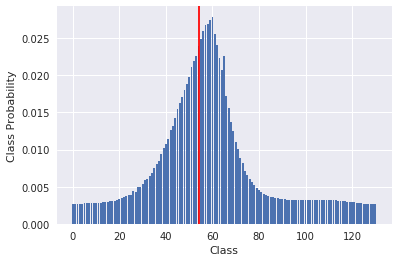

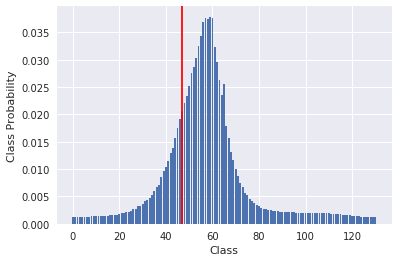

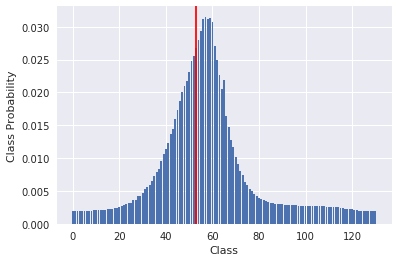

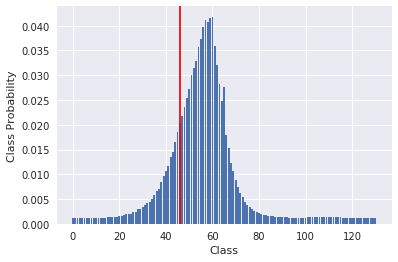

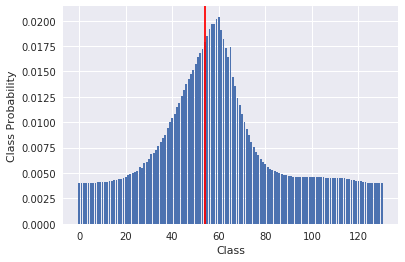

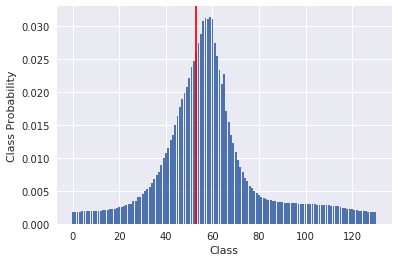

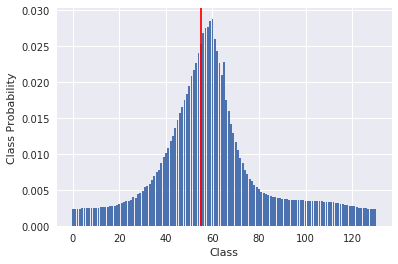

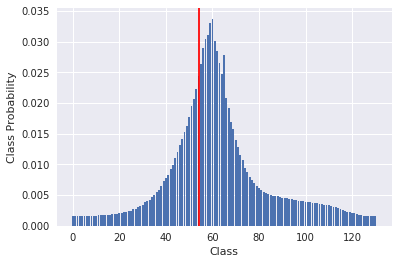

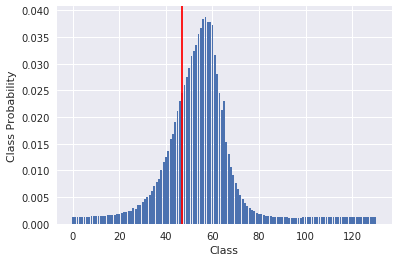

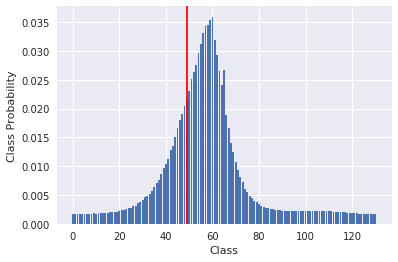

In [29]:
# analyze probability of mid class labels
mid_class_labels = [i for i, l in enumerate(lr_data_sets.train.labels) if l >= 45 and l <= 55]
for idx in mid_class_labels[:10]:
    plt.bar(np.arange(len(predicted_classes_temperature[idx])), predicted_classes_temperature[idx])
    plt.axvline(lr_data_sets.train.labels[idx], color='red')
    plt.xlabel('Class')
    plt.ylabel('Class Probability')
    plt.show()

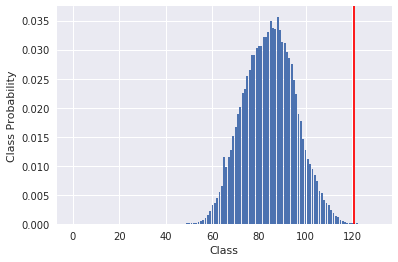

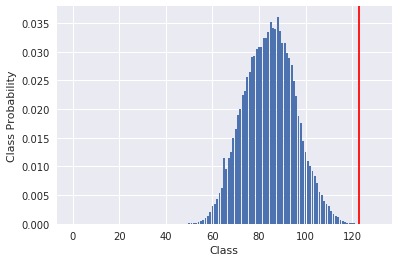

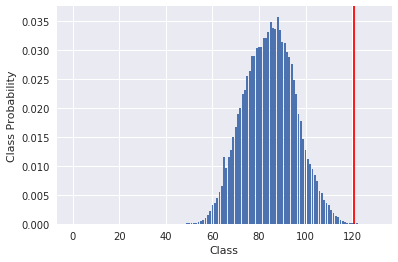

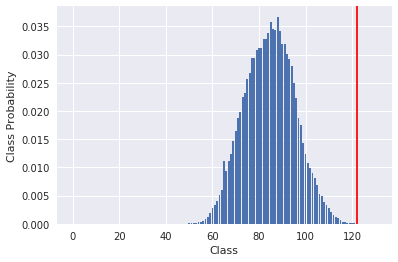

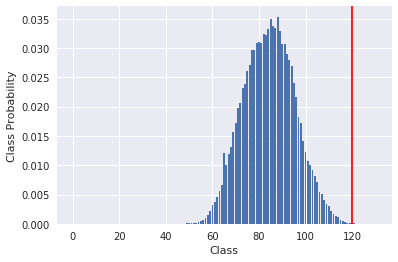

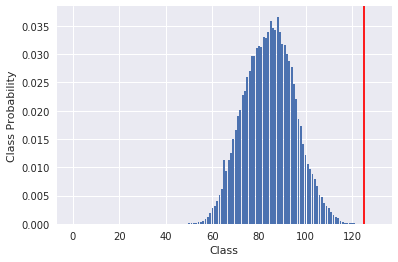

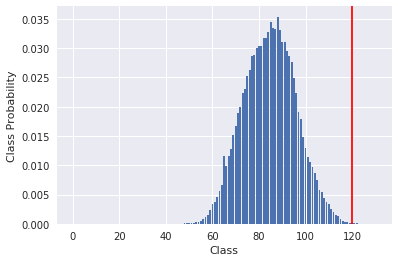

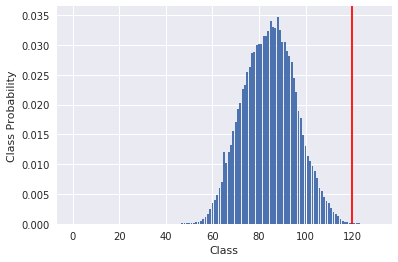

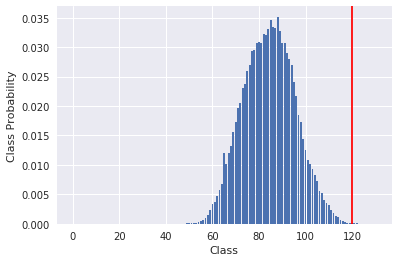

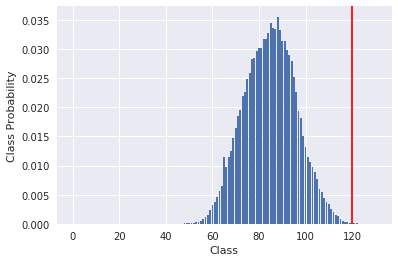

In [24]:
# analyze probability of high class labels
high_class_labels = [i for i, l in enumerate(lr_data_sets.train.labels) if l >= 120]
for idx in high_class_labels[:10]:
    plt.bar(np.arange(len(predicted_classes_temperature[idx])), predicted_classes_temperature[idx])
    plt.axvline(lr_data_sets.train.labels[idx], color='red')
    plt.xlabel('Class')
    plt.ylabel('Class Probability')
    plt.show()

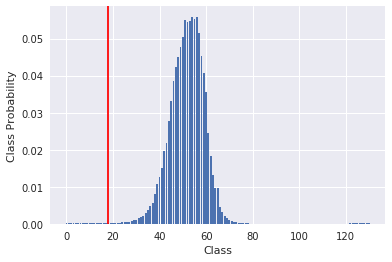

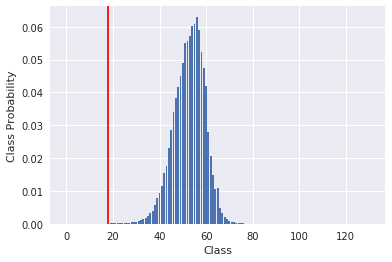

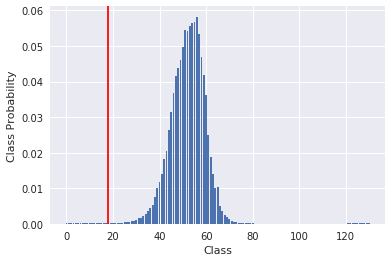

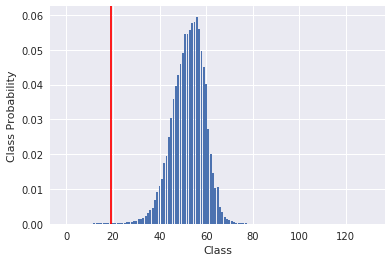

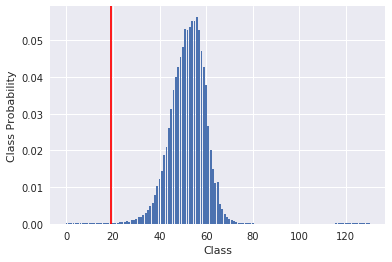

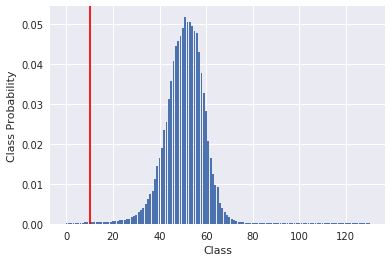

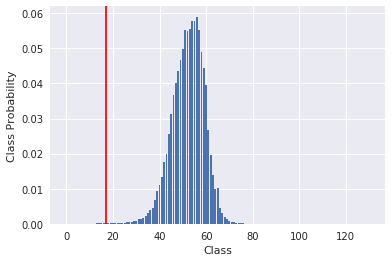

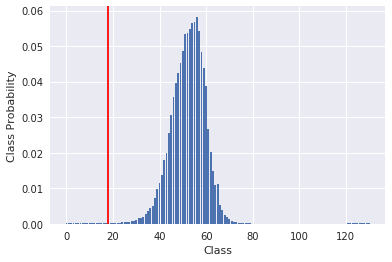

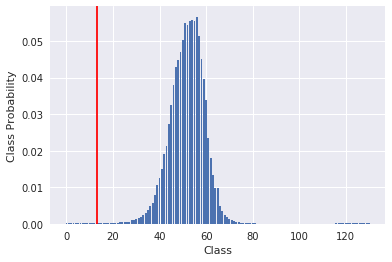

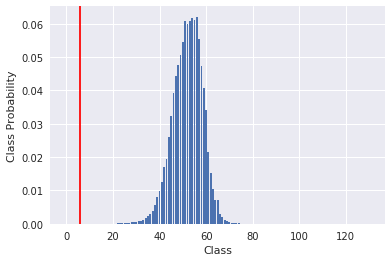

In [25]:
# analyze probability of low class labels
low_class_labels = [i for i, l in enumerate(lr_data_sets.train.labels) if l <= 20]
for idx in low_class_labels[:10]:
    plt.bar(np.arange(len(predicted_classes_temperature[idx])), predicted_classes_temperature[idx])
    plt.axvline(lr_data_sets.train.labels[idx], color='red')
    plt.xlabel('Class')
    plt.ylabel('Class Probability')
    plt.show()

### Calculate log loss per sample

In [43]:
def log_loss(arr):
    y_probabilites = arr[1:]
    y_one_hot = np.zeros(len(y_probabilites))
    y_one_hot[int(arr[0])] = 1
    return -np.sum(y_one_hot*np.log(y_probabilites))

stacked_data = np.concatenate((tf_model.data_sets.train.labels[...,None], predicted_classes), axis=1)
losses_temperature = np.apply_along_axis(log_loss, 1, stacked_data)

### Plot loss distribution of logistic regression

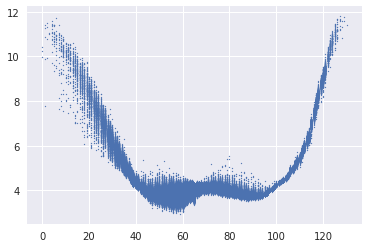

In [47]:
plt.scatter(tf_model.data_sets.train.labels, losses_temperature, s=1)
plt.show()

### Calculate influences for temperature prediciton

In [48]:
influences_complete_test_data_temperature = tf_model.get_influence_on_test_loss(
    list(test_data_set.index), 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples

Norm of test gradient: 0.11179259675444546
Function value: -0.08802310745749829
Split function value: 0.08799315755345884, -0.17601626501095713
Predicted loss diff on train_idx 5: -1.3546262893340675e-07
Function value: -0.11075969398252866
Split function value: 0.09910927649689422, -0.20986897047942288
Predicted loss diff on train_idx 5: -1.2052079049896387e-07
Function value: -0.11287255917523556
Split function value: 0.10513441866291515, -0.2180069778381507
Predicted loss diff on train_idx 5: -4.8793690576051034e-08
Function value: -0.11370234537265592
Split function value: 0.11104402696642385, -0.22474637233907976
Predicted loss diff on train_idx 5: -6.74901859748754e-08
Function value: -0.11376338949855744
Split function value: 0.1130332543232434, -0.22679664382180084
Predicted loss diff on train_idx 5: -6.656877334675327e-08
Function value: -0.11378378240047435
Split function value: 0.1137882599572344, -0.22757204235770875
Predicted loss diff on train_idx 5: -6.540115003582348e-0

Multiplying by 819522 train examples took 275.9484181404114 sec


In [50]:
# save calculated influences
np.savez('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/influences_all_data_bucket_0_5_temperature', influences_complete_test_data_temperature)

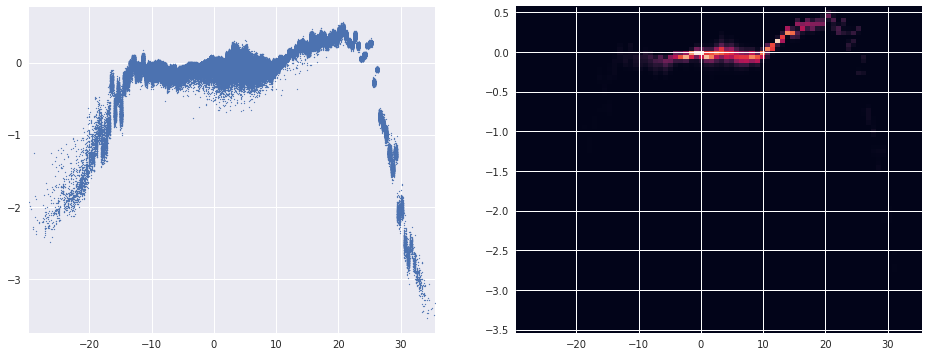

In [52]:
# plot influences against label
fig, ax = plt.subplots(1,2, figsize=(16,6), sharex=True)
ax[0].scatter(Y_train, influences_complete_test_data_temperature, s=1)
ax[1].hist2d(Y_train, influences_complete_test_data_temperature, bins=80)
plt.show()

### Plot distribution of train and test labels

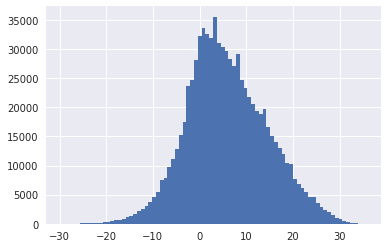

In [53]:
plt.hist(Y_train, bins=80)
plt.show()

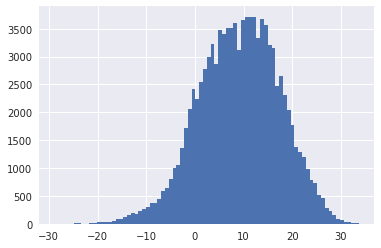

In [54]:
plt.hist(Y_test, bins=80)
plt.show()

### Plot sorted influences

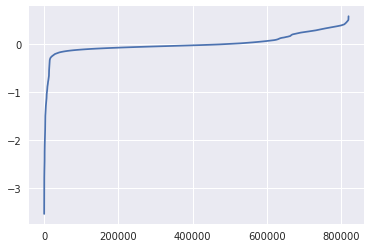

In [55]:
sorted_indices = np.argsort(influences_complete_test_data_temperature)
plt.plot(influences_complete_test_data_temperature[sorted_indices])
plt.show()

### Train a linear regression model on the data to predict the temperature like in the network model

In [56]:
linear_regression_model = LinearRegression().fit(X_train, Y_train)

In [57]:
predict_train = linear_regression_model.predict(X_train)
predict_test = linear_regression_model.predict(X_test)

In [58]:
train_absolute_errors = np.absolute(predict_train - Y_train)
test_absolute_errors = np.absolute(predict_test - Y_test)

In [59]:
# print error of logistic regression model
np.sqrt(np.mean(np.square(predict_train - Y_train))), np.sqrt(np.mean(np.square(predict_test - Y_test)))

(1.3075870858249468, 1.2839238064913678)

### Plot influences, log. reg. error, lin. reg. error

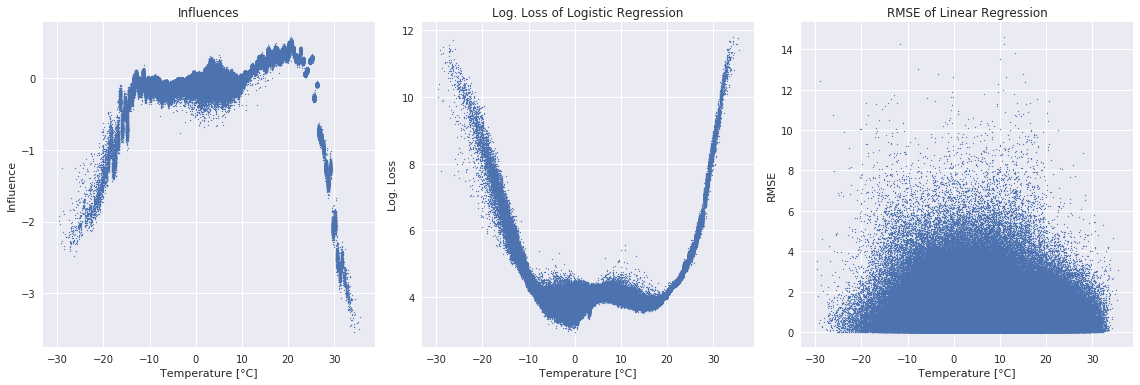

In [121]:
fig, ax = plt.subplots(1,3,figsize=(16,6), sharex=True)
# plot influences, loss of logistic regression and loss of linear regression
ax[0].scatter(Y_train, influences_complete_test_data_temperature, s=1)
ax[1].scatter(Y_train, losses_temperature, s=1)
ax[2].scatter(Y_train, train_absolute_errors, s=1)

for i in range(3):
    ax[i].set_xlabel('Temperature [°C]')
    
ax[0].set_ylabel('Influence')
ax[1].set_ylabel('Log. Loss')
ax[2].set_ylabel('RMSE')

ax[0].set_title('Influences')
ax[1].set_title('Log. Loss of Logistic Regression')
ax[2].set_title('RMSE of Linear Regression')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Evaluate whether the sklearn lin. reg. learns the sem as the model by plotting the scatter & calculating person r for mean error per label (binned statistic)

In [148]:
# select training data data
train_inits = [i[0] for i in prediction_error.init_type_mapping if i[1] == 'train']

In [154]:
predicted_model_errors = prediction_error.sel(data = 'difference').sel(init = train_inits).data.flatten()
predicted_model_labels = prediction_error.sel(data = 'target').sel(init = train_inits).data.flatten()

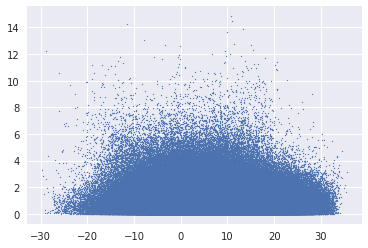

In [196]:
plt.scatter(predicted_model_labels, np.abs(predicted_model_errors), s=1)
plt.show()

### Plot error per label for original model and logistic regression

In [193]:
# filter samples with a "nan" label, because of missing measurements at stations
indices_without_nan = [idx for idx, value in enumerate(predicted_model_labels) if not np.isnan(value)]
mean_error_per_label_model = binned_statistic(predicted_model_labels[indices_without_nan], np.abs(predicted_model_errors[indices_without_nan]), 'mean', 150)

In [194]:
mean_error_per_label_lin_reg = binned_statistic(Y_train, train_absolute_errors, 'mean', 150)

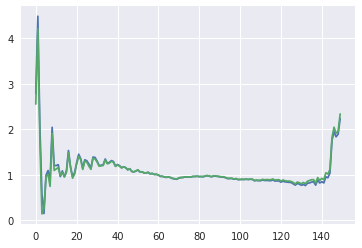

(0.9896907785788035, 8.116393849420484e-127)


In [195]:
plt.plot(mean_error_per_label_lin_reg.statistic)
plt.plot(mean_error_per_label_model.statistic)
plt.show()
print(pearsonr(mean_error_per_label_lin_reg.statistic, mean_error_per_label_model.statistic))


### Plot the distribution of the labels

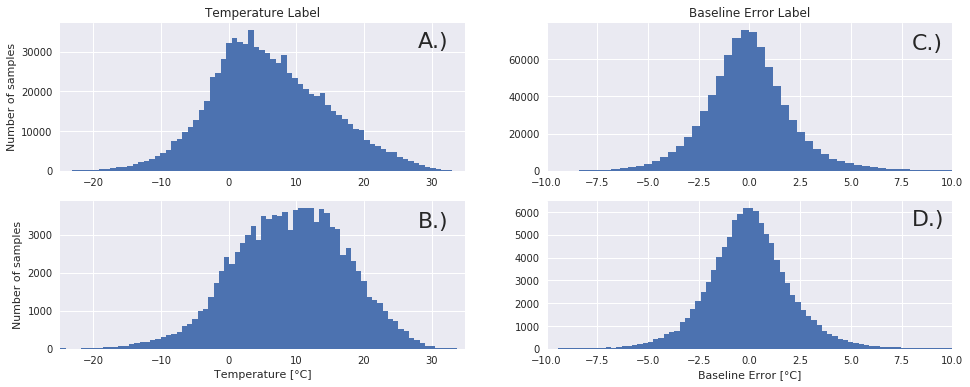

In [30]:
fig, ax = plt.subplots(2,2, figsize=(16,6))
ax[0,0].hist(neural_embeddings['train_labels'].as_matrix(), bins=80)
ax[0,1].hist(neural_embeddings_error_prediction['train_labels'].as_matrix(), bins=120)
ax[1,0].hist(neural_embeddings['test_labels'].as_matrix(), bins=80)
ax[1,1].hist(neural_embeddings_error_prediction['test_labels'].as_matrix(), bins=120)

ax[0,0].set_xlim(-25, 35)
ax[1,0].set_xlim(-25, 35)
ax[0,1].set_xlim(-10, 10)
ax[1,1].set_xlim(-10, 10)

ax[0,0].text(28, 31000, 'A.)', fontsize=22)
ax[1,0].text(28, 3200, 'B.)', fontsize=22)
ax[0,1].text(8, 65000, 'C.)', fontsize=22)
ax[1,1].text(8, 5400, 'D.)', fontsize=22)

ax[0,0].set_title('Temperature Label')
ax[0,1].set_title('Baseline Error Label')

ax[1,0].set_xlabel('Temperature [°C]')
ax[1,1].set_xlabel('Baseline Error [°C]')

ax[0,0].set_ylabel('Number of samples')
ax[1,0].set_ylabel('Number of samples')
plt.show()

## Prepare Data with Error Prediction

In [70]:
# split data set into train and test, the nerual embedding format of the data is ['init','station','emb_1',...,'emb_64']
train_data_set_error_prediction = neural_embeddings_error_prediction['train_embeddings']
train_label_set_error_prediction = neural_embeddings_error_prediction['train_labels']
test_data_se_error_prediction = neural_embeddings_error_prediction['test_embeddings']
test_label_set_error_prediction = neural_embeddings_error_prediction['test_labels']

# get numpy representation of neural embeddings
X_train_error_prediction = train_data_set_error_prediction.as_matrix()[:,2:]
Y_train_error_prediction = train_label_set_error_prediction.as_matrix()
X_test_error_prediction = test_data_se_error_prediction.as_matrix()[:,2:]
Y_test_error_prediction = test_label_set_error_prediction.as_matrix()

# calculate number of training examples
num_train_examples_error_prediction = X_train_error_prediction.shape[0]
num_test_examples_error_prediction = X_test_error_prediction.shape[0]
num_features_error_prediction = X_train_error_prediction.shape[1]

In [72]:
# adapt the labels to classes
min_label_error_prediction, max_label_error_prediction = np.minimum(np.min(Y_train_error_prediction),np.min(Y_test_error_prediction)),np.maximum(np.max(Y_train_error_prediction),np.max(Y_test_error_prediction))

# we keep the same number of classes to be consistent
n_classes_error_prediction = n_classes

# get index of bucket for each training data
train_error_bucket_index = np.digitize(Y_train_error_prediction, np.linspace(min_label_error_prediction,max_label_error_prediction,n_classes_error_prediction))-1
test_error_bucket_index = np.digitize(Y_test_error_prediction, np.linspace(min_label_error_prediction,max_label_error_prediction, n_classes_error_prediction))-1

### Filter data with very low bucket indices, since LogReg implementation in sklearn can not handle classes without training samples resulting in a dimension problem during calculation

In [74]:
n_classes_error_prediction, len(set(train_error_bucket_index)), len(set(test_error_bucket_index))

(131, 110, 77)

In [75]:
[i for i in np.arange(np.max(list(set(train_error_bucket_index))) + 1) if i not in set(train_error_bucket_index)]

[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 22, 23, 30, 129]

In [76]:
filtered_train_label_indices = ((train_error_bucket_index > 30) & (train_error_bucket_index <129)).nonzero()[0]
filtered_test_label_indices = ((test_error_bucket_index > 30) & (test_error_bucket_index <129)).nonzero()[0]
print('Filtered train: %s, filtered test: %s' % (num_train_examples_error_prediction - len(filtered_train_label_indices), num_test_examples_error_prediction - len(filtered_test_label_indices)))

Filtered train: 21, filtered test: 0


In [77]:
# re-scale the labels to start at 0 otherwise an exception occures in the shapley value calculation
min_train_label = np.min(train_error_bucket_index[filtered_train_label_indices])

rescaled_filtered_train_labels_error_prediction = train_error_bucket_index[filtered_train_label_indices] - min_train_label
rescaled_filtered_test_labels_error_prediction = test_error_bucket_index[filtered_test_label_indices] - min_train_label

In [78]:
lr_train_error_prediction = DataSet(X_train_error_prediction[filtered_train_label_indices], rescaled_filtered_train_labels_error_prediction)
lr_validation_error_prediction = None
lr_test_error_prediction = DataSet(X_test_error_prediction[filtered_test_label_indices], rescaled_filtered_test_labels_error_prediction)
lr_data_sets_error_prediction = base.Datasets(train=lr_train_error_prediction, validation=lr_validation_error_prediction, test=lr_test_error_prediction)
print("%s training samples, %s test samples." % (lr_train_error_prediction.num_examples, lr_test_error_prediction.num_examples))

819501 training samples, 103210 test samples.


In [79]:
n_classes_error_prediction_filtered = len(set(lr_train_error_prediction.labels))
print('Filtered %s classes and %s samples.' % (str(n_classes_error_prediction - len(set(lr_train_error_prediction.labels))), str(num_train_examples - lr_train_error_prediction.num_examples)))

Filtered 33 classes and 21 samples.


## Prepare Model

In [80]:
num_classes = n_classes_error_prediction_filtered
input_dim = num_features_error_prediction
weight_decay = 0.01
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000

num_params = num_features_error_prediction

In [81]:
tf.reset_default_graph()

tf_model_error_prediction = LogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_data_sets_error_prediction,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='cosmo_correction_nerual_embedding_logreg')

tf_model_error_prediction.train(verbose=True)

Total number of parameters: 6272
Using normal model


/home/ninow/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


(819501, 64) (819501,)
(98, 64)
(6272,)
LBFGS training took [11] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 3.832795
Train loss (w/o reg) on all data: 3.5133512
Test loss (w/o reg) on all data: 3.5044305
Train acc on all data:  0.09774972818825114
Test acc on all data:   0.09712237186319155
Norm of the mean of gradients: 3.3928325e-05
Norm of the params: 7.9930444


In [90]:
predicted_classes_error = tf_model_error_prediction.sklearn_model.predict_proba(lr_data_sets_error_prediction.train.x)

### Analyze predicted probabilities

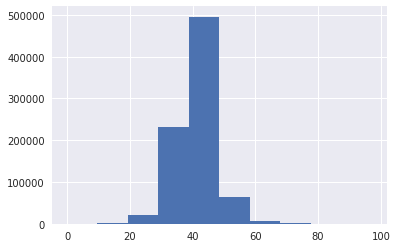

In [87]:
plt.hist(lr_data_sets_error_prediction.train.labels)
plt.show()

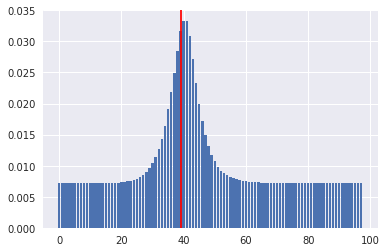

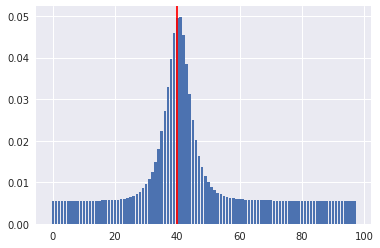

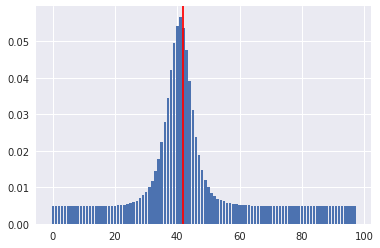

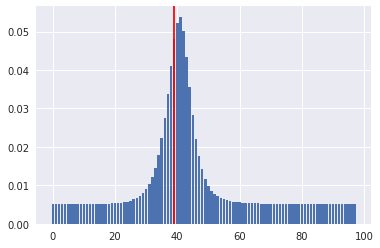

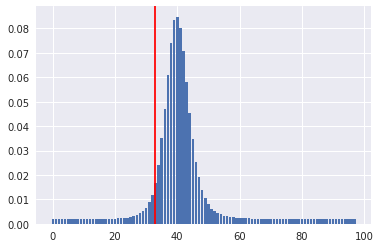

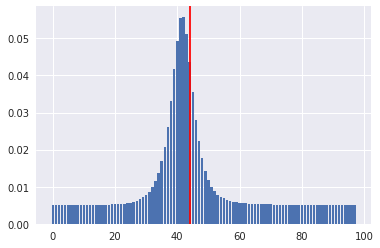

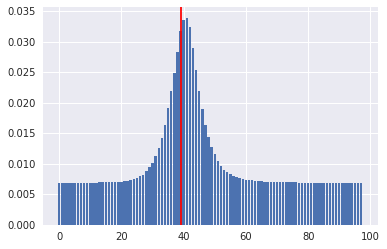

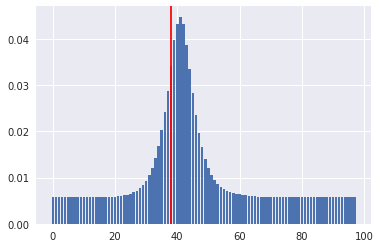

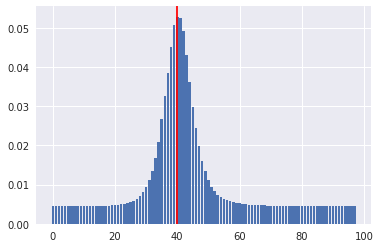

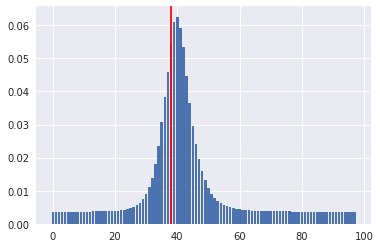

In [99]:
# analyze probability of mid class labels
mid_class_labels = [i for i, l in enumerate(lr_data_sets_error_prediction.train.labels) if l >= 30 and l <= 50]
for idx in mid_class_labels[:10]:
    plt.bar(np.arange(len(predicted_classes_error[idx])), predicted_classes_error[idx])
    plt.axvline(lr_data_sets_error_prediction.train.labels[idx], color='red')
    plt.show()

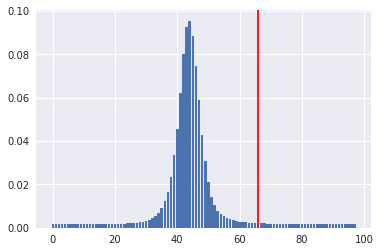

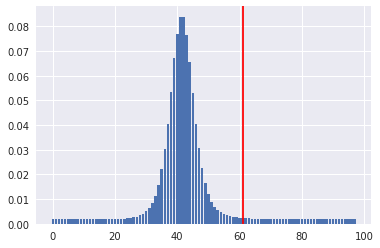

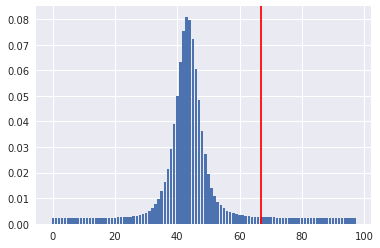

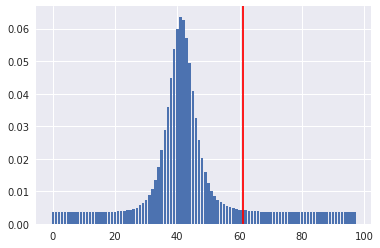

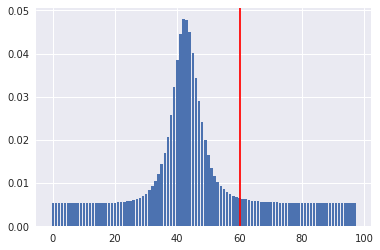

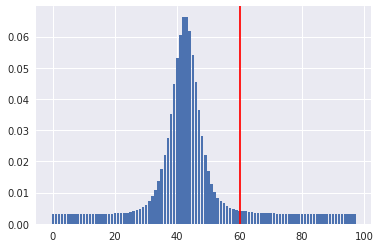

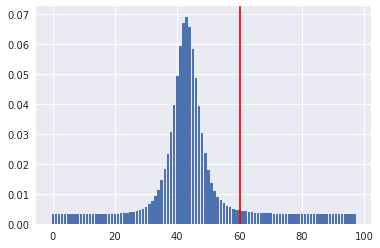

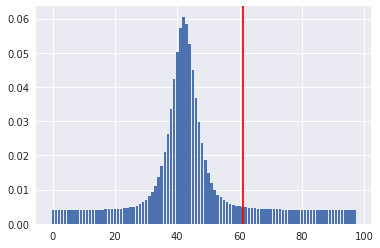

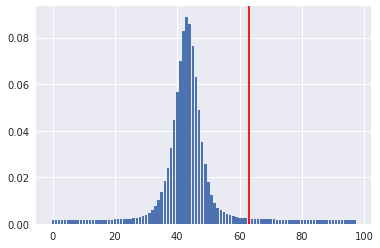

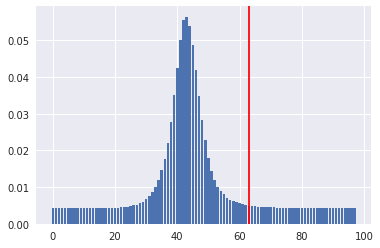

In [100]:
# analyze probability of high class labels
high_class_labels = [i for i, l in enumerate(lr_data_sets_error_prediction.train.labels) if l >= 60]
for idx in high_class_labels[:10]:
    plt.bar(np.arange(len(predicted_classes_error[idx])), predicted_classes_error[idx])
    plt.axvline(lr_data_sets_error_prediction.train.labels[idx], color='red')
    plt.show()

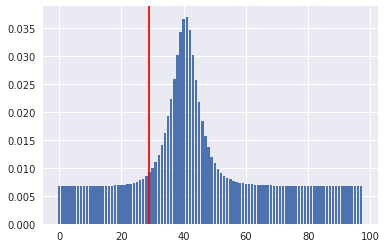

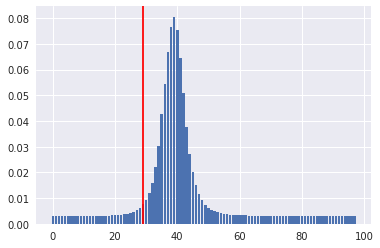

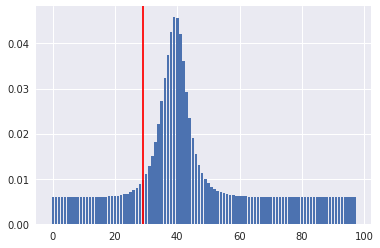

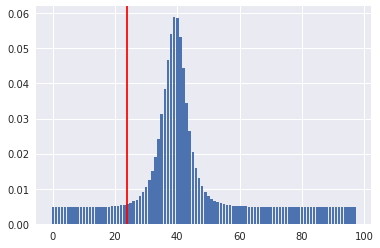

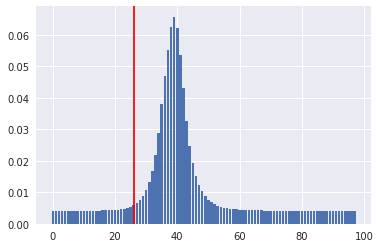

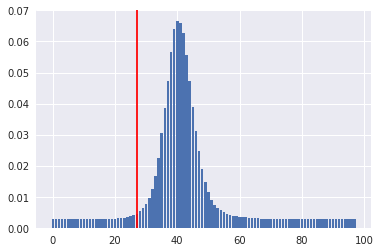

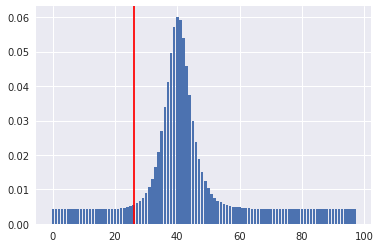

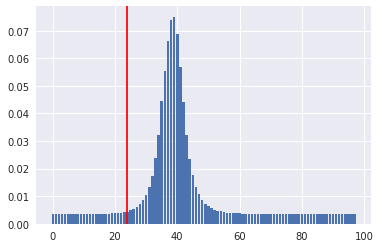

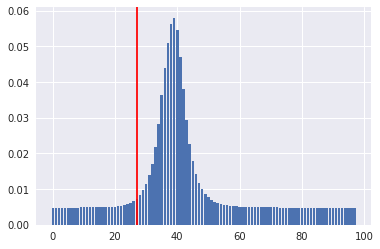

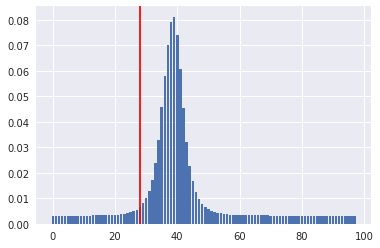

In [101]:
# analyze probability of high class labels
low_class_labels = [i for i, l in enumerate(lr_data_sets_error_prediction.train.labels) if l < 30]
for idx in low_class_labels[:10]:
    plt.bar(np.arange(len(predicted_classes_error[idx])), predicted_classes_error[idx])
    plt.axvline(lr_data_sets_error_prediction.train.labels[idx], color='red')
    plt.show()

### Calculate log loss per sample

In [102]:
def log_loss(arr):
    y_probabilites = arr[1:]
    y_one_hot = np.zeros(len(y_probabilites))
    y_one_hot[int(arr[0])] = 1
    return -np.sum(y_one_hot*np.log(y_probabilites))

stacked_data_error = np.concatenate((tf_model_error_prediction.data_sets.train.labels[...,None], predicted_classes_error), axis=1)
losses_error = np.apply_along_axis(log_loss, 1, stacked_data_error)

### Plot loss distribution of logistic regression

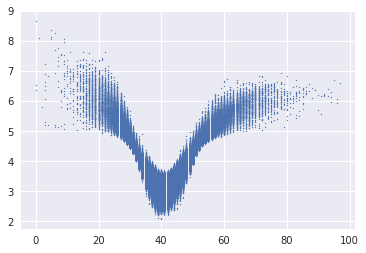

In [104]:
plt.scatter(tf_model_error_prediction.data_sets.train.labels, losses_error, s=1)
plt.show()

### Calculate influences for COSMO-1 error prediction

In [82]:
influences_complete_test_data_error = tf_model_error_prediction.get_influence_on_test_loss(
    list(filtered_test_label_indices), 
    np.arange(len(tf_model_error_prediction.data_sets.train.labels)),
    force_refresh=True) * num_train_examples

Norm of test gradient: 0.08341608577863441
Function value: -0.14157648258216765
Split function value: 0.14160437727112563, -0.2831808598532933
Predicted loss diff on train_idx 5: -1.867948109540515e-06
Function value: -0.16293578564225908
Split function value: 0.15259890742255688, -0.31553469306481596
Predicted loss diff on train_idx 5: -1.8341537036490094e-06
Function value: -0.16410906129313543
Split function value: 0.16316200709579495, -0.3272710683889304
Predicted loss diff on train_idx 5: -1.8743601238004106e-06
Function value: -0.16421897751764453
Split function value: 0.16413367807918505, -0.3283526555968296
Predicted loss diff on train_idx 5: -1.852903277855766e-06
Function value: -0.16421942758642988
Split function value: 0.1642170270421952, -0.3284364546286251
Predicted loss diff on train_idx 5: -1.8530083576799007e-06
Function value: -0.16421942890536945
Split function value: 0.1642194427220508, -0.32843887162742025
Predicted loss diff on train_idx 5: -1.8529966512879225e-06

Multiplying by 819501 train examples took 266.0258491039276 sec


In [84]:
# save calculated influences
np.savez('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/influences_all_data_bucket_0_5_error', influences_complete_test_data_error)

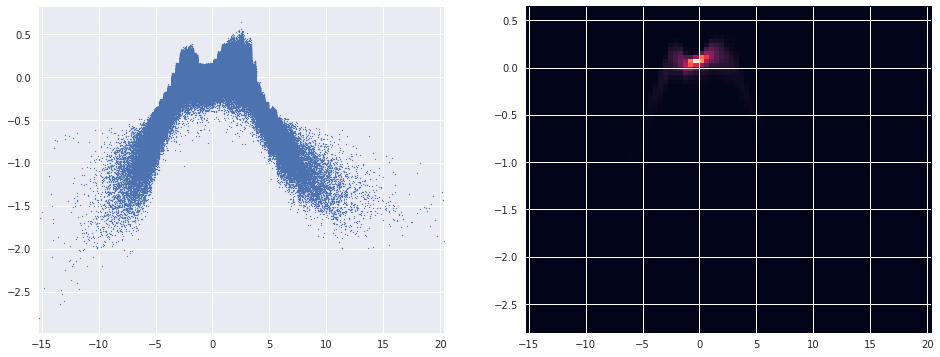

In [106]:
# plot influences against label
fig, ax = plt.subplots(1,2, figsize=(16,6), sharex=True)
ax[0].scatter(Y_train_error_prediction[filtered_train_label_indices], influences_complete_test_data_error, s=1)
ax[1].hist2d(Y_train_error_prediction[filtered_train_label_indices], influences_complete_test_data_error, bins=80)
plt.show()

### Plot distribution of COSMO-1 error prediction label

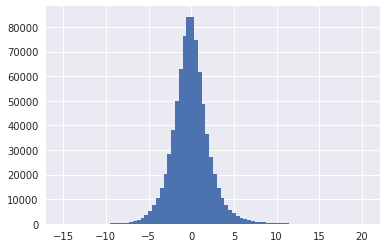

In [107]:
plt.hist(Y_train_error_prediction[filtered_train_label_indices], bins=80)
plt.show()

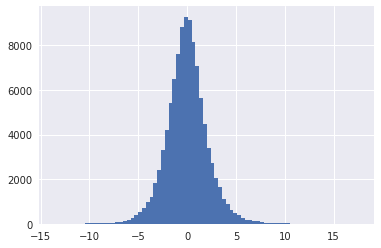

In [108]:
plt.hist(Y_test_error_prediction[filtered_test_label_indices], bins=80)
plt.show()

### Plot sorted influences

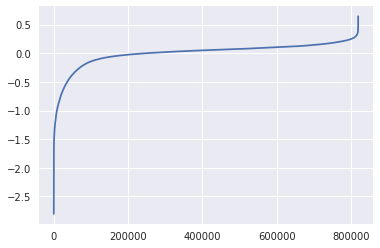

In [109]:
sorted_indices_error = np.argsort(influences_complete_test_data_error)
plt.plot(influences_complete_test_data_error[sorted_indices_error])
plt.show()

### Train a linear regression model on the data to predict the error like in the network model

In [110]:
linear_regression_model_error_prediction = LinearRegression().fit(X_train_error_prediction, Y_train_error_prediction)

In [111]:
predict_train_error_prediction = linear_regression_model_error_prediction.predict(X_train_error_prediction)
predict_test_error_prediction = linear_regression_model_error_prediction.predict(X_test_error_prediction)

In [112]:
train_absolute_errors_error_prediction = np.absolute(predict_train_error_prediction - Y_train_error_prediction)
test_absolute_errors_error_prediction = np.absolute(predict_test_error_prediction - Y_test_error_prediction)

In [113]:
# plot train and test error of linear regression
np.sqrt(np.mean(np.square(predict_train_error_prediction - Y_train_error_prediction))), np.sqrt(np.mean(np.square(predict_test_error_prediction - Y_test_error_prediction)))

(1.2898031155677618, 1.2686340077861344)

### Plot influences, log. reg. error, lin. reg. error

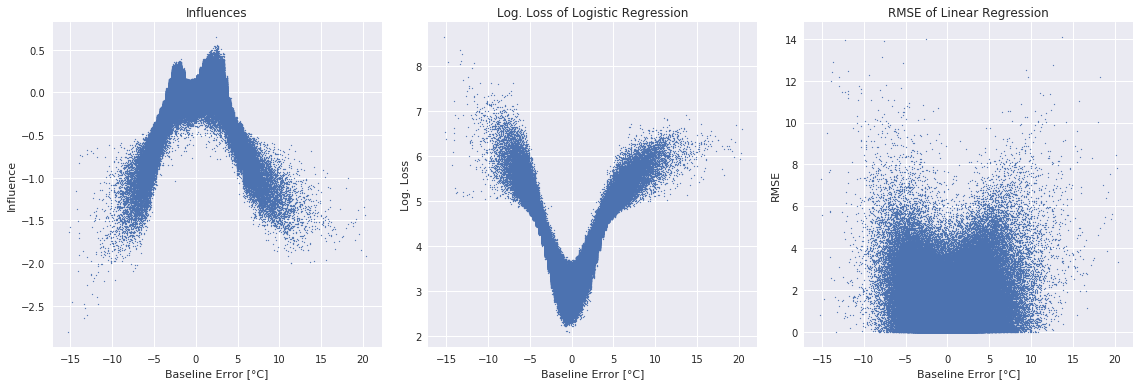

In [122]:
fig, ax = plt.subplots(1,3,figsize=(16,6), sharex=True)
# plot influences, loss of logistic regression and loss of linear regression
ax[0].scatter(Y_train_error_prediction[filtered_train_label_indices], influences_complete_test_data_error, s=1)
ax[1].scatter(Y_train_error_prediction[filtered_train_label_indices], losses_error, s=1)
ax[2].scatter(Y_train_error_prediction[filtered_train_label_indices], train_absolute_errors_error_prediction[filtered_train_label_indices], s=1)

for i in range(3):
    ax[i].set_xlabel('Baseline Error [°C]')
    
ax[0].set_ylabel('Influence')
ax[1].set_ylabel('Log. Loss')
ax[2].set_ylabel('RMSE')

ax[0].set_title('Influences')
ax[1].set_title('Log. Loss of Logistic Regression')
ax[2].set_title('RMSE of Linear Regression')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Results for selected test points in KNN experiment for comparison of KNN aproach and influence results

### Load data from KNN experiment

In [236]:
shapley_results_knn = np.load('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_bucket_0_5_k_50.npz')['arr_0']

In [239]:
# aggregate results from KNN approach
complete_shapley_sum = None
test_indices_knn = None
for result in shapley_results_knn:
    try:
        complete_shapley_sum += result[1]
        test_indices_knn += result[0]
    except:
        print('First')
        complete_shapley_sum = result[1]
        test_indices_knn = result[0]

First


In [240]:
shapley_sum_knn = complete_shapley_sum
test_indices_knn = test_indices_knn

## Prepare Data with direct Temperature Prediction

In [247]:
# split data set into train and test, the nerual embedding format of the data is ['init','station','emb_1',...,'emb_64']
train_data_set = neural_embeddings['train_embeddings']
train_label_set = neural_embeddings['train_labels']
test_data_set = neural_embeddings['test_embeddings'].iloc[test_indices_knn]
test_label_set = neural_embeddings['test_labels'].iloc[test_indices_knn]

# get numpy representation of neural embeddings
X_train = train_data_set.as_matrix()[:,2:]
Y_train = train_label_set.as_matrix()
X_test = test_data_set.as_matrix()[:,2:]
Y_test = test_label_set.as_matrix()

# calculate number of training examples
num_train_examples = X_train.shape[0]
num_test_examples = X_test.shape[0]
num_features = X_train.shape[1]

In [250]:
# set bucket size in degree for classification transformation
bucket_size = 0.5

# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train),np.min(Y_test)), np.maximum(np.max(Y_train),np.max(Y_test))
n_classes = int(np.ceil((max_label - min_label)/bucket_size))

# get index of bucket for each training data
train_temp_bucket_index = np.digitize(Y_train, np.linspace(min_label,max_label,n_classes))-1
test_temp_bucket_index = np.digitize(Y_test, np.linspace(min_label,max_label, n_classes))-1

In [251]:
lr_train = DataSet(X_train, train_temp_bucket_index)
lr_validation = None
lr_test = DataSet(X_test, test_temp_bucket_index)
lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)
print("%s training samples, %s test samples." % (lr_train.num_examples, lr_test.num_examples))

819522 training samples, 20642 test samples.


In [252]:
n_classes, len(set(train_temp_bucket_index)), len(set(test_temp_bucket_index))

(131, 131, 114)

## Prepare Model

In [253]:
num_classes = n_classes
input_dim = num_features
weight_decay = 0.01
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000

num_params = num_features

In [254]:
tf.reset_default_graph()

tf_model = LogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='cosmo_correction_nerual_embedding_logreg')

tf_model.train(verbose=True)

Total number of parameters: 8384


/home/ninow/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Using normal model
(819522, 64) (819522,)
(131, 64)
(8384,)
LBFGS training took [22] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 4.2536187
Train loss (w/o reg) on all data: 4.063599
Test loss (w/o reg) on all data: 4.0433416
Train acc on all data:  0.06899997803597707
Test acc on all data:   0.06399573684720473
Norm of the mean of gradients: 1.6533526e-05
Norm of the params: 6.1647396


### Calcluate influences on the same test points as in the KNN approach (temperature prediction)

In [260]:
influences_knn_test_data_temperature = tf_model.get_influence_on_test_loss(
    list(np.arange(len(test_data_set.index))), 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples

Norm of test gradient: 0.11731171
Function value: -0.09129588305950165
Split function value: 0.09126365184783936, -0.18255953
Predicted loss diff on train_idx 5: -1.578215892499921e-07
Function value: -0.11490212380886078
Split function value: 0.10440176725387573, -0.21930389
Predicted loss diff on train_idx 5: -1.3488180832959428e-07
Function value: -0.11698289960622787
Split function value: 0.10967164486646652, -0.22665454
Predicted loss diff on train_idx 5: -6.273617747029205e-08
Function value: -0.11780448257923126
Split function value: 0.11490954458713531, -0.23271403
Predicted loss diff on train_idx 5: -8.206509211915205e-08
Function value: -0.11786462366580963
Split function value: 0.11704301834106445, -0.23490764
Predicted loss diff on train_idx 5: -8.065608377934782e-08
Function value: -0.11788574606180191
Split function value: 0.11789502948522568, -0.23578078
Predicted loss diff on train_idx 5: -7.963014955351731e-08
Function value: -0.11788587272167206
Split function value: 

Multiplying by 819522 train examples took 951.3915340900421 sec


In [261]:
# store calculated influences
np.savez('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/influence_results_20_percent_bucket_0_5_', influences_knn_test_data_temperature)

### Plot scatter of KNN-values against influences

In [9]:
# load influences
influences_bucket_0_5_temperature = np.load('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/influence_results_20_percent_bucket_0_5_.npz')['arr_0']

In [ ]:
# load Shaple values
knn_shapley_values_0_5_temperature = np.load('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_bucket_0_5_k_50.npz')['arr_0']

In [15]:
# aggregate Shaple value results
knn_shapley_sum_0_5_temperature = None
for result in knn_shapley_values_0_5_temperature:
    try:
        knn_shapley_sum_0_5_temperature += result[1]
    except:
        print('First')
        knn_shapley_sum_0_5_temperature = result[1]

First


In [16]:
influences_bucket_0_5_temperature.shape, knn_shapley_sum_0_5_temperature.shape

((819522,), (819522,))

### Plot all shapley values

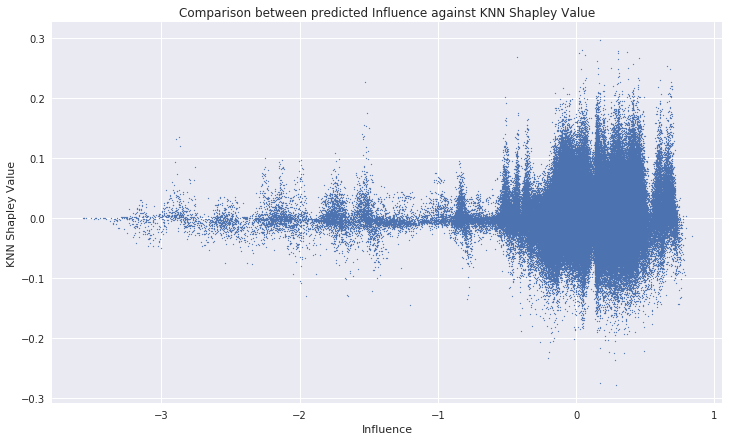

In [17]:
plt.figure(figsize=(12,7))
plt.scatter(influences_bucket_0_5_temperature, knn_shapley_sum_0_5_temperature, s=1)
plt.title('Comparison between predicted Influence against KNN Shapley Value')
plt.xlabel('Influence')
plt.ylabel('KNN Shapley Value')
plt.show()

### Calculate perason correlation between Shapley values and Influences

In [18]:
pearsonr(influences_bucket_0_5_temperature, knn_shapley_sum_0_5_temperature)

(0.09825442853161055, 0.0)

### Plot only positive Shapley values

In [19]:
positive_shapley_value_indices = [idx for idx, value in enumerate(knn_shapley_sum_0_5_temperature) if value >= 0]

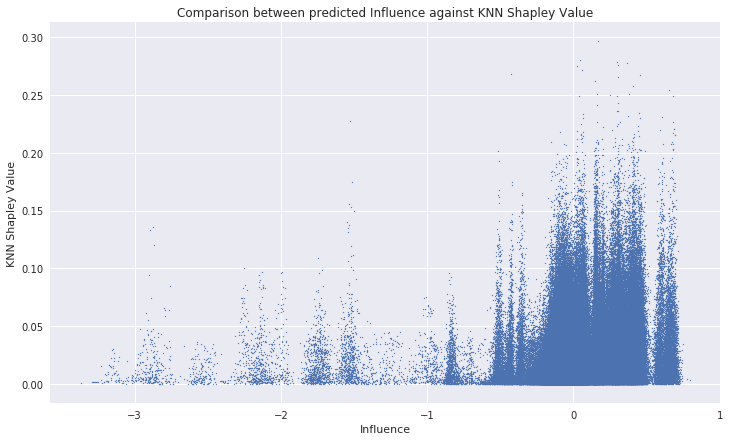

In [20]:
plt.figure(figsize=(12,7))
plt.scatter(influences_bucket_0_5_temperature[positive_shapley_value_indices], knn_shapley_sum_0_5_temperature[positive_shapley_value_indices], s=1)
plt.title('Comparison between predicted Influence against KNN Shapley Value')
plt.xlabel('Influence')
plt.ylabel('KNN Shapley Value')
plt.show()

### Calculate perason correlation between Shapley values and Influences

In [21]:
pearsonr(influences_bucket_0_5_temperature[positive_shapley_value_indices], knn_shapley_sum_0_5_temperature[positive_shapley_value_indices])

(0.20341947555283088, 0.0)

### Plot only top 1000K Shapley values

In [31]:
top_1000k_shapley_values = list(np.argsort(knn_shapley_sum_0_5_temperature)[-10000:])

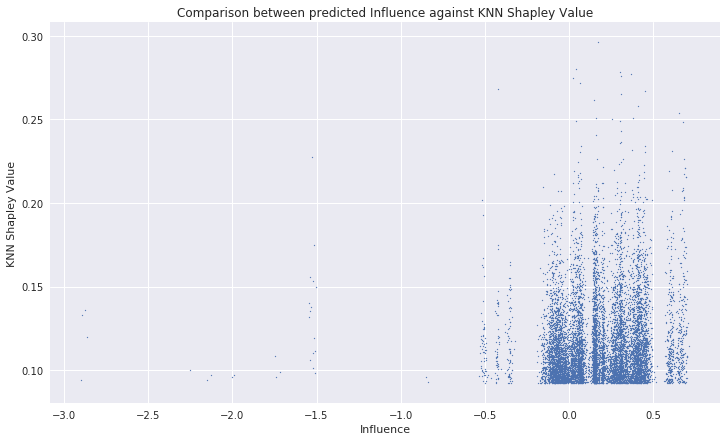

In [30]:
plt.figure(figsize=(12,7))
plt.scatter(influences_bucket_0_5_temperature[top_1000k_shapley_values], knn_shapley_sum_0_5_temperature[top_1000k_shapley_values], s=1)
plt.title('Comparison between predicted Influence against KNN Shapley Value')
plt.xlabel('Influence')
plt.ylabel('KNN Shapley Value')
plt.show()

### Calculate perason correlation between Shapley values and Influences

In [ ]:
pearsonr(influences_bucket_0_5_temperature[positive_shapley_value_indices], knn_shapley_sum_0_5_temperature[positive_shapley_value_indices])

# Backup (not used)

## Define Helper Function

### Plot results for test idx and corresponding influences

In [6]:
month_dict={0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sept', 9:'Okt', 10:'Nov', 11:'Dec'}


def plotSummedInfluences(influences, title, test_idx=0):
    # get init, station, rlat, rlon, height and height difference for test idx
    test_init, test_station = test_data_set.iloc[test_idx].as_matrix()[0:2]
    test_station_rlat, test_station_rlon, test_station_height = station_positions.sel(station = test_station).data
    test_station_hh_diff = station_heigh_diff.sel(station = test_station).data

    # index in array representation of stations
    test_station_idx = stations.data.tolist().index(test_station)
    # get formatted station name
    test_station_name = station_names[test_station_idx].item()
    
    # define number of influences to be plotted
    k_largest_influences = 500
    k_smallest_influences = 500

    # get largest and smallest influences
    largest_influence_idx = np.argsort(influences)[-k_largest_influences:]
    smallest_influence_idx = np.argsort(influences)[:k_smallest_influences]

    # get array of ('Station','Init') ordered by training sample indices
    init_station_train_data = train_data_set.loc[:,'Init':'Station'].as_matrix()
    
    # get station & init samples with the largest influence
    station_init_by_largest_influence = []
    for train_sample_idx in largest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_largest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_largest_influence = sorted(station_init_by_largest_influence, key=itemgetter(2))
    largest_influence_data = np.array(list(zip(*station_init_by_largest_influence)), dtype='float64')

    # get station & init samples with the smallest influence
    station_init_by_smallest_influence = []
    for train_sample_idx in smallest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_smallest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_smallest_influence = sorted(station_init_by_smallest_influence, key=itemgetter(2))
    smallest_influence_data = np.array(list(zip(*station_init_by_smallest_influence)), dtype='float64')

    # plot influence by station
    fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(12,12))
    
    # sum influence of most influential points per station
    sum_largest_influences_per_station = np.bincount(largest_influence_data[0].astype(int),largest_influence_data[2],
                                                     np.max(stations.data)+1)[stations]
    sum_smallest_influences_per_station = np.bincount(smallest_influence_data[0].astype(int),smallest_influence_data[2],
                                                      np.max(stations.data)+1)[stations]
    
    # plot stations with largest effect
    cax = axes[0].scatter(station_positions.sel(positinal_attribute = 'rlon'),
                 station_positions.sel(positinal_attribute = 'rlat'),
                 c=sum_largest_influences_per_station, s=200, cmap='RdBu',
                 norm=mpl.colors.Normalize(vmin=-np.max(sum_largest_influences_per_station),
                                           vmax=np.max(sum_largest_influences_per_station)))
    axes[0].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=8)
    fig.colorbar(cax, ax=axes[0])
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    cax = axes[1].scatter(station_positions.sel(positinal_attribute = 'rlon'),
                 station_positions.sel(positinal_attribute = 'rlat'),
                 c=sum_smallest_influences_per_station, s=200, cmap='RdBu',
                 norm=mpl.colors.Normalize(vmin=-np.max(sum_smallest_influences_per_station),
                                           vmax=np.max(sum_smallest_influences_per_station)))
    axes[1].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=8)
    fig.colorbar(cax, ax=axes[1])
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)

    plt.suptitle('Influences per Station for %s' % title)
    plt.show()
    plt.close()

    # plot influence by hour
    fig, axes = plt.subplots(figsize=(16,8))
    
    # sum influence of most influential points per hour
    sum_largest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 24)
    sum_smallest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 24)
    
    max_absolute_influence = np.max(np.absolute(sum_largest_influences_per_hour)) * 1.1
    min_absolute_influence = - np.max(np.absolute(sum_smallest_influences_per_hour)) * 2                              
    
    # plot stations with largest effect
    axes.bar(np.arange(0,24), sum_largest_influences_per_hour, color='blue')
    
    # plot stations with largest effect
    axes.bar(np.arange(0,24), sum_smallest_influences_per_hour, color='red')
    axes.axvline(x=int(test_init[6:8])+1,color='green')
    axes.set_xlim(-1,24,1)
    axes.set_ylim(min_absolute_influence, max_absolute_influence)
    
    plt.title('Influences per Hour for %s' % title)
    plt.setp(axes, xticks=range(24), xticklabels=["%02d:00" % h for h in range(24)])
    plt.show()
    plt.close()

    # plot influence by month
    fig, axes = plt.subplots(figsize=(16,8))
    
    # sum influence of most influential points per month
    sum_largest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 13)[1:]
    sum_smallest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 13)[1:]
    
    max_absolute_influence = np.max(np.absolute(sum_largest_influences_per_month)) * 1.1
    min_absolute_influence = - np.max(np.absolute(sum_smallest_influences_per_month)) * 2   
        
    # plot stations with largest effect
    axes.bar(np.arange(1,13), sum_largest_influences_per_month, color='blue')

    # plot stations with smallest effect
    axes.bar(np.arange(1,13), sum_smallest_influences_per_month, color='red')
    
    axes.axvline(x=int(test_init[2:4]),color='green')
    axes.set_xlim(0,13,1)
    axes.set_ylim(min_absolute_influence, max_absolute_influence)
    plt.title('Influences per Month for %s' % title)
    plt.setp(axes, xticks=np.arange(1,13), xticklabels=[month_dict[m] for m in range(12)])
    plt.show()
    plt.close()
    
    
    # plot influence by year
    fig, axes = plt.subplots(figsize=(16,8))
    
    # sum influence of most influential points per year
    sum_largest_influences_per_year = np.take(np.bincount([int(str(m)[:2]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 19), (15,16,17,18))
    sum_smallest_influences_per_year = np.take(np.bincount([int(str(m)[:2]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 19), (15,16,17,18))
    
    max_absolute_influence = np.max(np.absolute(sum_largest_influences_per_year)) * 1.1
    min_absolute_influence = - np.max(np.absolute(sum_smallest_influences_per_year)) * 2 
    
    # plot stations with largest effect
    axes.bar(np.arange(15,19), sum_largest_influences_per_year, color='blue')

    # plot stations with smallest effect
    axes.bar(np.arange(15,19), sum_smallest_influences_per_year, color='red')
    axes.set_xlim(14,19,1)
    axes.set_ylim(min_absolute_influence, max_absolute_influence)
    
    plt.title('Influences per Year for %s' % title)
    plt.setp(axes, xticks=np.arange(15,19), xticklabels=['2015', '2016', '2017', '2018'])
    plt.show()
    plt.close()
    
    # plot influence against height
    fig, axes = plt.subplots(figsize=(16,8))
    
    # sum influence of most influential points per height
    sum_largest_influences_per_height = np.bincount(largest_influence_data[5].astype(int), largest_influence_data[2])
    sum_smallest_influences_per_height = np.bincount(smallest_influence_data[5].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.max(np.absolute(sum_largest_influences_per_height)) * 1.1
    min_absolute_influence = - np.max(np.absolute(sum_smallest_influences_per_height)) * 2 
    
    # plot stations with largest effect
    axes.bar(range(len(sum_largest_influences_per_height)), sum_largest_influences_per_height, color='blue', width=15)
    
    # plot stations with smallest effect
    axes.bar(range(len(sum_smallest_influences_per_height)), sum_smallest_influences_per_height, color='red', width=15)
    
    axes.axvline(x=test_station_height,color='green')
    axes.set_ylim(min_absolute_influence, max_absolute_influence)
    
    plt.title('Influences per Height for %s' % title)
    plt.show()
    plt.close()

    # plot influence against height difference
    fig, axes = plt.subplots(figsize=(16,8))
    
    # sum influence of most influential points per height difference
    sum_largest_influences_per_height_difference = np.bincount(largest_influence_data[6].astype(int), largest_influence_data[2])
    sum_smallest_influences_per_height_difference = np.bincount(smallest_influence_data[6].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.max(np.absolute(sum_largest_influences_per_height_difference)) * 1.1
    min_absolute_influence = - np.max(np.absolute(sum_smallest_influences_per_height_difference)) * 2 
    
    # plot stations with largest effect
    axes.bar(range(len(sum_largest_influences_per_height_difference)), sum_largest_influences_per_height_difference, color='blue')

    # plot stations with smallest effect
    axes.bar(range(len(sum_smallest_influences_per_height_difference)), sum_smallest_influences_per_height_difference, color='red')
    
    axes.axvline(x=int(test_station_hh_diff*200),color='green')
    axes.set_ylim(min_absolute_influence, max_absolute_influence)
    axes.set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Influences per Height Difference for %s' % title)
    plt.show()
    plt.close()

# Results for Säntis on January/July and 03:00/15:00

### January, 03:00

In [74]:
test_säntis_january_03_00 = test_data_set.loc[test_data_set['Station'] == 35].loc[test_data_set['Init'].str.contains('..01..03')]

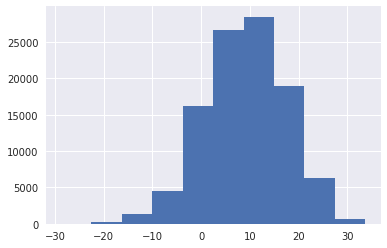

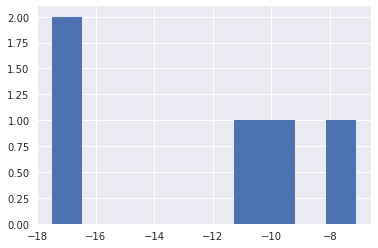

In [84]:
plt.hist(Y_test)
plt.show()
plt.hist(Y_test[test_säntis_january_03_00.index])
plt.show()

In [ ]:
influences_säntis_january_03_00 = tf_model.get_influence_on_test_loss(
    list(test_säntis_january_03_00.index), 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples

### January, 15:00

In [75]:
test_säntis_january_15_00 = test_data_set.loc[test_data_set['Station'] == 35].loc[test_data_set['Init'].str.contains('..01..15')]

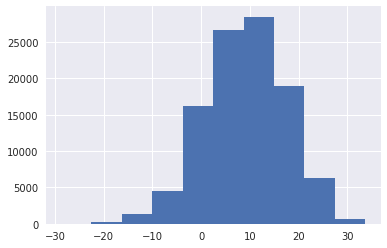

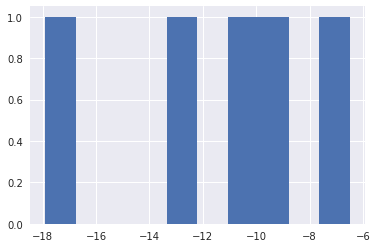

In [85]:
plt.hist(Y_test)
plt.show()
plt.hist(Y_test[test_säntis_january_15_00.index])
plt.show()

In [ ]:
influences_säntis_january_15_00 = tf_model.get_influence_on_test_loss(
    list(test_säntis_january_15_00.index), 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples

### July, 03:00 

In [76]:
test_säntis_july_03_00 = test_data_set.loc[test_data_set['Station'] == 35].loc[test_data_set['Init'].str.contains('..07..03')]

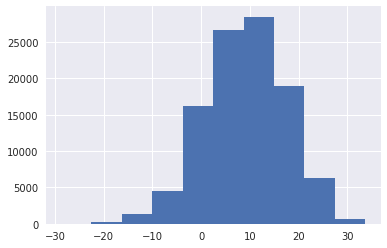

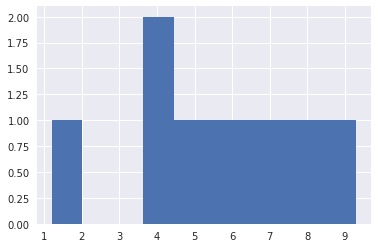

In [86]:
plt.hist(Y_test)
plt.show()
plt.hist(Y_test[test_säntis_july_03_00.index])
plt.show()

In [ ]:
influences_säntis_july_03_00 = tf_model.get_influence_on_test_loss(
    list(test_säntis_july_03_00.index), 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples

### July, 15:00

In [77]:
test_säntis_july_15_00 = test_data_set.loc[test_data_set['Station'] == 35].loc[test_data_set['Init'].str.contains('..07..15')]

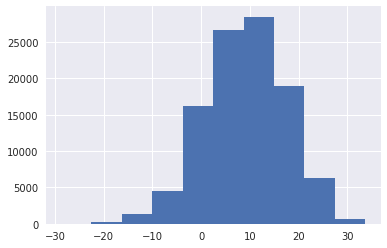

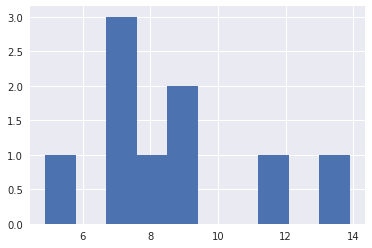

In [87]:
plt.hist(Y_test)
plt.show()
plt.hist(Y_test[test_säntis_july_15_00.index])
plt.show()

In [ ]:
influences_säntis_july_15_00 = tf_model.get_influence_on_test_loss(
    list(test_säntis_july_15_00.index), 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples

NameError: name 'influences_säntis_july_15_00' is not defined

In [ ]:
result_dictionary = {}
result_dictionary['santis_january_03_00'] = (influences_säntis_january_03_00, 'Säntis in January at 04:00', test_säntis_january_03_00.index[0])
result_dictionary['santis_january_15_00'] = (influences_säntis_january_15_00, 'Säntis in January at 16:00', test_säntis_january_15_00.index[0])
result_dictionary['santis_july_03_00'] = (influences_säntis_july_03_00, 'Säntis in July at 04:00', test_säntis_july_03_00.index[0])
result_dictionary['santis_july_15_00'] = (influences_säntis_july_15_00, 'Säntis in July at 16:00', test_säntis_july_15_00.index[0])
np.savez('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_santis_diurnal_seasonal_bucket_1_0', result_dictionary)

In [ ]:
for dict_item in result_dictionary.items():
    plotSummedInfluences(influences=dict_item[1][0], title=dict_item[1][1], test_idx=dict_item[1][2])

In [90]:
results_säntis_0_3 = np.load('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_santis_diurnal_seasonal_bucket_0_3.npz')

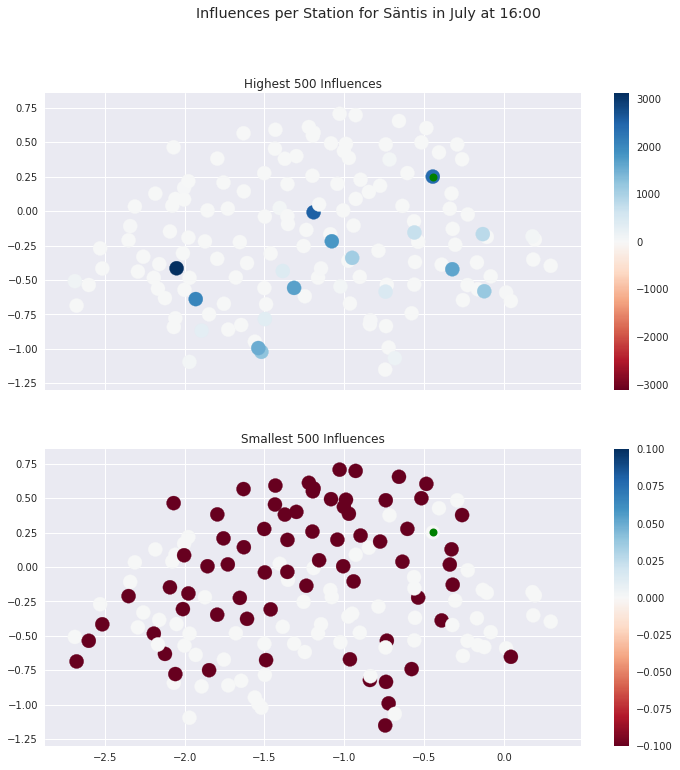

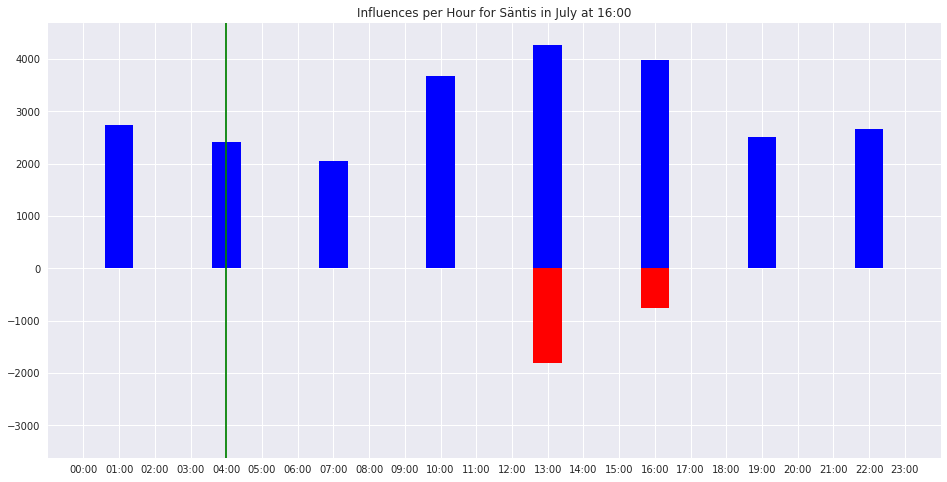

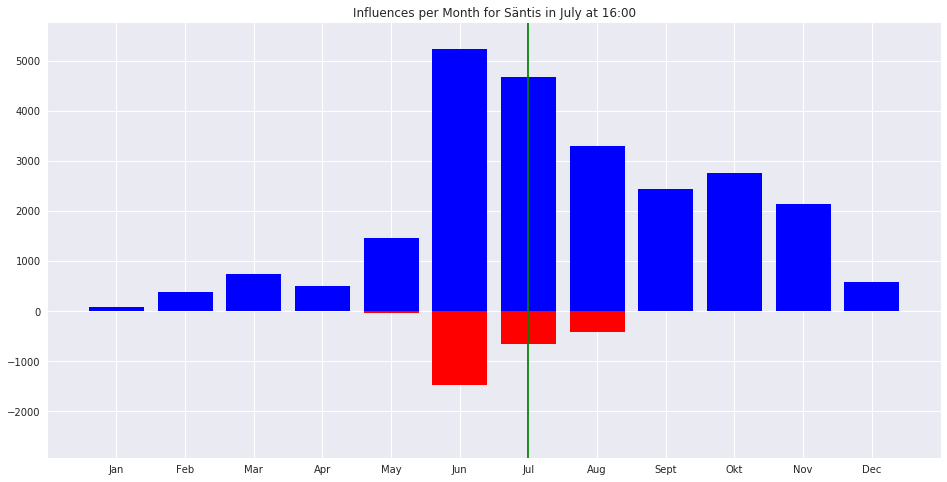

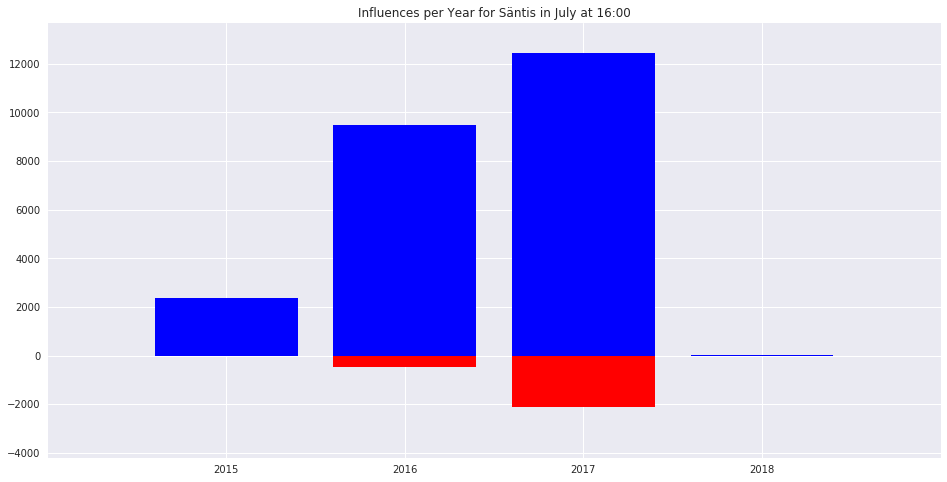

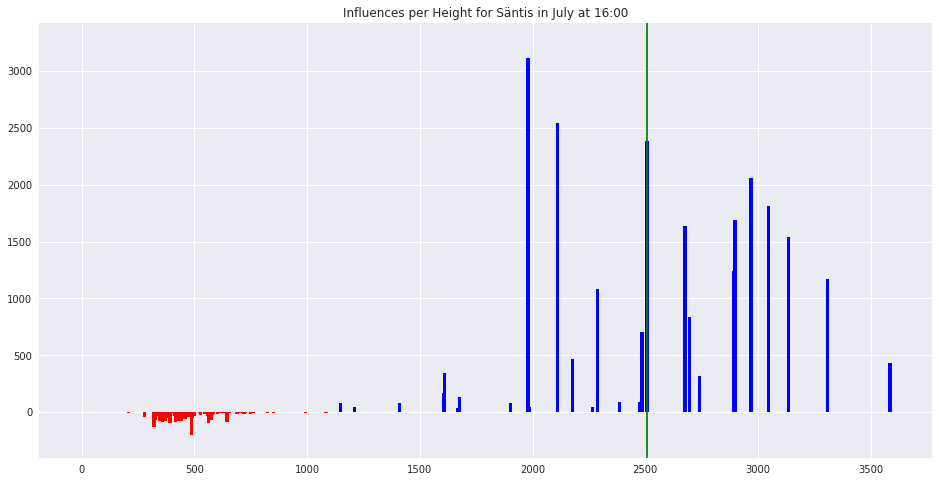

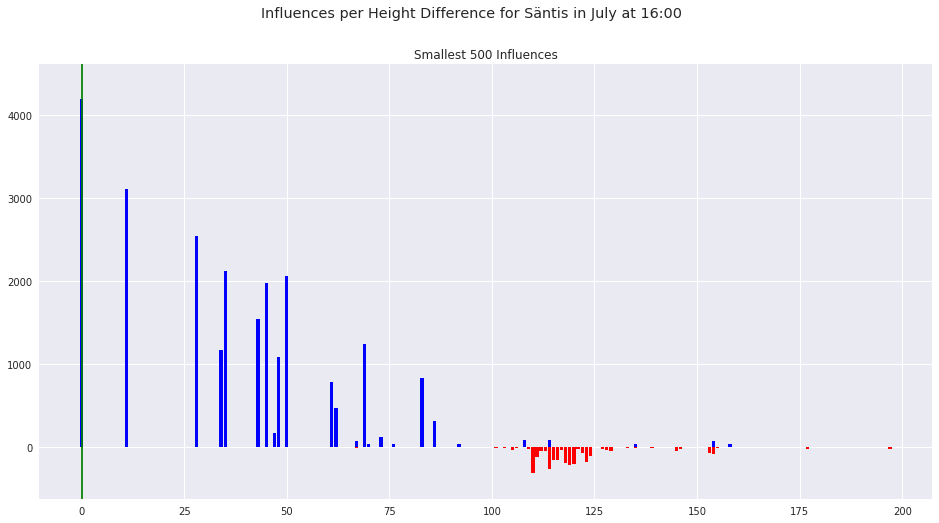

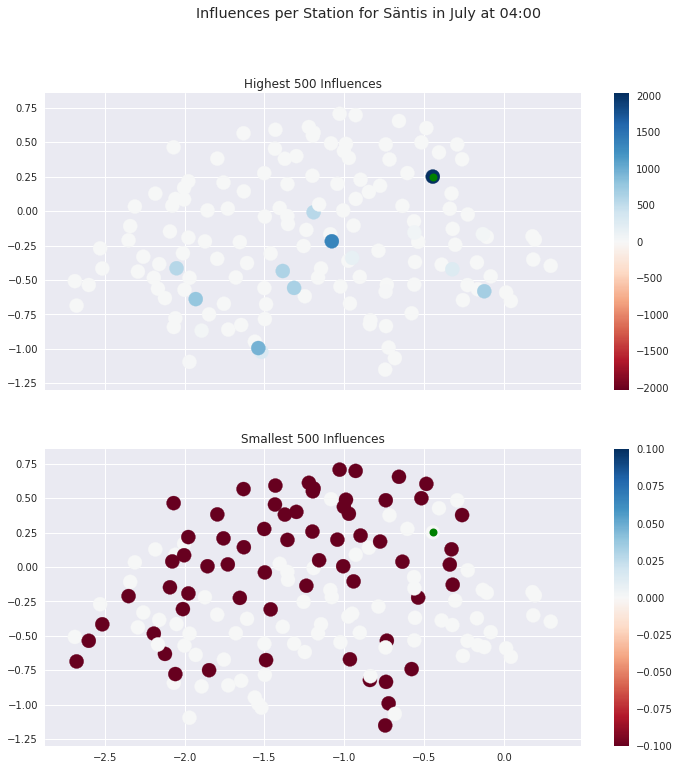

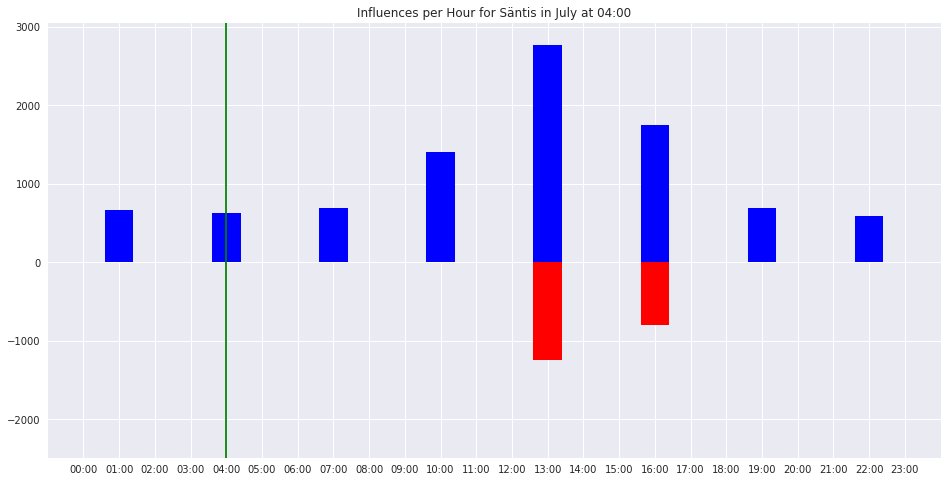

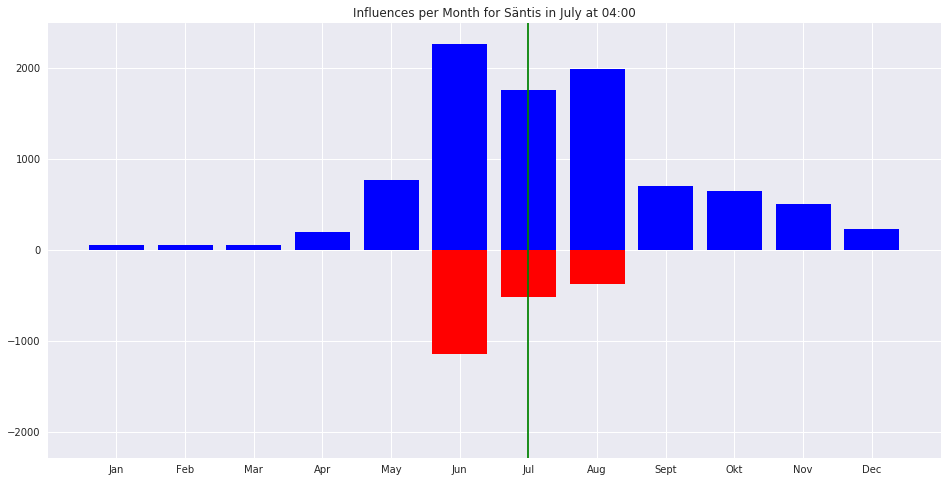

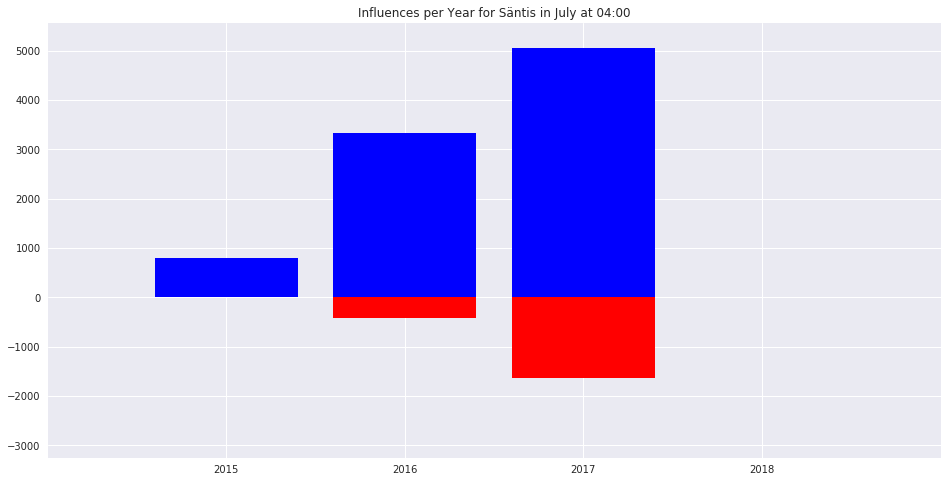

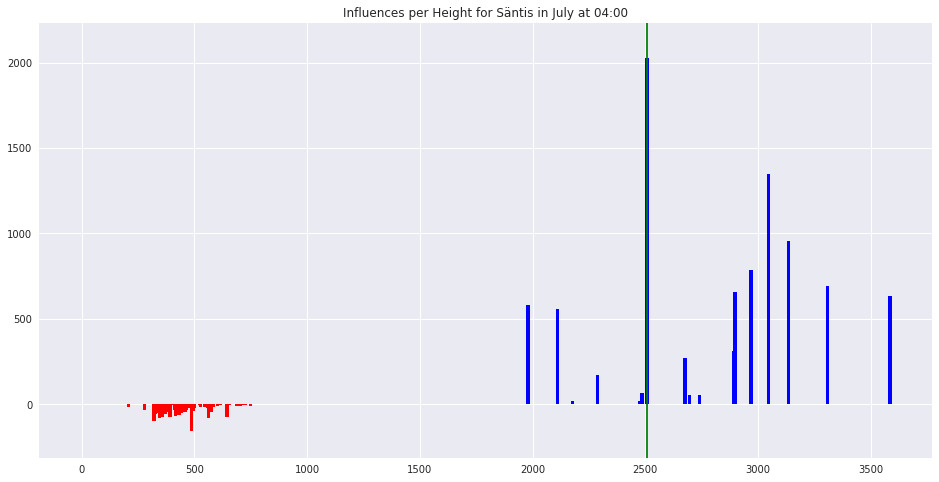

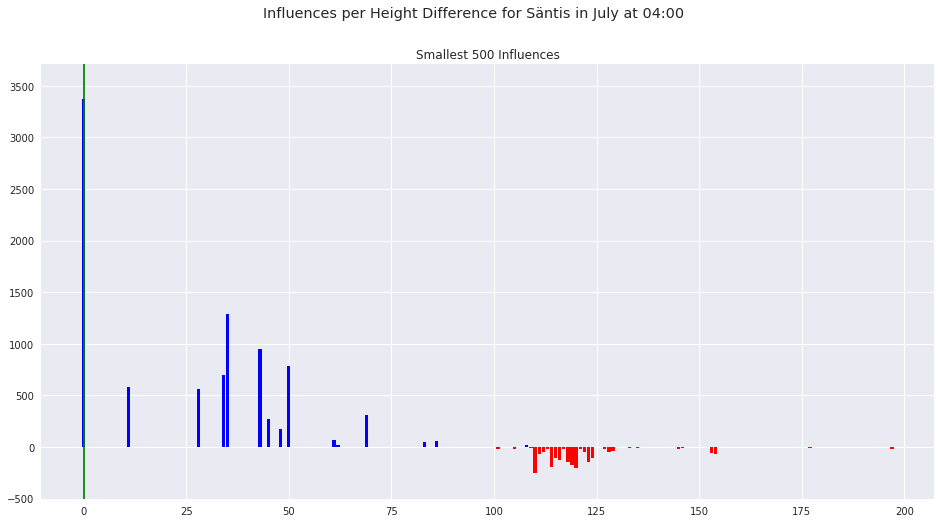

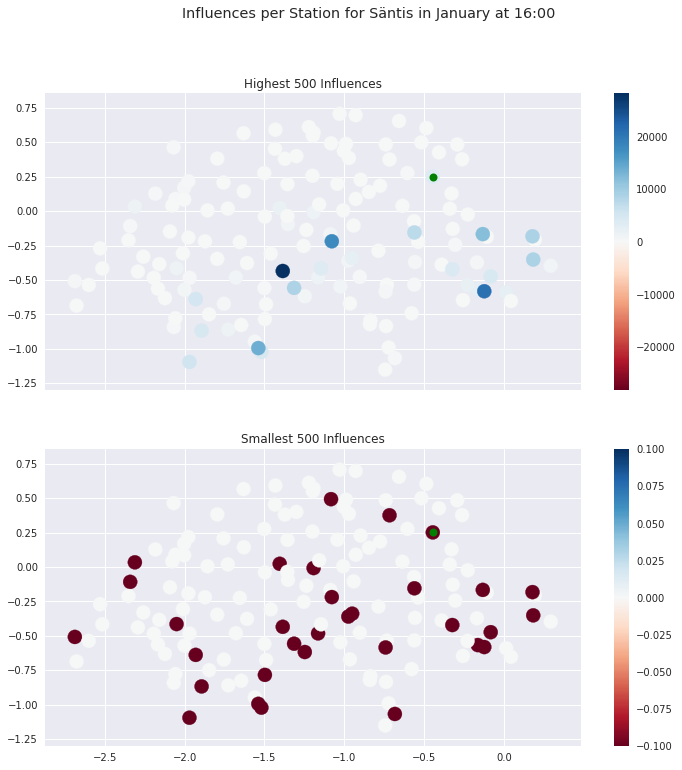

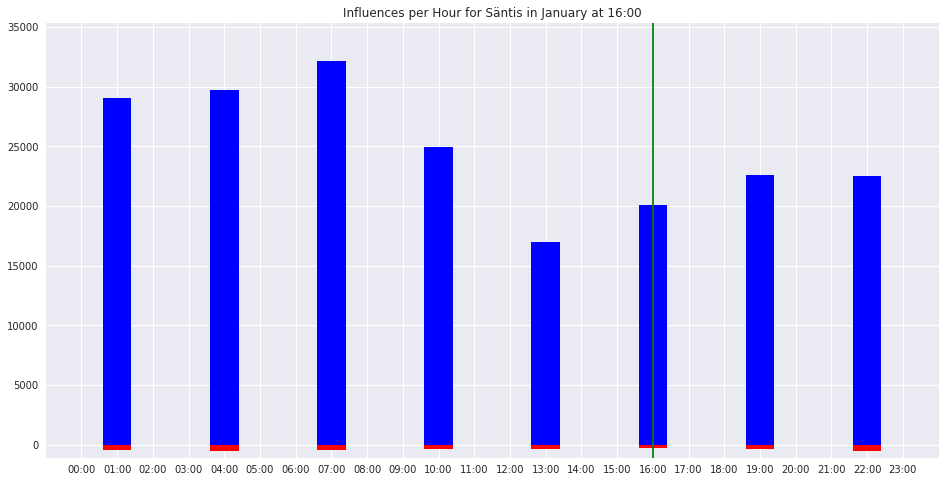

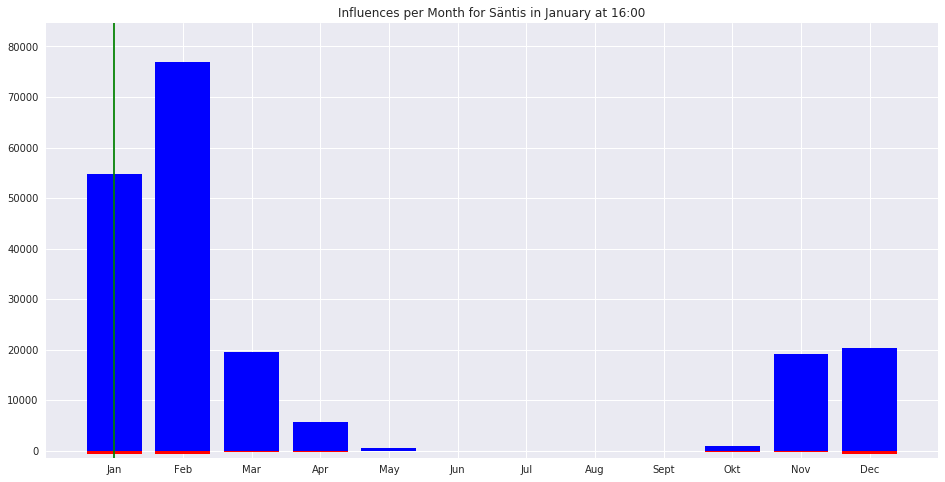

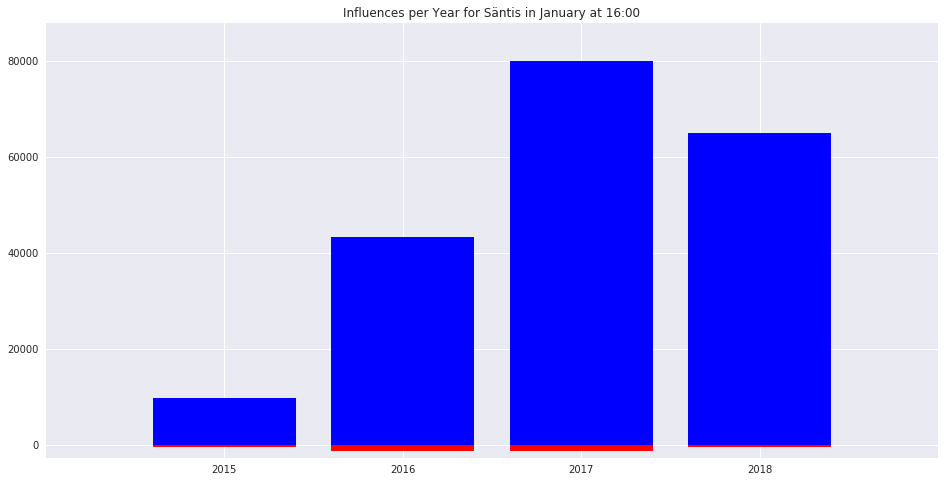

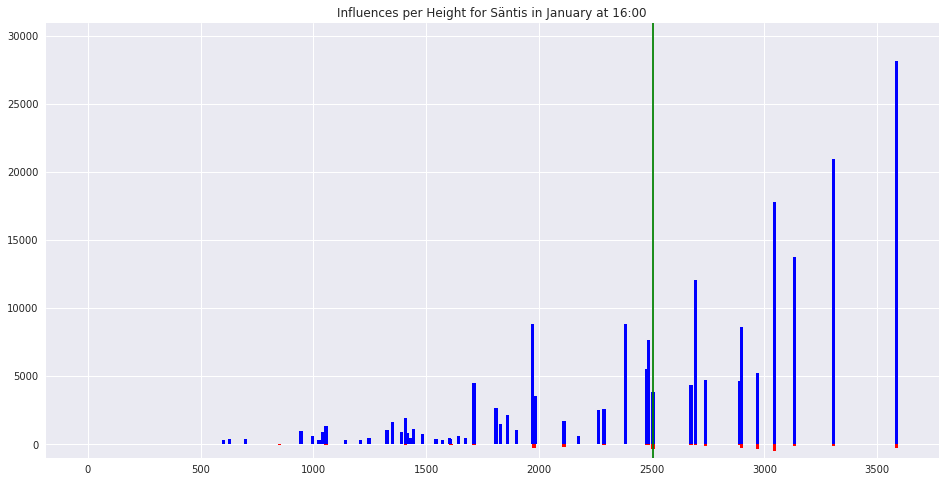

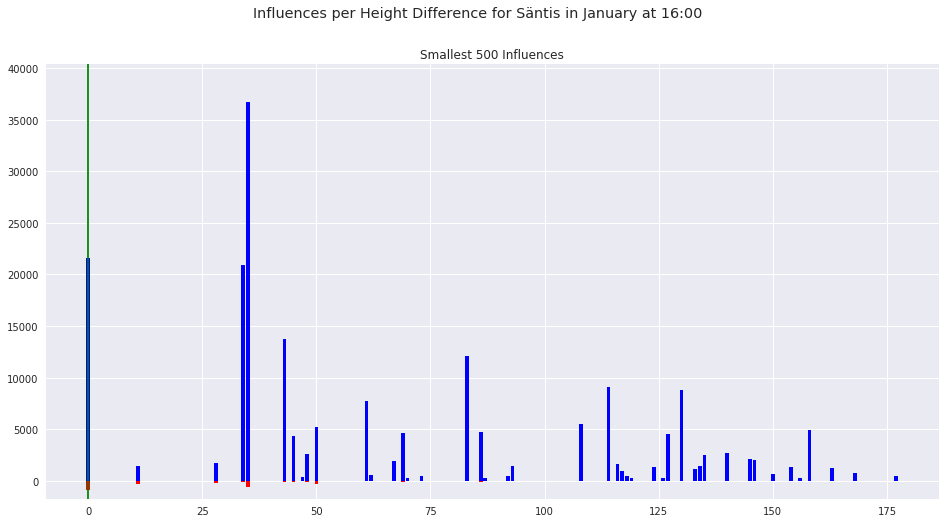

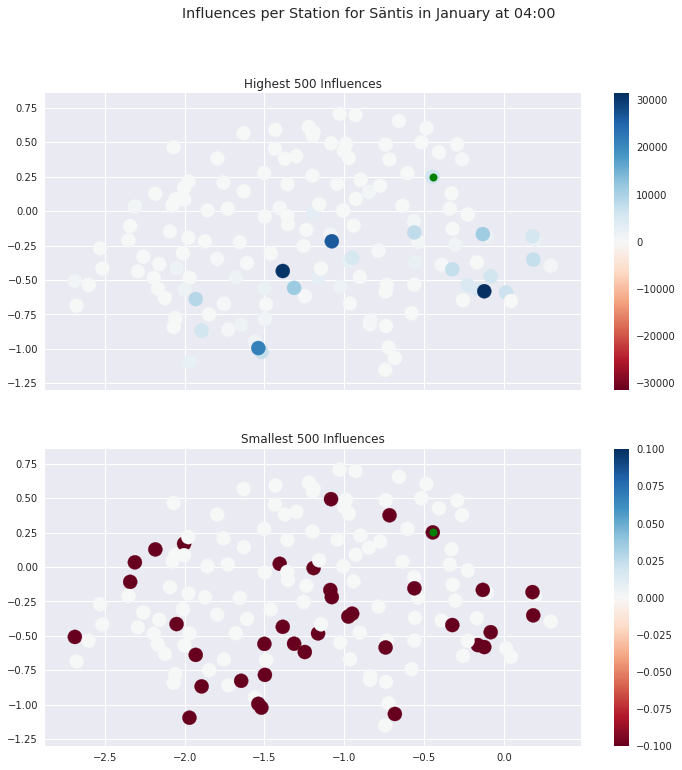

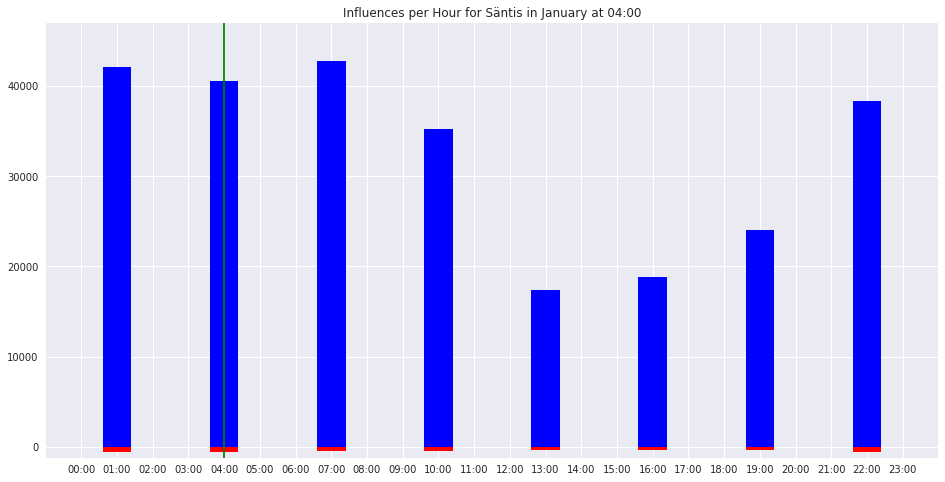

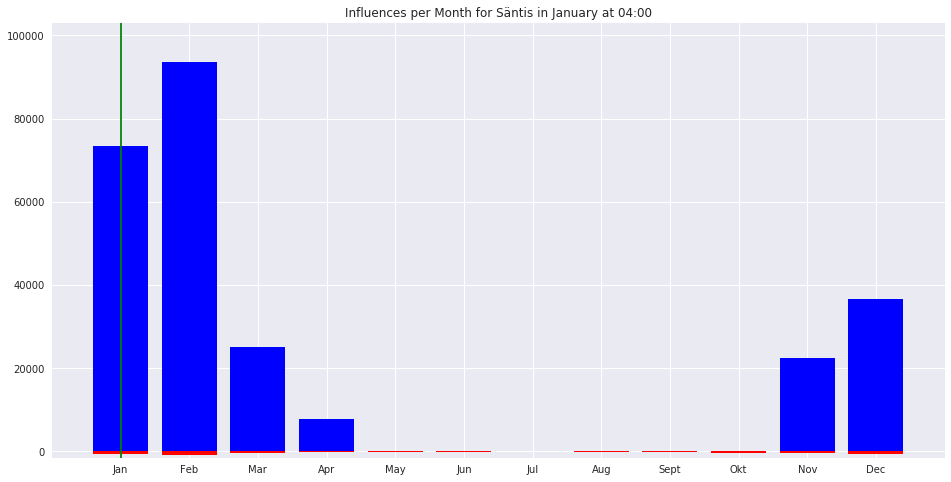

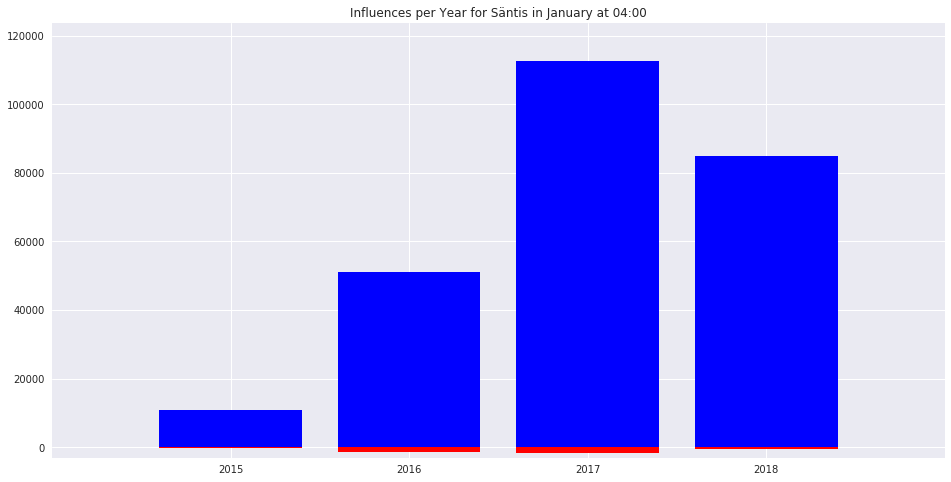

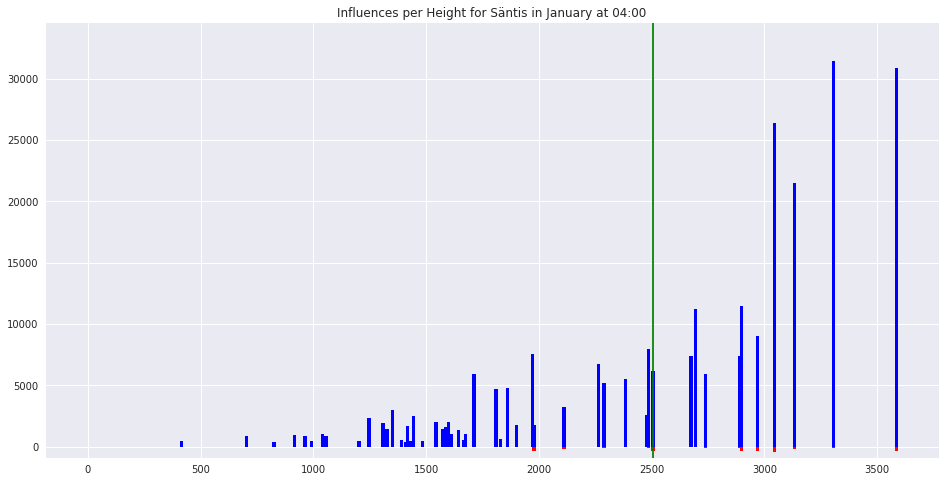

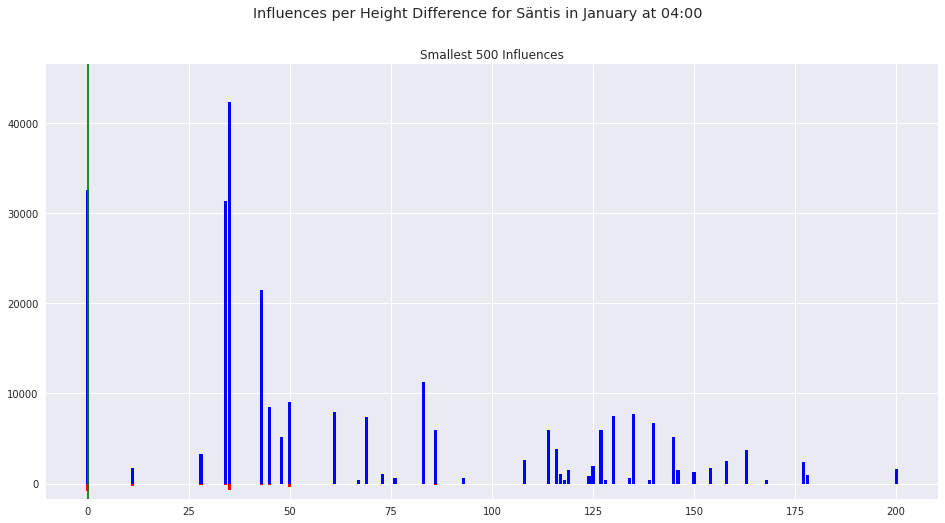

In [102]:
for dict_item in results_säntis_0_3['arr_0'].item().items():
    plotSummedInfluences(influences=dict_item[1][0]/, title=dict_item[1][1], test_idx=dict_item[1][2])

# Results for test points with labels between 25 and 50

### Only use labels between 25 and 50

In [34]:
middle_label_test_indices = [idx for idx, l in enumerate(lr_test.labels) if l >= 50 and l <= 100]
middle_label_train_indices = [idx for idx, l in enumerate(lr_train.labels) if l >= 50 and l <= 100]

In [17]:
influences_middle_labels_test_data = tf_model.get_influence_on_test_loss(
    middle_label_test_indices, 
    middle_label_train_indices,
    force_refresh=True)

Norm of test gradient: 0.6946179
Function value: -4.378971099853516
Split function value: 4.378852844238281, -8.757824
Predicted loss diff on train_idx 5: -5.395578894298333e-07
Function value: -4.694569110870361
Split function value: 4.233174800872803, -8.927744
Predicted loss diff on train_idx 5: -5.574951329881616e-07
Function value: -4.724637508392334
Split function value: 4.618109226226807, -9.342747
Predicted loss diff on train_idx 5: -7.485001991630558e-07
Function value: -4.734793663024902
Split function value: 4.676486015319824, -9.41128
Predicted loss diff on train_idx 5: -6.93863226332346e-07
Function value: -4.735583305358887
Split function value: 4.721848487854004, -9.457432
Predicted loss diff on train_idx 5: -6.973449314605095e-07
Function value: -4.735778331756592
Split function value: 4.736546039581299, -9.472324
Predicted loss diff on train_idx 5: -6.988778097643087e-07
Function value: -4.73578405380249
Split function value: 4.735546588897705, -9.471331
Predicted loss

Multiplying by 81404 train examples took 41.62389373779297 sec


In [18]:
np.savez('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_middle_label_bucket_1_0', influences_middle_labels_test_data)

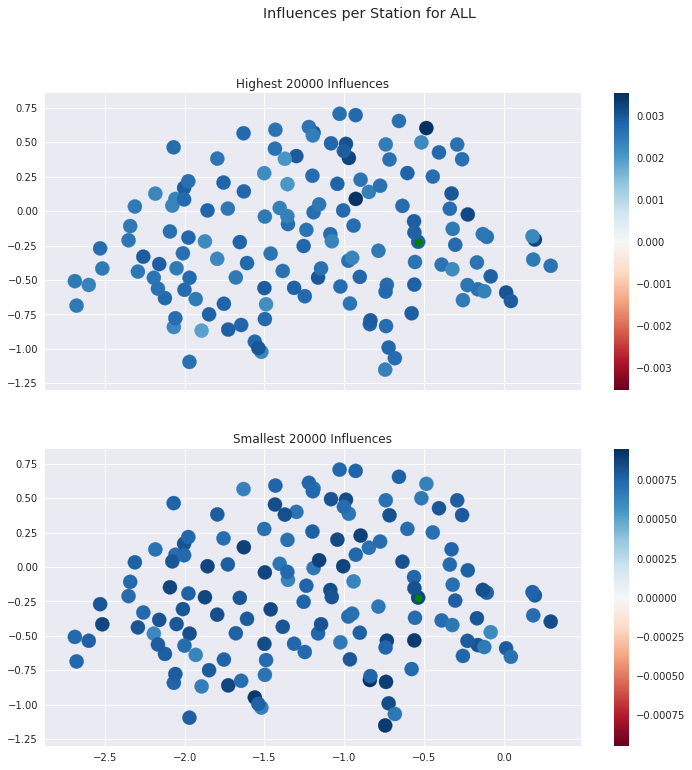

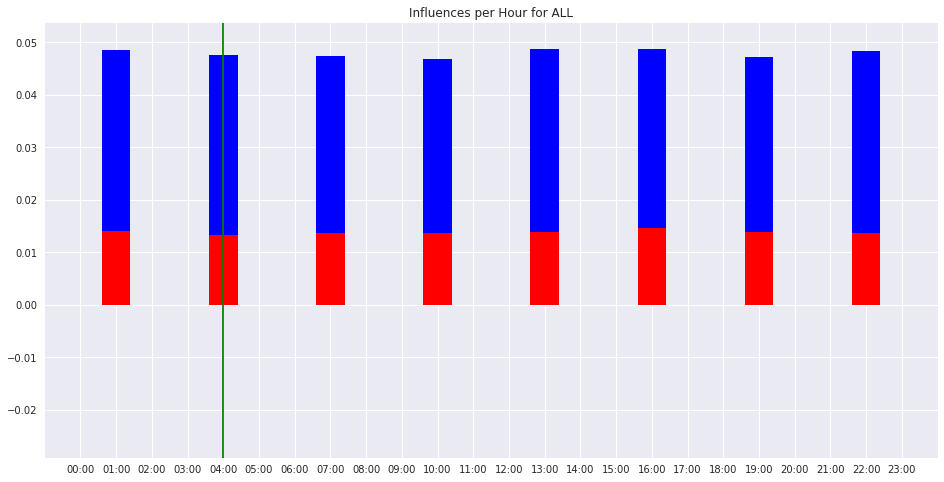

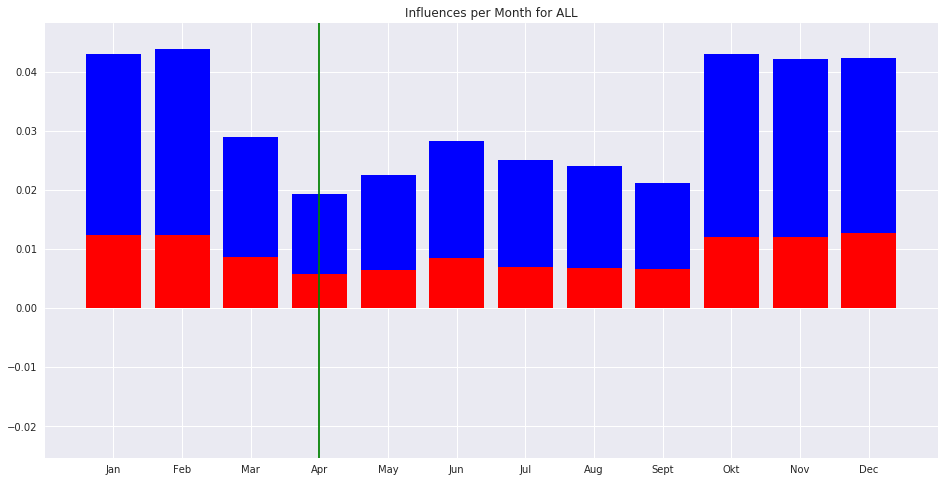

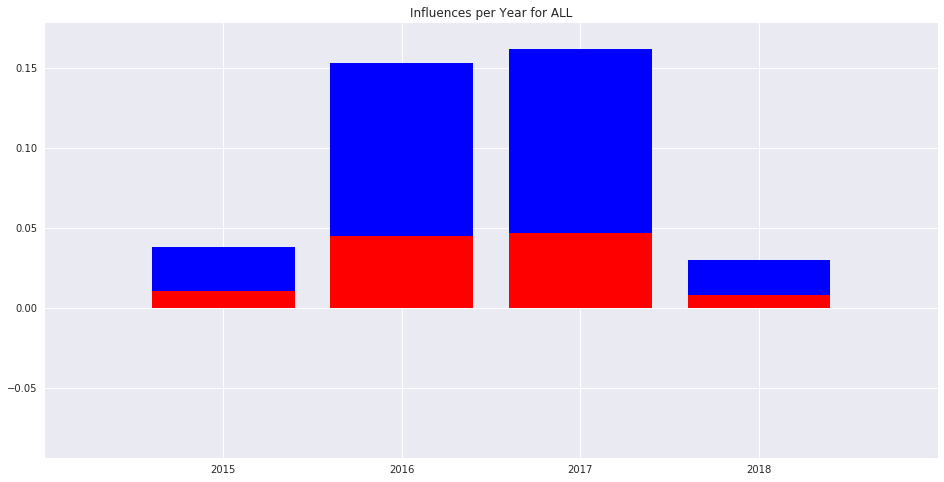

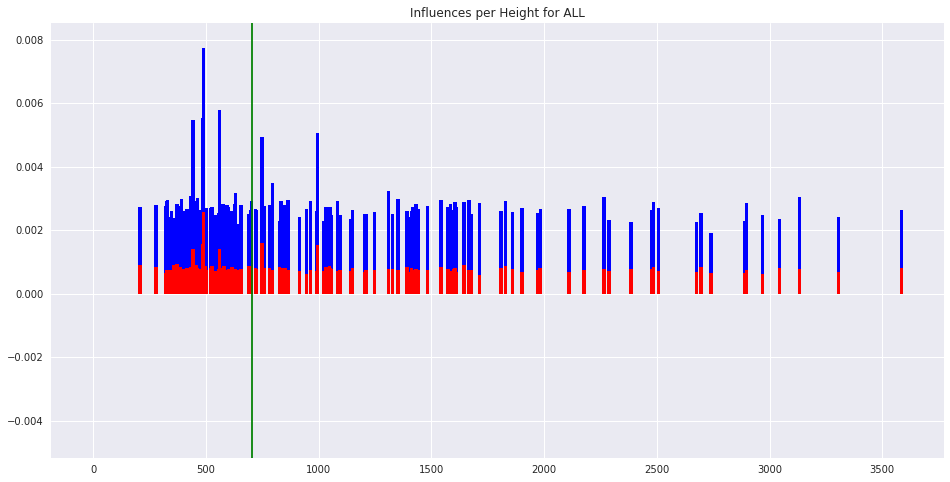

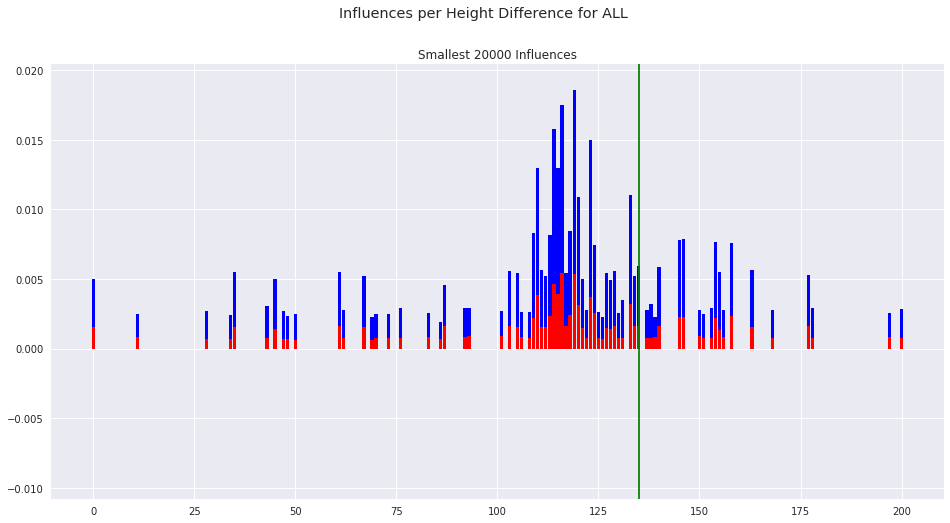

In [19]:
plotSummedInfluences(influences=influences_middle_labels_test_data, title='ALL')

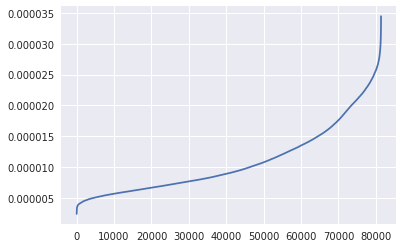

In [35]:
sorted_indices = np.argsort(influences_middle_labels_test_data)
plt.plot(influences_middle_labels_test_data[sorted_indices])
plt.show()

# Analyze model predictions

In [57]:
predicted_class_probabilities = tf_model.sklearn_model.predict_proba(X_test[middle_label_test_indices])

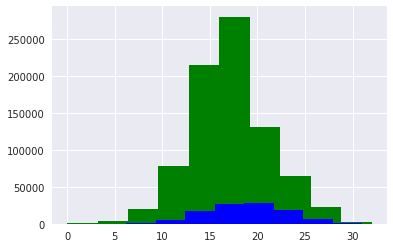

In [59]:
plt.hist(lr_train.labels, color='green')
plt.hist(lr_test.labels, color='blue')
plt.show()

In [25]:
predicted_class_probabilities[2]

array([0.00074986, 0.00075376, 0.00075245, 0.00074823, 0.00077472,
       0.00078769, 0.00078662, 0.00078402, 0.0008059 , 0.00083096,
       0.0008212 , 0.00083415, 0.00084743, 0.00088343, 0.00088221,
       0.00092569, 0.00096095, 0.00098854, 0.001002  , 0.00105587,
       0.00115925, 0.00123002, 0.0013217 , 0.00143908, 0.00152344,
       0.00153842, 0.00189777, 0.00184871, 0.00236289, 0.0024294 ,
       0.00276806, 0.00330764, 0.00354837, 0.00387704, 0.00446008,
       0.00519668, 0.00587061, 0.00639088, 0.00782643, 0.00918697,
       0.01015016, 0.0112924 , 0.01316389, 0.01425124, 0.01665437,
       0.01872171, 0.02099168, 0.02306556, 0.02475464, 0.02626423,
       0.02867747, 0.03176257, 0.03320813, 0.03545891, 0.03812612,
       0.04057244, 0.04415788, 0.0448188 , 0.04400991, 0.04434091,
       0.04333847, 0.03581323, 0.03183242, 0.02767873, 0.02387593,
       0.02613156, 0.01707696, 0.01456794, 0.011841  , 0.01024718,
       0.00848486, 0.00718269, 0.00600755, 0.00523712, 0.00427

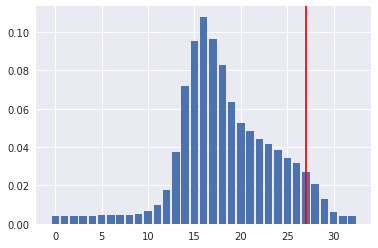

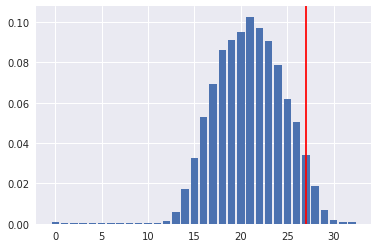

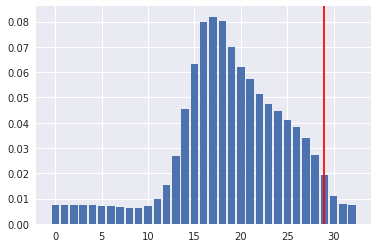

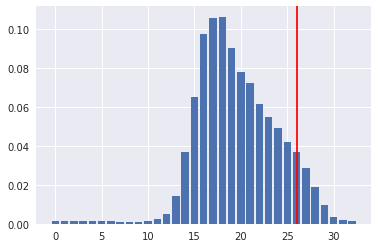

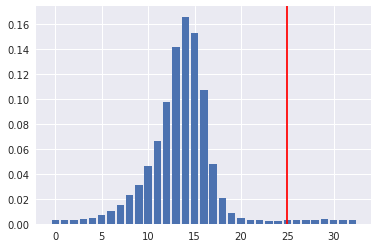

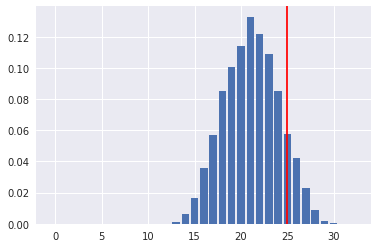

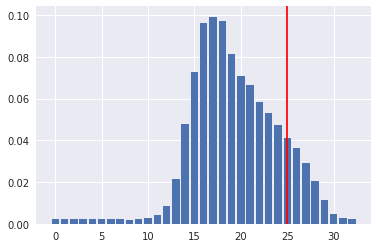

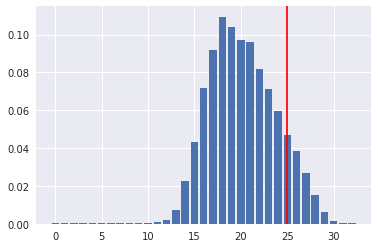

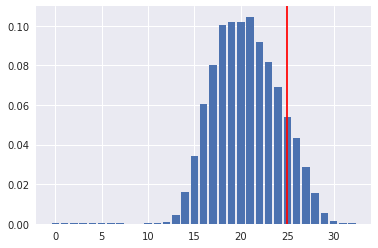

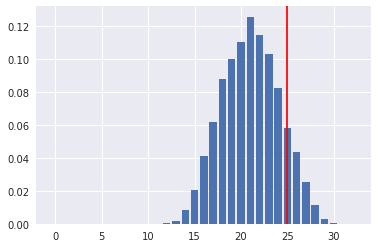

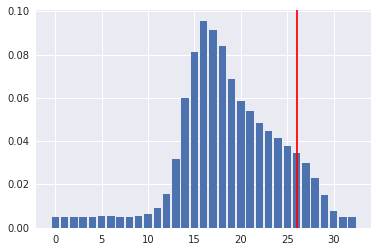

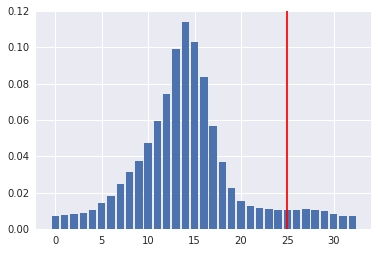

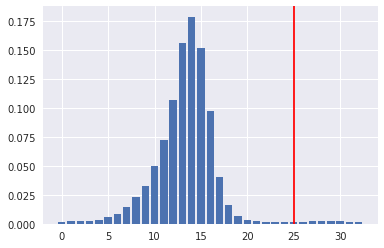

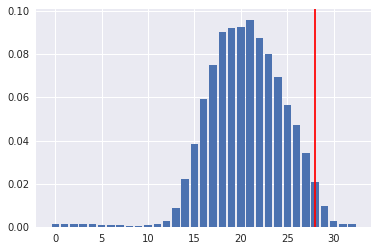

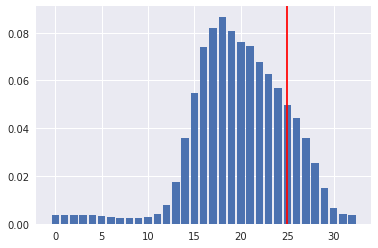

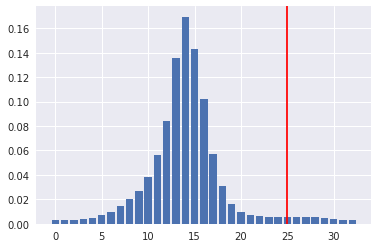

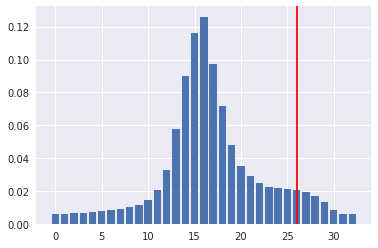

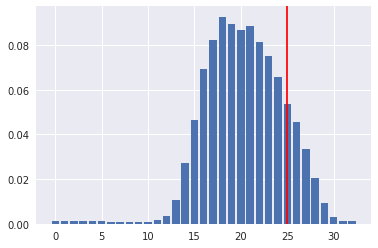

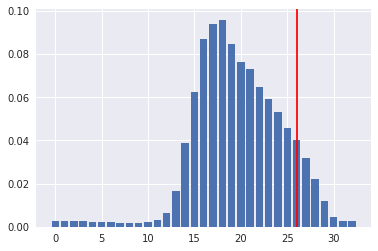

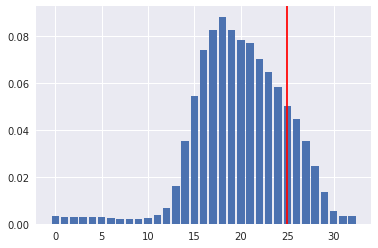

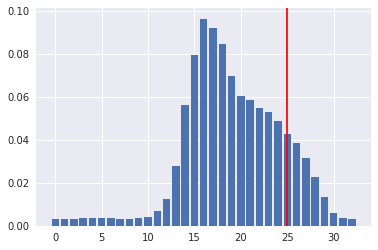

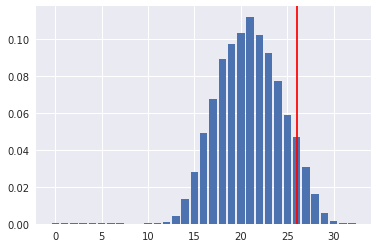

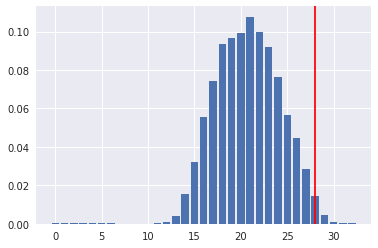

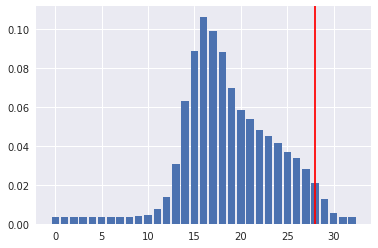

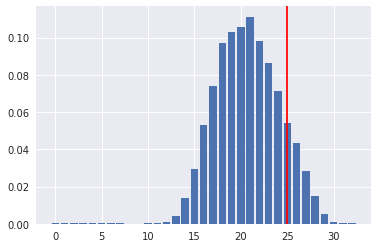

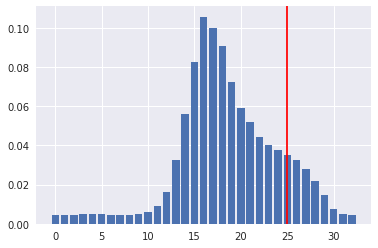

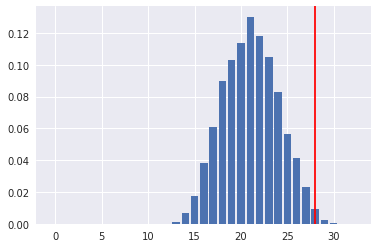

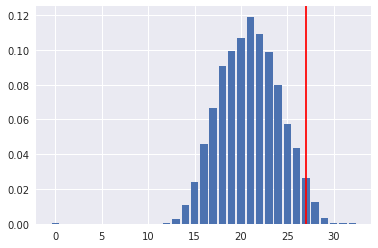

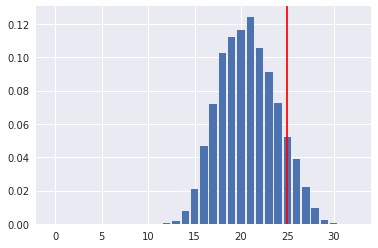

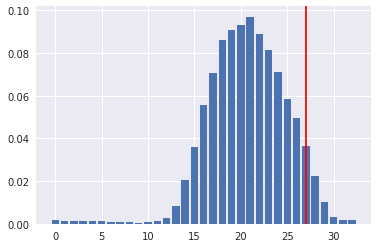

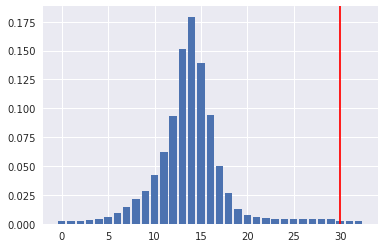

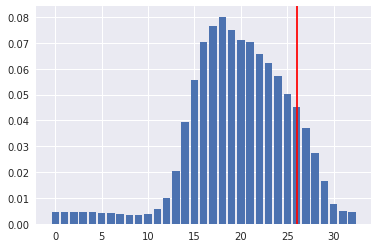

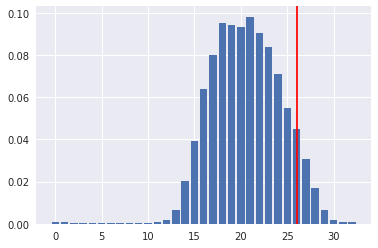

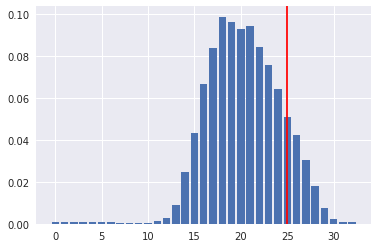

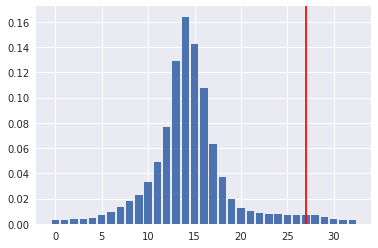

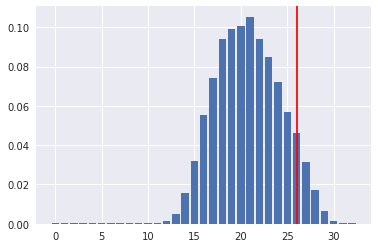

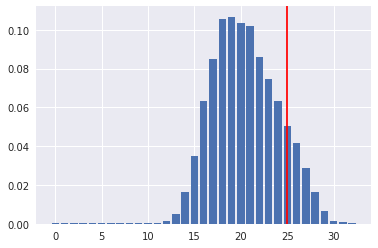

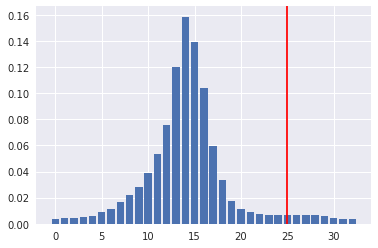

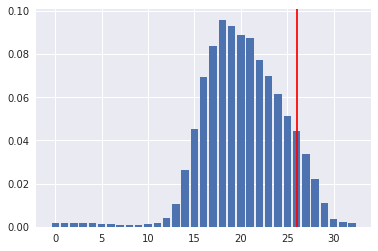

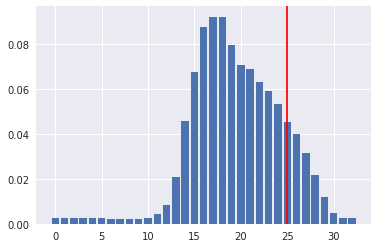

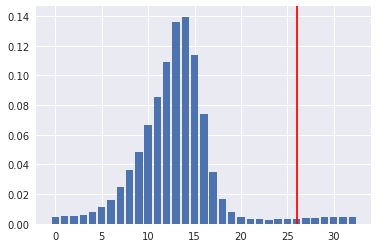

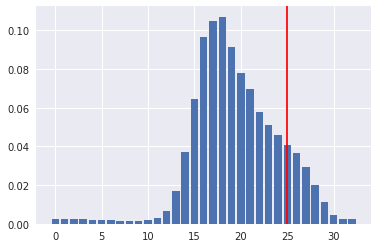

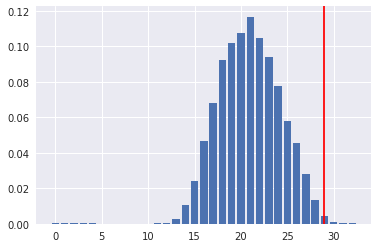

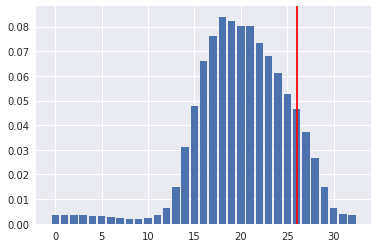

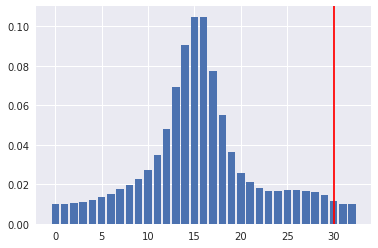

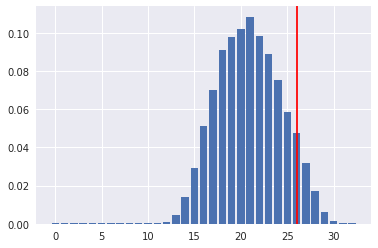

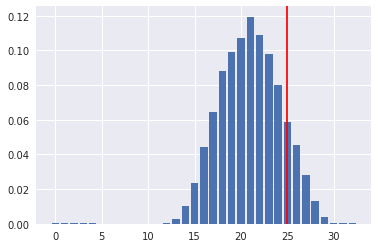

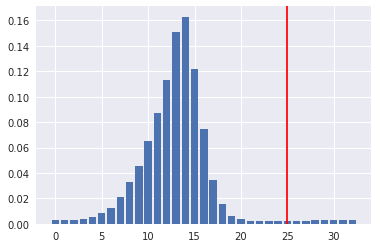

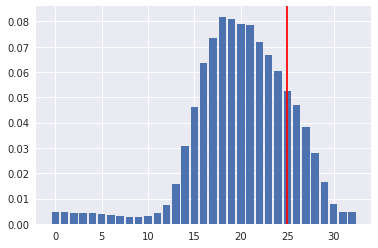

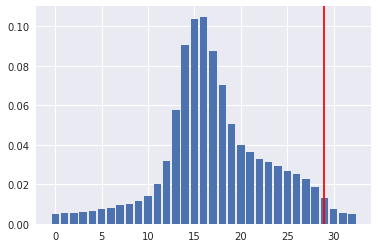

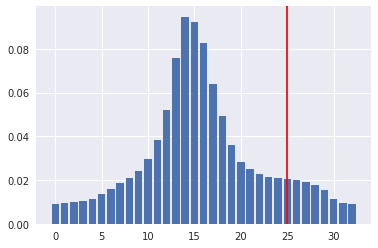

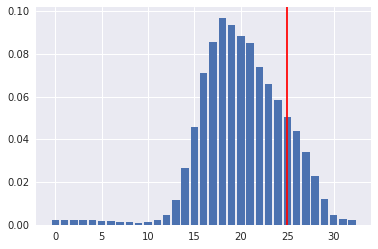

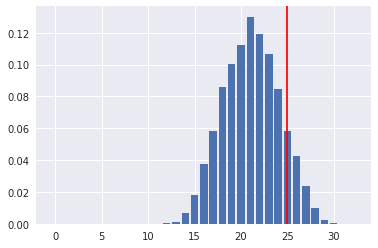

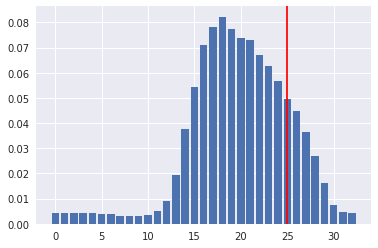

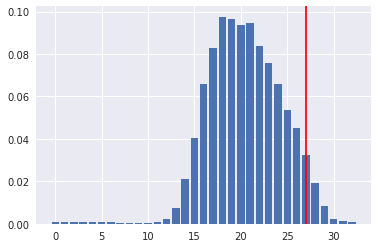

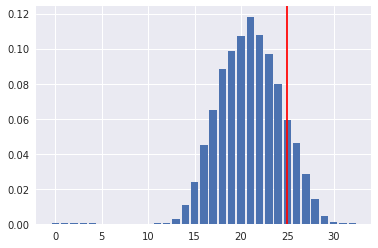

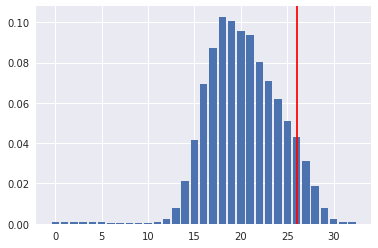

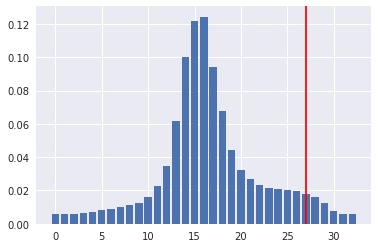

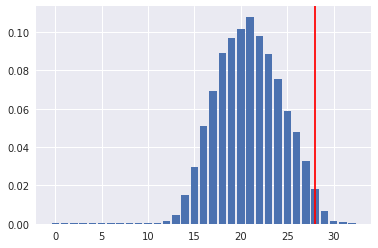

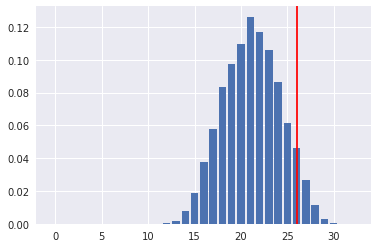

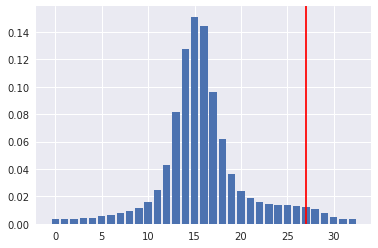

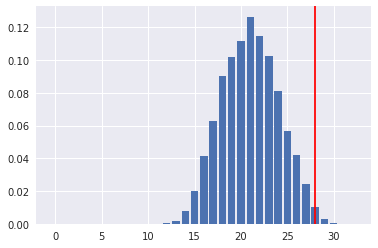

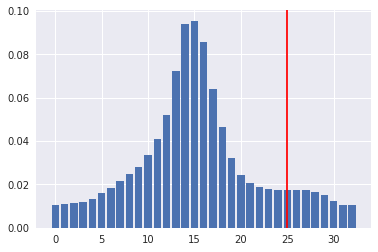

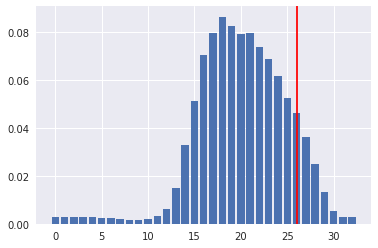

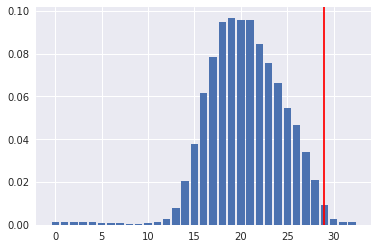

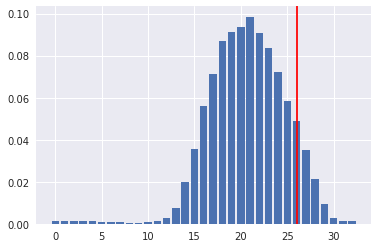

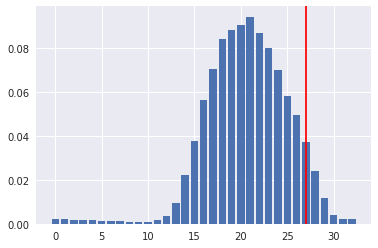

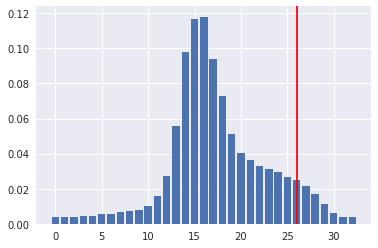

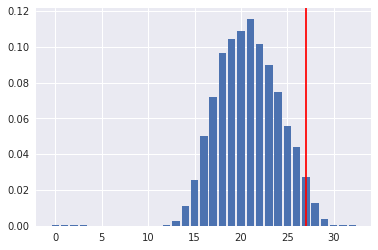

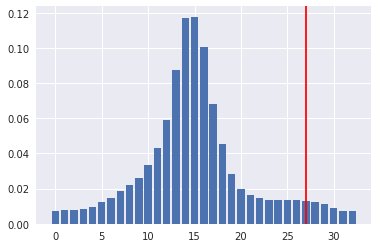

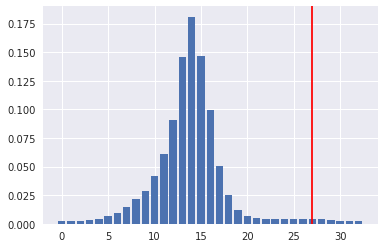

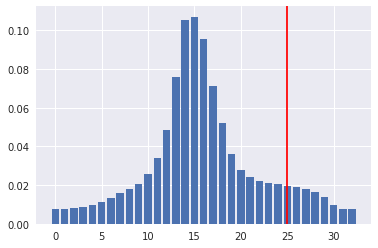

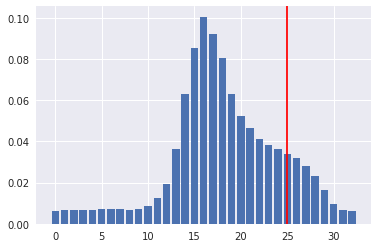

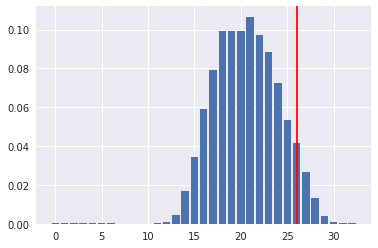

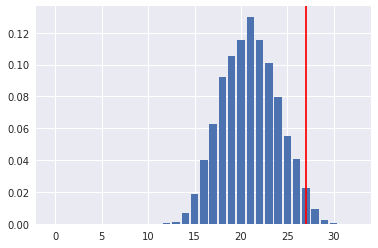

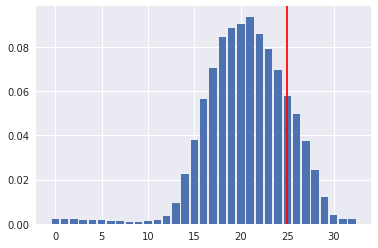

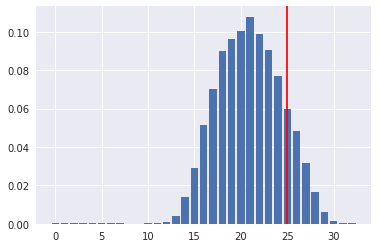

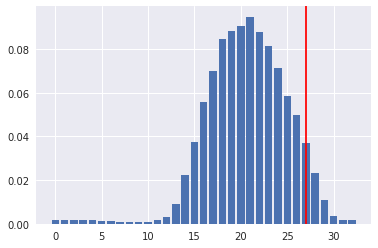

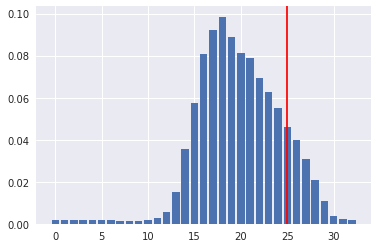

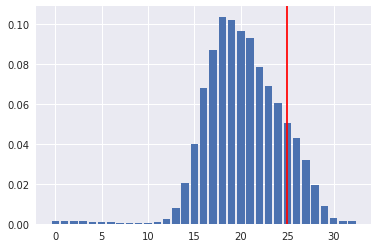

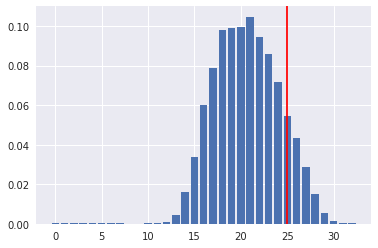

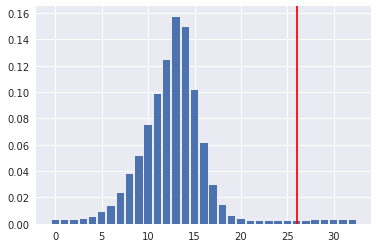

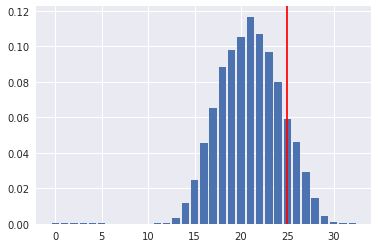

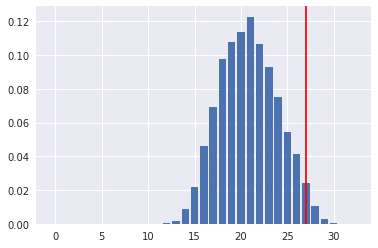

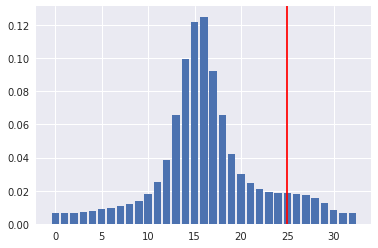

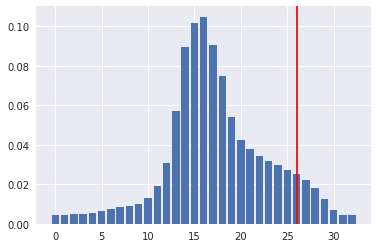

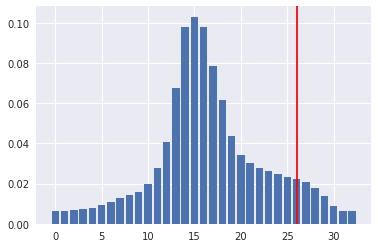

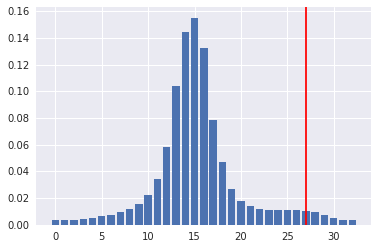

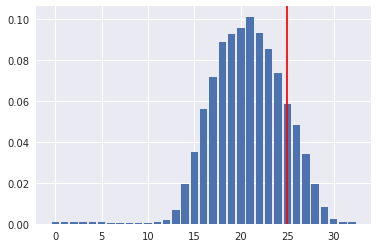

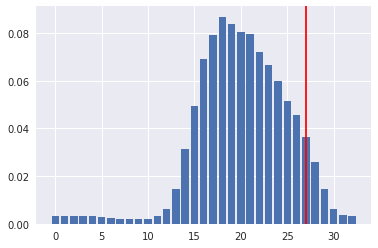

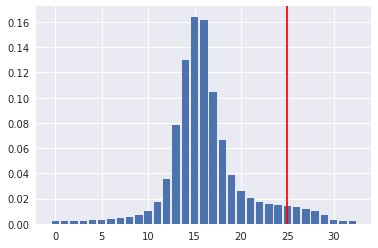

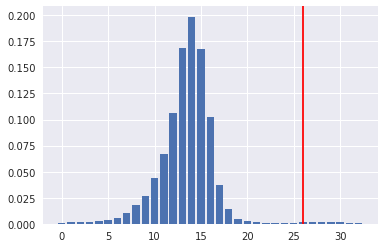

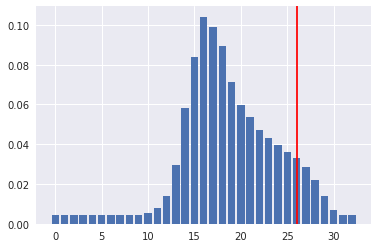

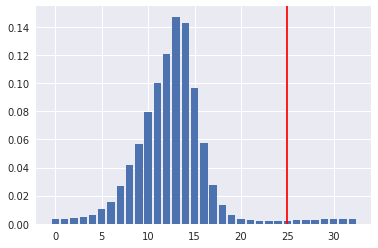

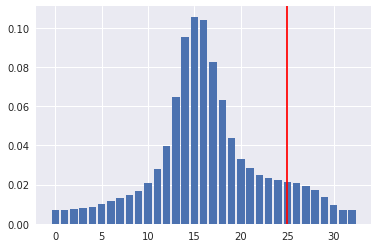

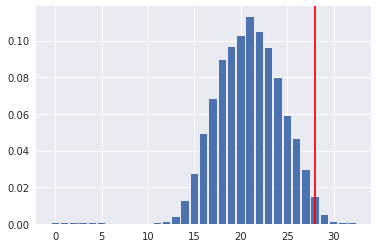

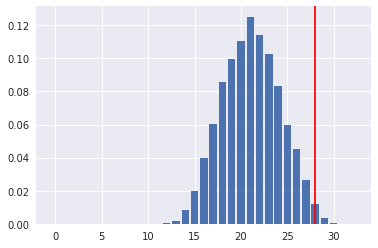

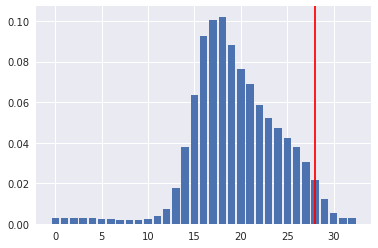

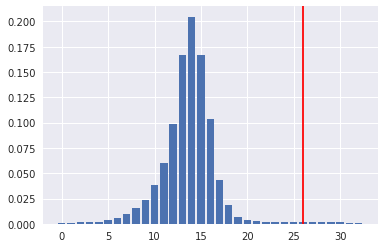

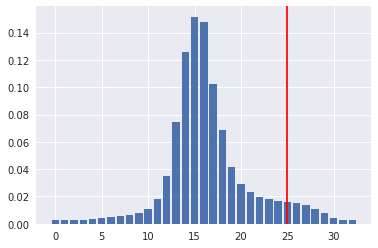

In [60]:
high_labels_indices = [idx for idx, l in enumerate(test_temp_bucket_index) if l >= 25]
low_labels_indices = [idx for idx, l in enumerate(test_temp_bucket_index) if l <=10]
for i in high_labels_indices[:100]:
    plt.bar(np.arange(len(predicted_class_probabilities[i])), predicted_class_probabilities[i])
    plt.axvline(test_temp_bucket_index[i], color='red')
    plt.show()

In [ ]:
plt.hist(test_temp_bucket_index)
plt.show()

## RMSE with linear regression

In [62]:
linreg_model = LinearRegression(normalize=False, copy_X=True, n_jobs=16).fit(X_train, Y_train)

In [63]:
prediction = linreg_model.predict(X_test)

In [65]:
np.sqrt(np.nanmean(np.square(prediction - Y_test)))

1.2839238064913692

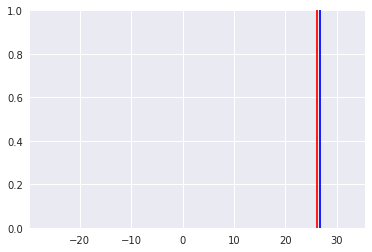

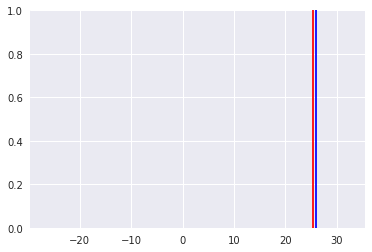

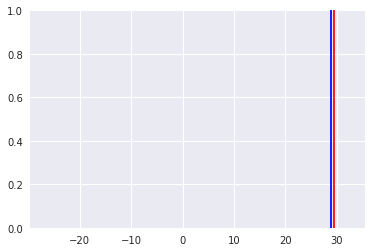

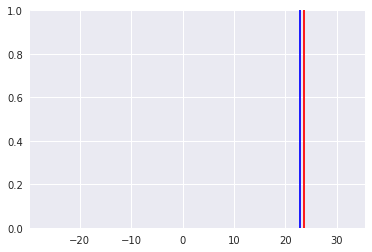

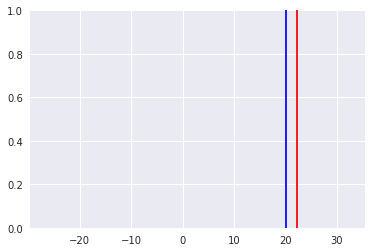

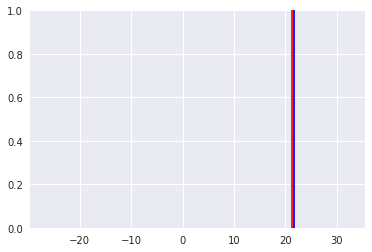

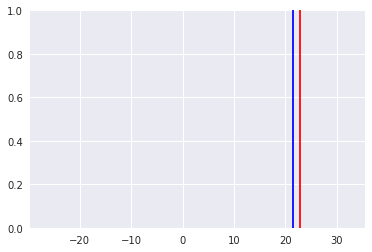

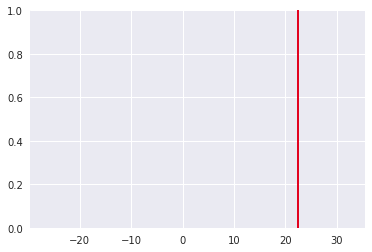

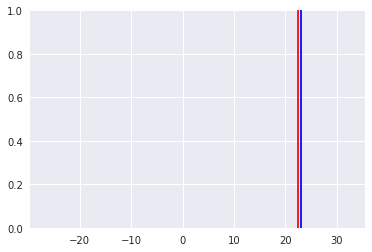

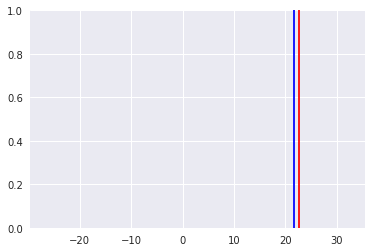

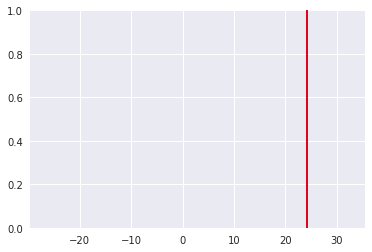

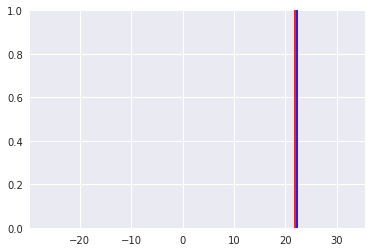

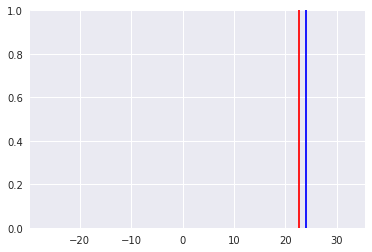

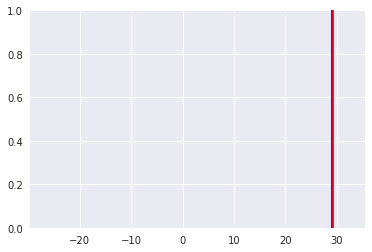

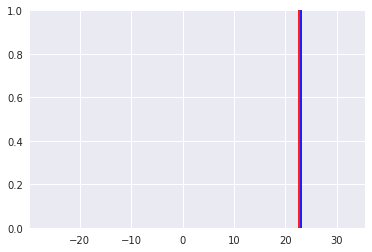

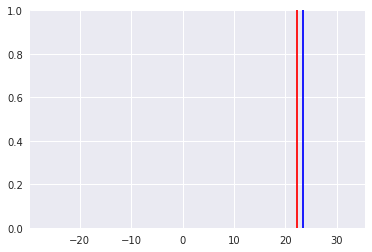

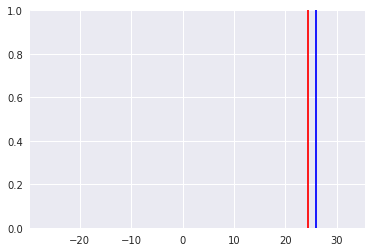

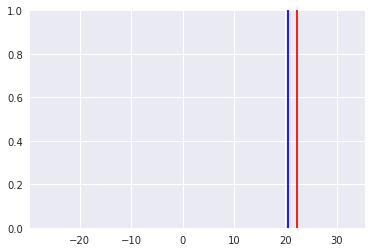

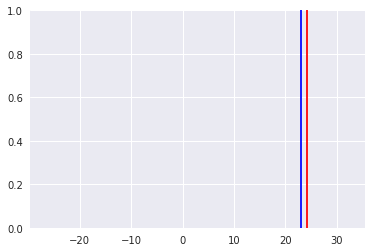

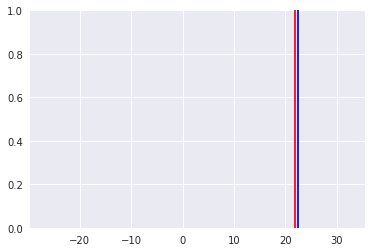

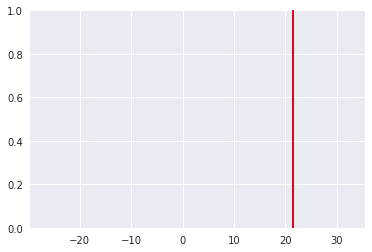

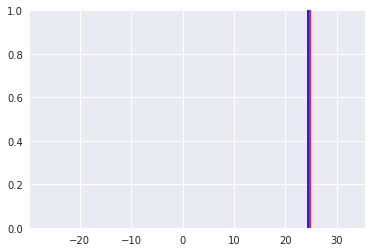

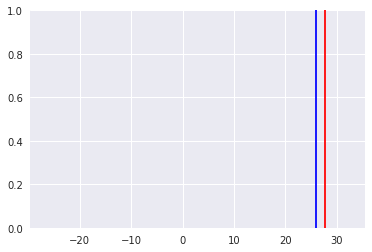

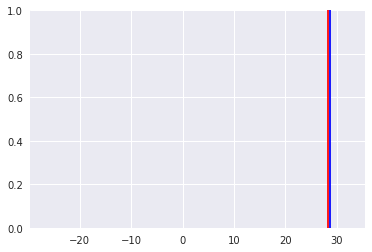

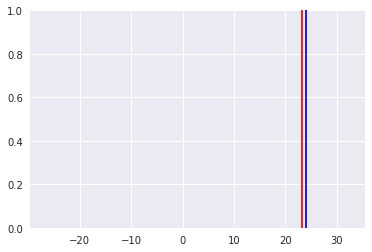

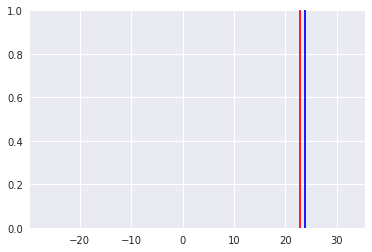

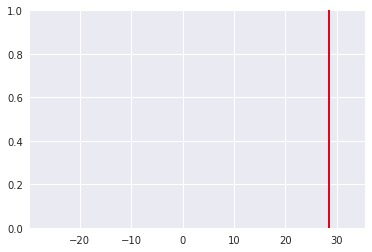

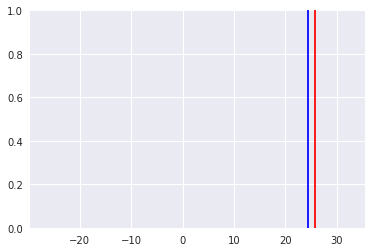

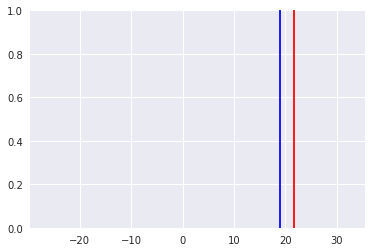

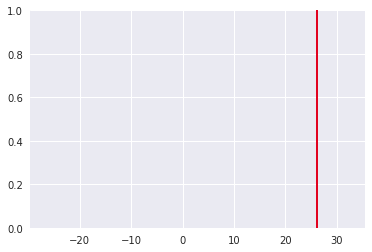

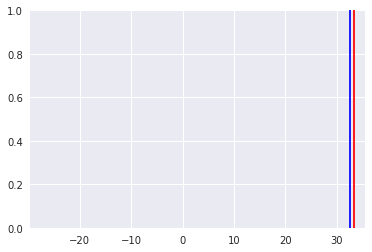

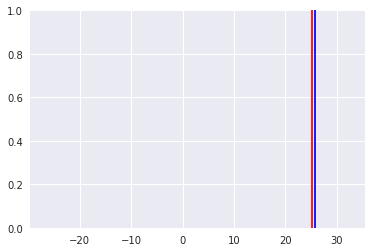

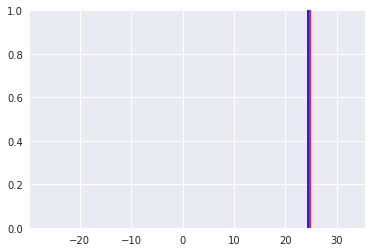

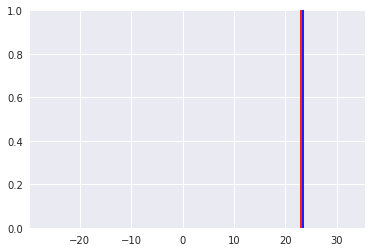

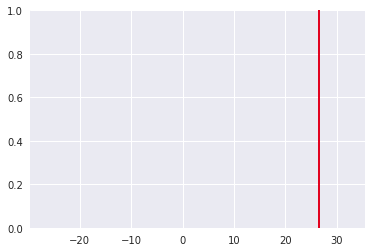

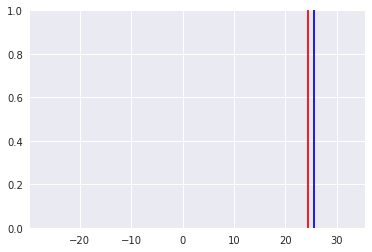

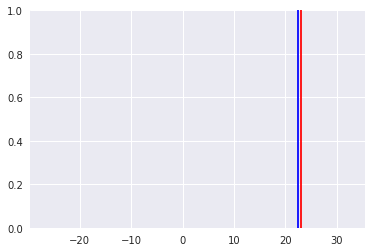

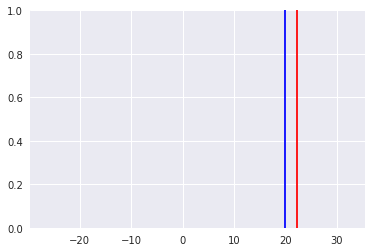

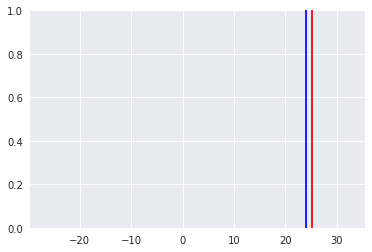

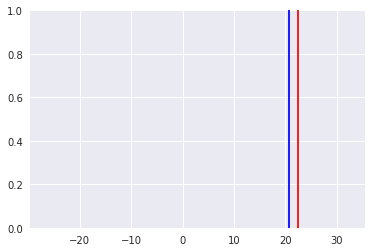

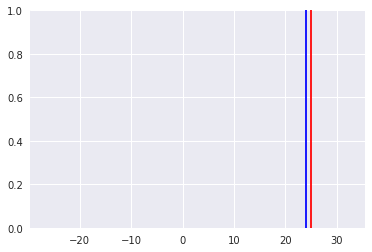

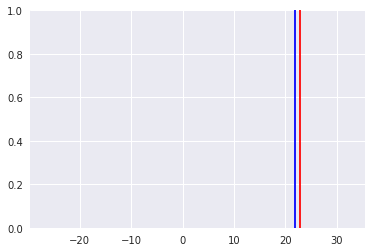

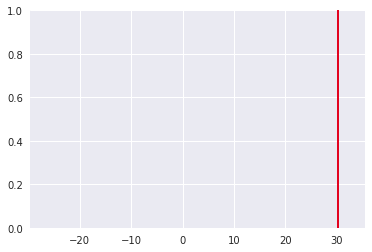

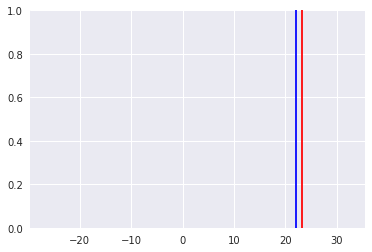

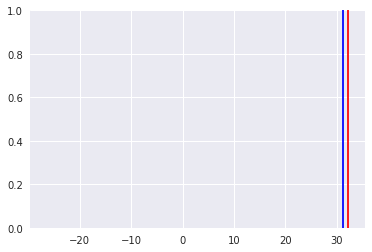

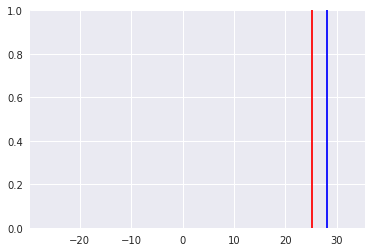

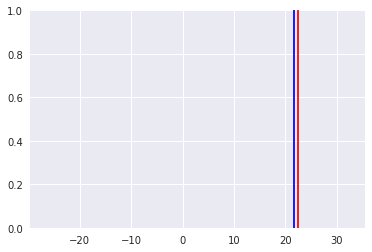

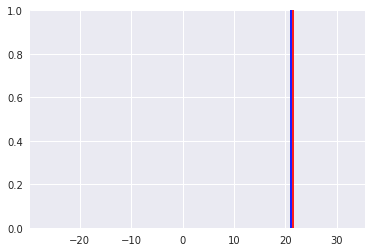

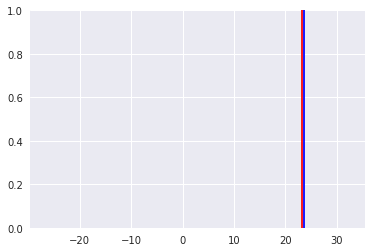

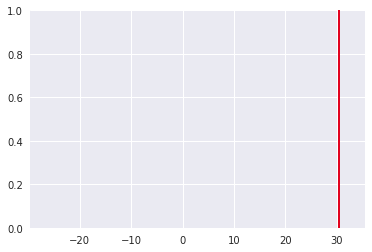

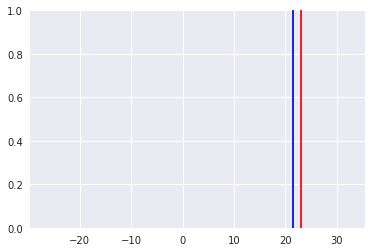

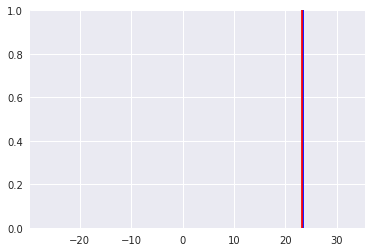

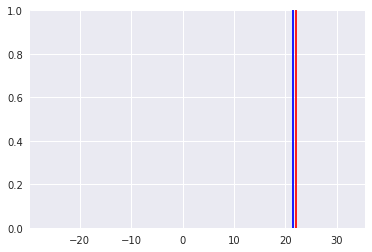

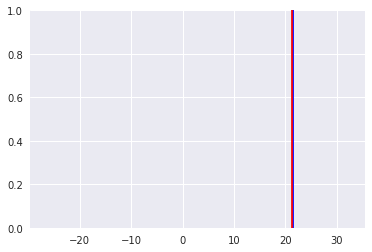

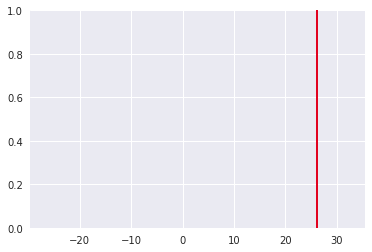

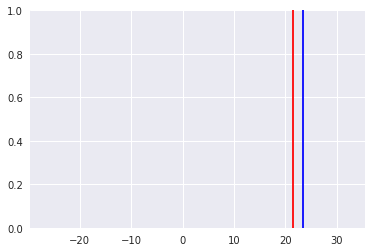

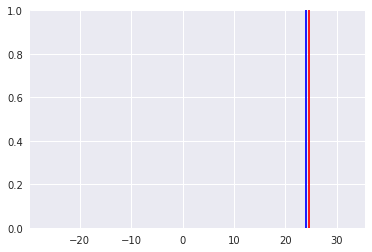

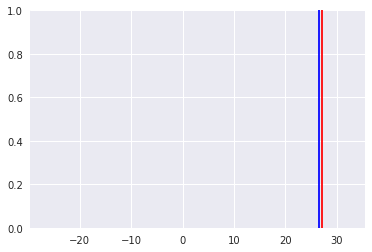

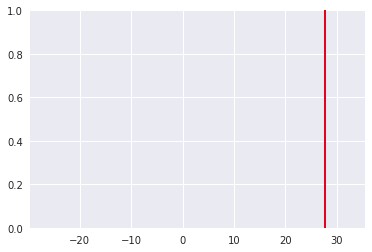

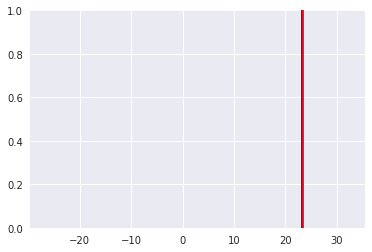

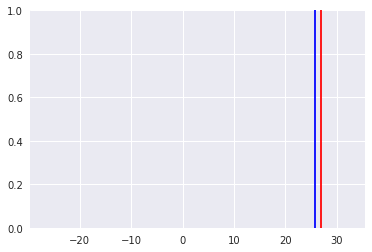

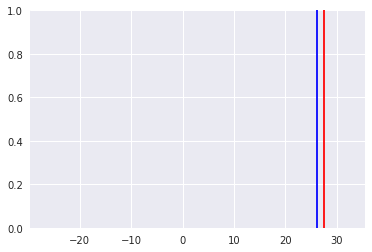

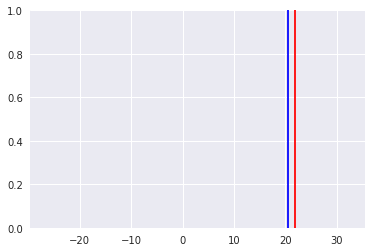

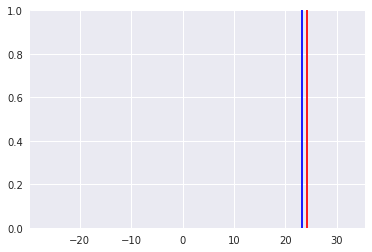

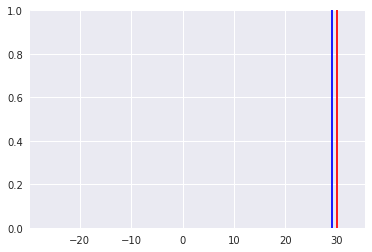

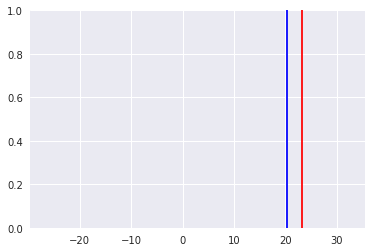

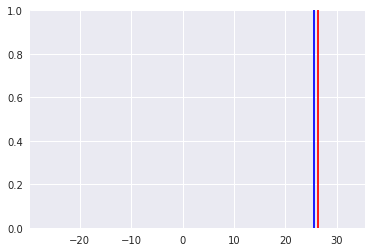

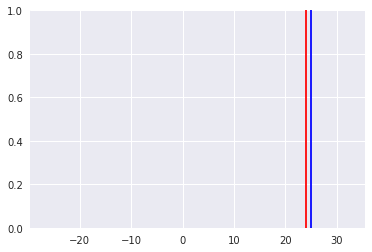

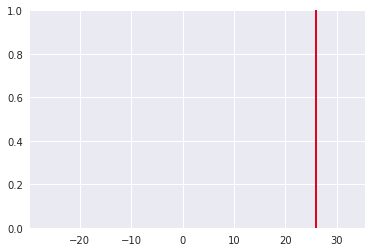

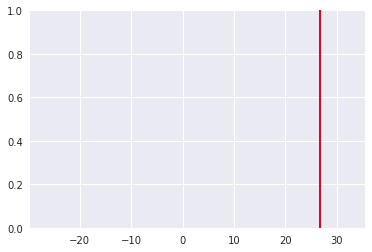

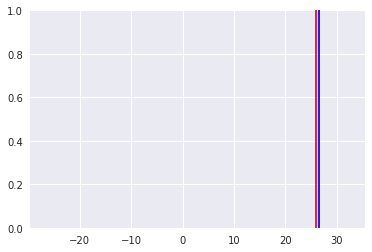

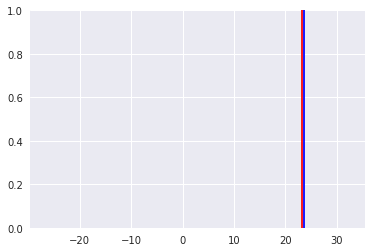

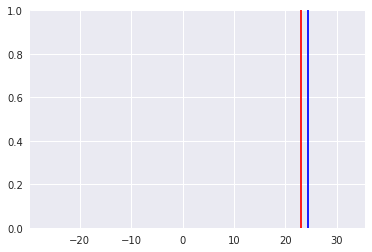

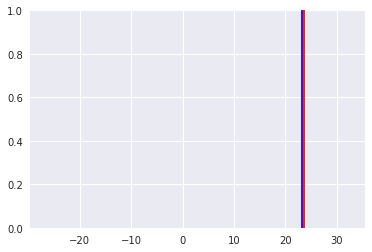

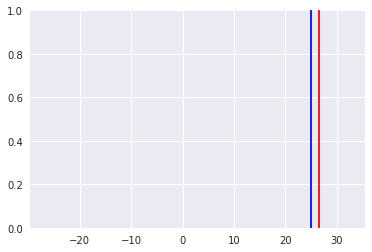

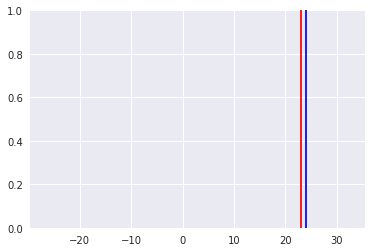

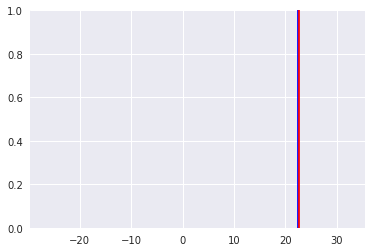

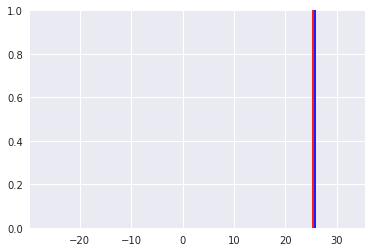

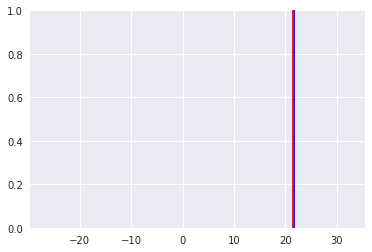

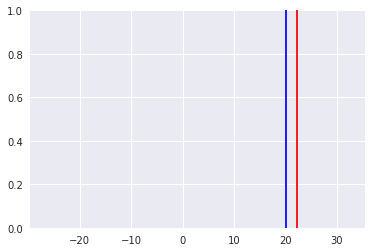

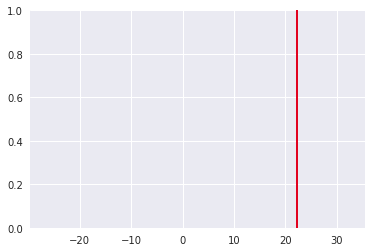

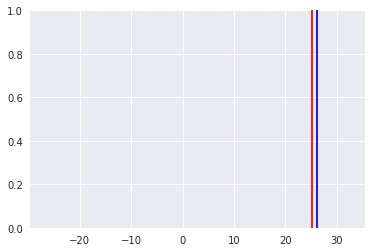

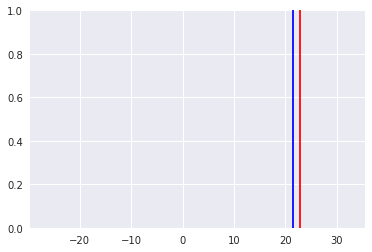

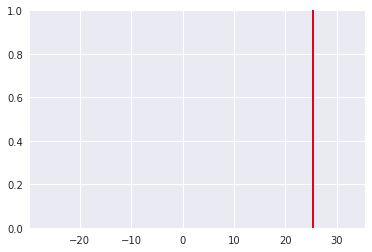

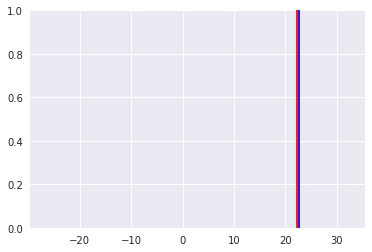

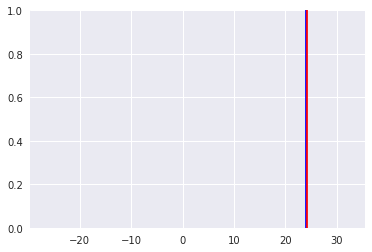

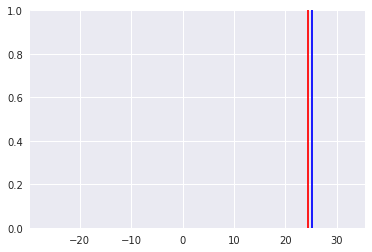

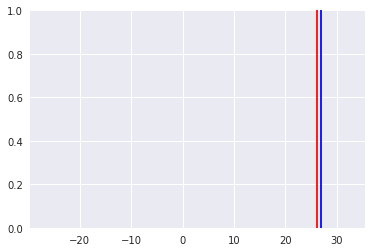

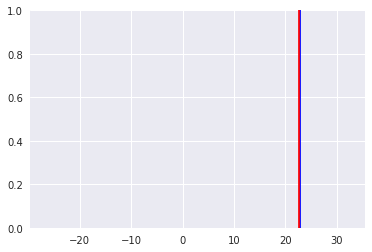

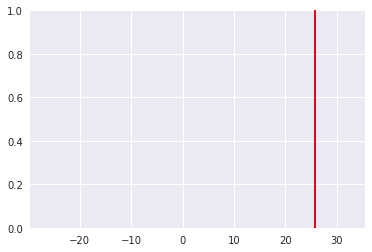

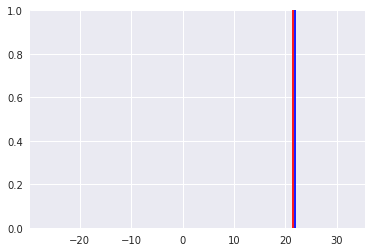

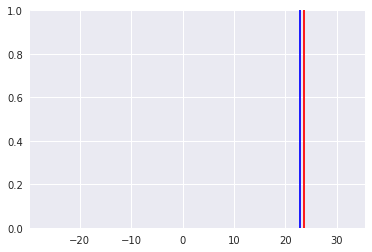

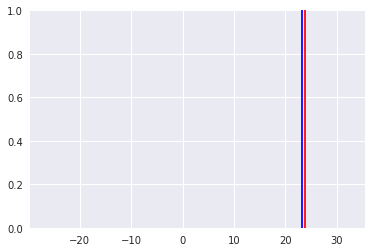

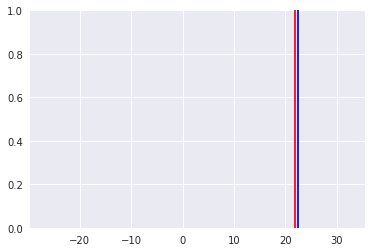

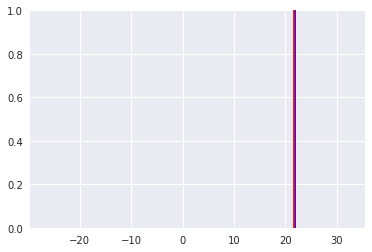

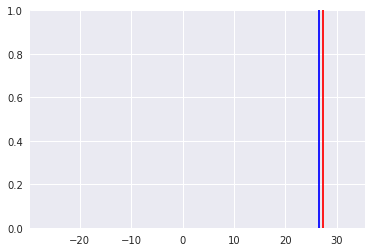

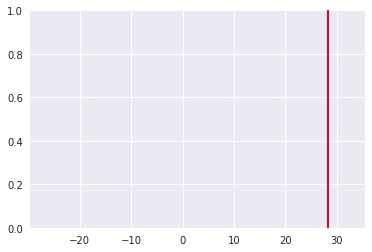

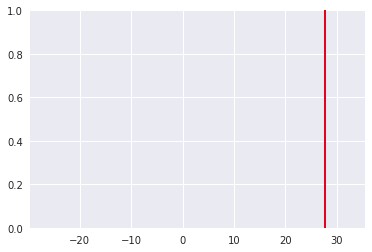

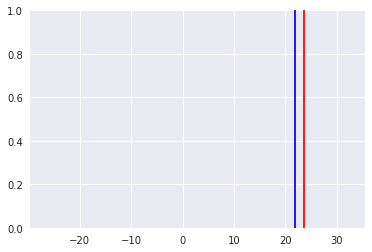

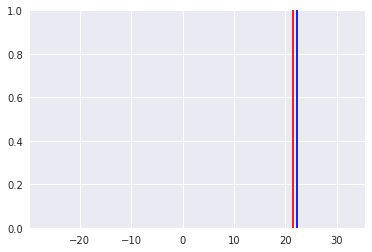

In [67]:
for i in high_labels_indices[:100]:
    plt.axvline(prediction[i], color='blue')
    plt.axvline(Y_test[i], color='red')
    plt.xlim(np.min(Y_train), np.max(Y_train))
    plt.show()

### Results of Init with best Forecast Skill against Baseline

In [ ]:
# best forecast skill over all stations is at 18.03.2016 12:00
best_fs_init = '16031812'

In [ ]:
test_data_set_indices = test_data_set[test_data_set['Init'].str.contains(best_fs_init)].index.values

#### Runtime Information of influence calculation for forst test point
Inverse HVP took 1152.7211821079254 sec<br>
Multiplying by 819522 train examples took 719.394656419754 sec

In [ ]:
# calculate influences for first test station for '16031812'
best_init_influences = tf_model.get_influence_on_test_loss(
    [test_data_set_indices[0]], 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples

In [ ]:
plotTestIdxResultsWithInfluences(influences=best_init_influences, test_idx=test_data_set_indices[0])

### Influence calculation for all stations of best init.

### calculate influences for all test stations of '16031812'
best_init_influences_all_stations = tf_model.get_influence_on_test_loss(
    list(test_data_set_indices), 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples

In [ ]:
plotTestIdxResultsWithInfluences(influences=best_init_influences_all_stations)

In [ ]:

# NOT WORKING, can be taken as an example to calculate many influences
station_idx = 856
result_dictionary = {}
for init in ['16011809', '16011815' ,'16070409' ,'16070415']:
    test_idx = test_data_set.loc[test_data_set['Station'] == station_idx].loc[test_data_set['Init'].str.startswith(init)].index[0]
    test_station, test_init = test_data_set.iloc[test_idx].loc[['Station', 'Init']]
    
    influences = tf_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples
    
    result_dictionary['influences_station_%s_init_%s' % (station_idx, init)] = influences
np.savez('output/station_%s_results' % station_idx, result_dictionary)

## Results for station "La Brévine"

In [ ]:
test_data_set.loc[test_data_set['Station'] == 852]

In [ ]:
num_zeros = []
for idx in test_data_set.index[test_data_set['Station'] == 852]:
    num_zeros += [np.sum([1 for i in test_data_set.iloc[idx].as_matrix()[2:] if i == 0])]

In [ ]:
from matplotlib import pyplot as plt
plt.hist(num_zeros)
plt.show()

In [ ]:
test_idx = 3753
num_train = len(tf_model.data_sets.train.labels)

## Results for station "Ilanz"

In [ ]:
influences = np.load('output/components_results.npz')['influences']
test_idx = test_data_set.loc[test_data_set['Station'] == 630].loc[test_data_set['Init'].str.startswith('17041603')].index[0]
plotTestIdxResultsWithInfluences(influences=influences, test_idx=test_idx)

# Results for "Säntis"

#### Plots for Station 35 (Säntis) on 18.01.16 09:00

In [ ]:
station_35_results = np.load('output/station_35_results.npz')['arr_0'].item()

In [ ]:
influences = station_35_results['influences_station_35_init_16011809']
test_idx = test_data_set.loc[test_data_set['Station'] == 35].loc[test_data_set['Init'].str.startswith('16011809')].index[0]
print(test_idx)
plotTestIdxResultsWithInfluences(influences=influences, test_idx=test_idx)

#### Plots for Station 35 (Säntis) on 04.07.16 09:00

In [ ]:
influences = station_35_results['influences_station_35_init_16070409']
test_idx = test_data_set.loc[test_data_set['Station'] == 35].loc[test_data_set['Init'].str.startswith('16070409')].index[0]
print(test_idx)
plotTestIdxResultsWithInfluences(influences=influences, test_idx=test_idx)

#### Plots for Station 35 (Säntis) on 04.07.16 15:00

In [ ]:
influences = station_35_results['influences_station_35_init_16070415']
test_idx = test_data_set.loc[test_data_set['Station'] == 35].loc[test_data_set['Init'].str.startswith('16070415')].index[0]
print(test_idx)
plotTestIdxResultsWithInfluences(influences=influences, test_idx=test_idx)

## Results for "Les Diablerets"

#### Calculate influences for "Les Diablerets"

In [ ]:
station_idx = 856
result_dictionary = {}
for init in ['16011809', '16011815' ,'16070409' ,'16070415']:
    test_idx = test_data_set.loc[test_data_set['Station'] == station_idx].loc[test_data_set['Init'].str.startswith(init)].index[0]
    test_station, test_init = test_data_set.iloc[test_idx].loc[['Station', 'Init']]
    
    influences = tf_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples
    
    result_dictionary['influences_station_%s_init_%s' % (station_idx, init)] = influences
np.savez('output/station_%s_results' % station_idx, result_dictionary)

#### Load influences

In [ ]:
station_856_results = np.load('output/station_856_results.npz')['arr_0'].item()

In [ ]:
station_856_results

#### Plots for Station 856 (Les Diablerets) on 18.01.16 09:00

In [ ]:
influences = station_856_results['influences_station_856_init_16011809']
test_idx = test_data_set.loc[test_data_set['Station'] == 856].loc[test_data_set['Init'].str.startswith('16011809')].index[0]
print(test_idx)
plotTestIdxResultsWithInfluences(influences=influences, test_idx=test_idx)

#### Plots for Station 856 (Les Diablerets) on 18.01.16 15:00

In [ ]:
influences = station_856_results['influences_station_856_init_16011815']
test_idx = test_data_set.loc[test_data_set['Station'] == 856].loc[test_data_set['Init'].str.startswith('16011815')].index[0]
print(test_idx)
plotTestIdxResultsWithInfluences(influences=influences, test_idx=test_idx)

#### Plots for Station 856 (Les Diablerets) on 04.07.16 09:00

In [ ]:
influences = station_856_results['influences_station_856_init_16070409']
test_idx = test_data_set.loc[test_data_set['Station'] == 856].loc[test_data_set['Init'].str.startswith('16070409')].index[0]
print(test_idx)
plotTestIdxResultsWithInfluences(influences=influences, test_idx=test_idx)

#### Plots for Station 856 (Les Diablerets) on 04.07.16 15:00

In [ ]:
influences = station_856_results['influences_station_856_init_16070415']
test_idx = test_data_set.loc[test_data_set['Station'] == 856].loc[test_data_set['Init'].str.startswith('16070415')].index[0]
print(test_idx)
plotTestIdxResultsWithInfluences(influences=influences, test_idx=test_idx)

## Prepare Data with Error Prediction

In [108]:
# split data set into train and test
train_data_set = neural_embeddings_error_prediction['train_embeddings']
train_label_set = neural_embeddings_error_prediction['train_labels']
test_data_set = neural_embeddings_error_prediction['test_embeddings']
test_label_set = neural_embeddings_error_prediction['test_labels']

In [144]:
filtered_train_labels = train_label_set[(train_label_set >= -10) & (train_label_set <= 21)].index
filtered_test_labels = test_label_set[(test_label_set >= -10) & (test_label_set <= 21)].index

In [148]:
# get numpy representation of neural embeddings
X_train = train_data_set.iloc[filtered_train_labels].as_matrix()[:,2:]
Y_train = train_label_set.iloc[filtered_train_labels].as_matrix()[:]
X_test = test_data_set.iloc[filtered_test_labels].as_matrix()[:,2:]
Y_test = test_label_set.iloc[filtered_test_labels].as_matrix()[:]

# calculate number of training examples
num_train_examples = X_train.shape[0]
num_test_examples = X_test.shape[0]
num_features = X_train.shape[1]

In [182]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train),np.min(Y_test)), np.maximum(np.max(Y_train),np.max(Y_test))
n_classes = int(np.ceil((max_label - min_label)/0.34))

# get index of bucket for each training data
train_temp_bucket_index = np.digitize(Y_train, np.linspace(min_label,max_label,n_classes))-1
test_temp_bucket_index = np.digitize(Y_test, np.linspace(min_label,max_label, n_classes))-1

In [183]:
debug = False
if debug:
    train_idx = []
    test_idx = []
    for i in range(n_classes):
        class_label = i
        try:
            train_idx += np.argwhere(train_temp_bucket_index == class_label).squeeze().tolist()[0:10]
        except:
            train_idx += [np.argwhere(train_temp_bucket_index == class_label).squeeze().tolist()]
        try:
            test_idx += np.argwhere(test_temp_bucket_index == class_label).squeeze().tolist()[0:3]
        except:
            test_idx += [np.argwhere(test_temp_bucket_index == class_label).squeeze().tolist()]
            
    lr_train = DataSet(X_train[train_idx], train_temp_bucket_index[train_idx])
    lr_validation = None
    lr_test = DataSet(X_test[:10], test_temp_bucket_index[:10])
    lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)
else:
    lr_train = DataSet(X_train, train_temp_bucket_index)
    lr_validation = None
    lr_test = DataSet(X_test, test_temp_bucket_index)
    lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)
print("%s training samples, %s test samples." % (lr_train.num_examples, lr_test.num_examples))

819335 training samples, 103156 test samples.


In [189]:
n_classes, len(set(train_temp_bucket_index)), len(set(test_temp_bucket_index))

(90, 90, 72)

## Prepare Model

In [185]:
num_classes = n_classes
input_dim = num_features
weight_decay = 0.01
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000

num_params = num_features

In [186]:
tf.reset_default_graph()

tf_model = LogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='cosmo_correction_nerual_embedding_logreg')

tf_model.train(verbose=True)

Total number of parameters: 5760
Using normal model


/home/ninow/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


(819335, 64) (819335,)
(90, 64)
(5760,)
LBFGS training took [12] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 3.8345635
Train loss (w/o reg) on all data: 3.548832
Test loss (w/o reg) on all data: 3.5390327
Train acc on all data:  0.09093228044694783
Test acc on all data:   0.09007716468261662
Norm of the mean of gradients: 2.5550162e-06
Norm of the params: 7.55952


In [68]:
complete_test_data = test_data_set

In [200]:
np.min(list(filtered_test_labels))

0

In [201]:
influences_complete_test_data = tf_model.get_influence_on_test_loss(
    np.arange(len(tf_model.data_sets.test.labels)), 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples

Norm of test gradient: 0.0791374038688595
Function value: -0.130125265685491
Split function value: 0.13014885786412134, -0.2602741235496123
Predicted loss diff on train_idx 5: -1.7636169180668467e-06
Function value: -0.14928645937458046
Split function value: 0.14072923609889437, -0.29001569547347483
Predicted loss diff on train_idx 5: -1.750961695698649e-06
Function value: -0.15023014643676175
Split function value: 0.14954061774988586, -0.2997707641866476
Predicted loss diff on train_idx 5: -1.7818294293665247e-06
Function value: -0.15030563504302163
Split function value: 0.15025508643044938, -0.300560721473471
Predicted loss diff on train_idx 5: -1.7647588478997969e-06
Function value: -0.15030589328494953
Split function value: 0.15030399932418403, -0.30060989260913357
Predicted loss diff on train_idx 5: -1.764790018604491e-06
Function value: -0.1503058935255541
Split function value: 0.15030447830386598, -0.3006103718294201
Predicted loss diff on train_idx 5: -1.7647885408233463e-06
  

In [202]:
np.savez('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_all_data_error_prediction_bucket_0_34', influences_complete_test_data)

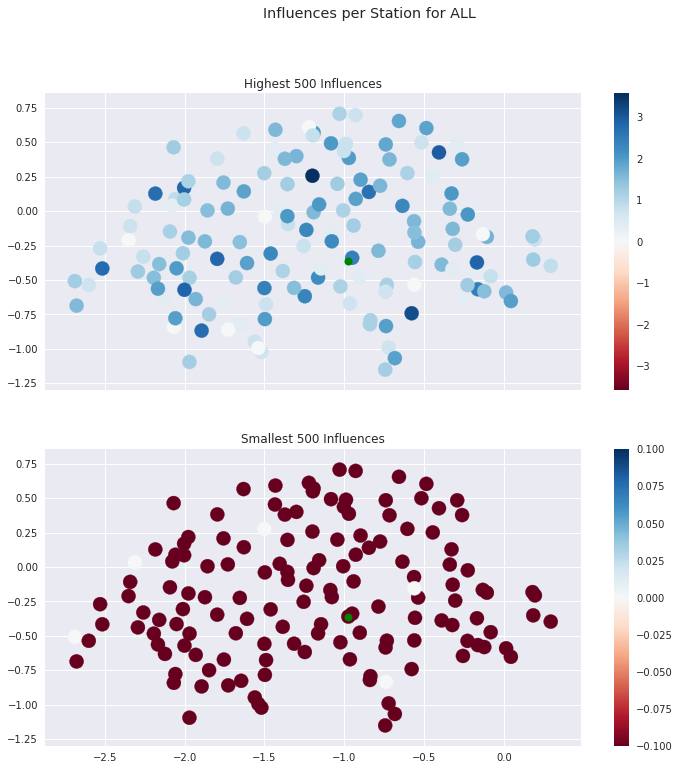

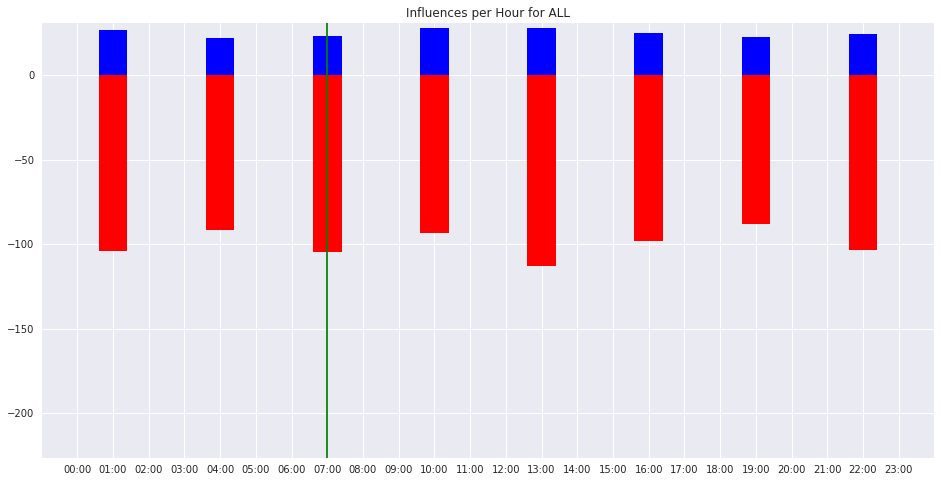

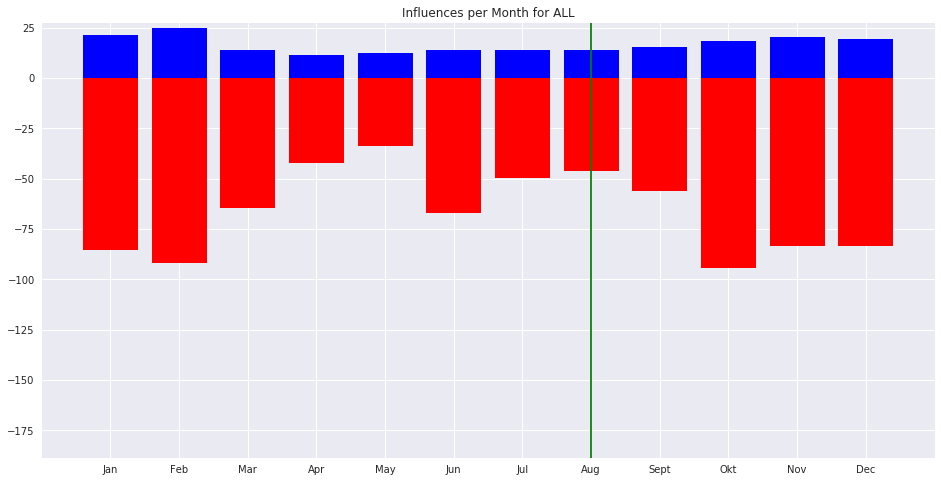

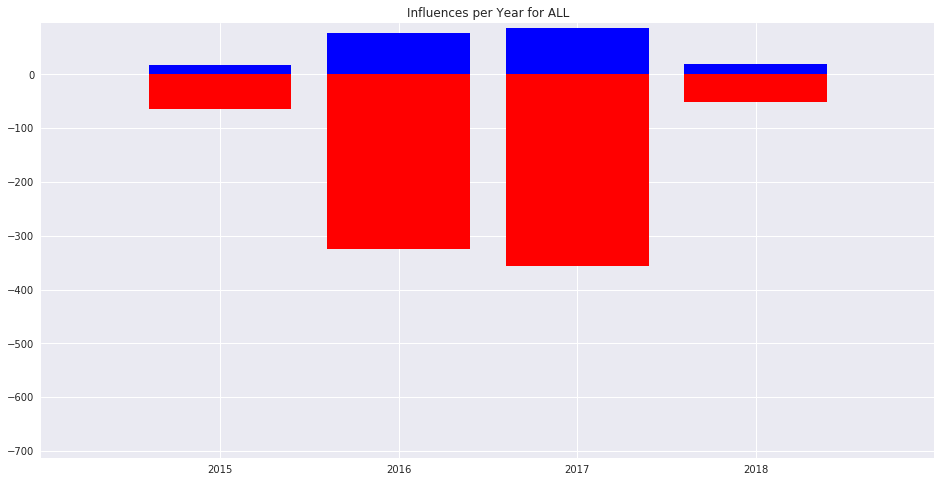

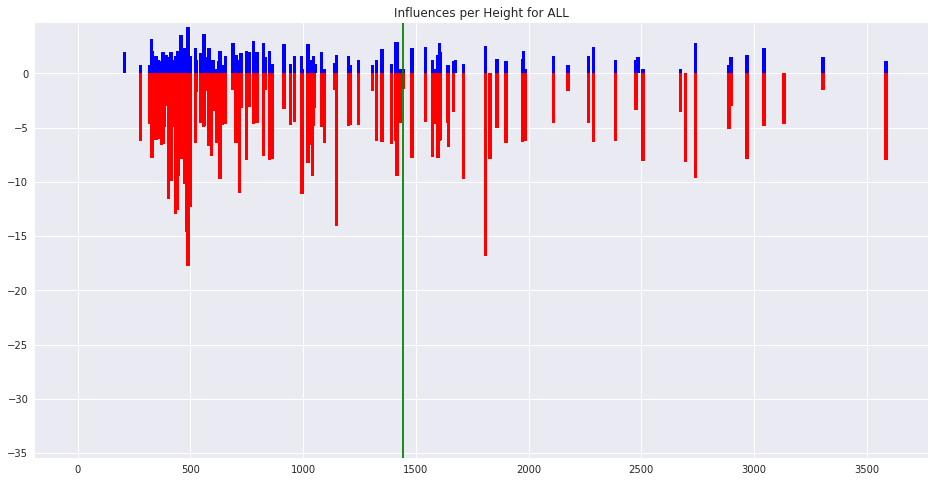

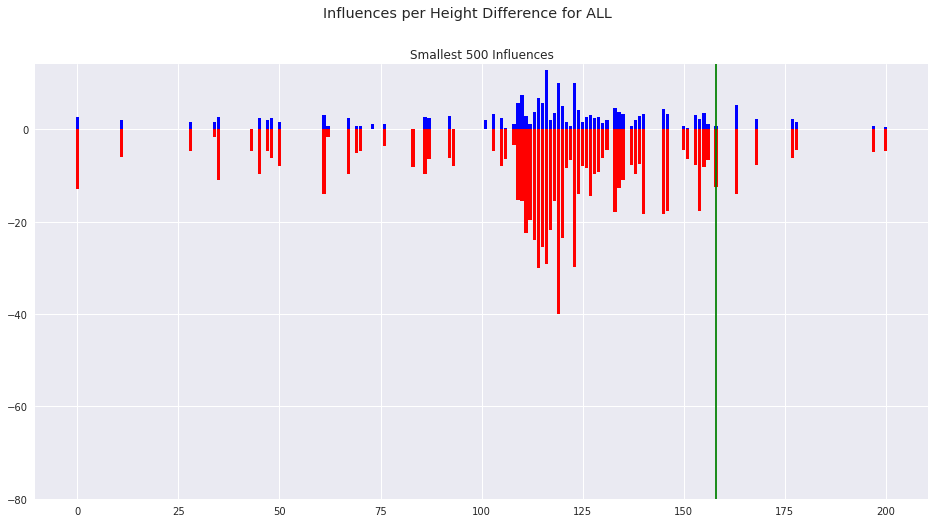

In [203]:
plotSummedInfluences(influences=influences_complete_test_data, title='ALL')

In [1]:
plt.hist2d(Y_train, influences_complete_test_data)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
sorted_indices = np.argsort(influences_complete_test_data)
plt.plot(influences_complete_test_data[sorted_indices])
plt.show()

# Analyze model predictions

In [187]:
predicted_class_probabilities = tf_model.sklearn_model.predict_proba(X_test)

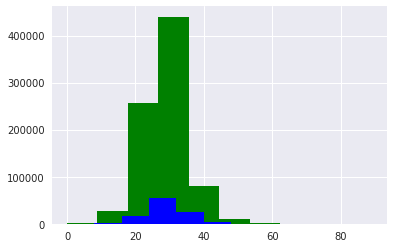

In [188]:
plt.hist(lr_train.labels, color='green')
plt.hist(lr_test.labels, color='blue')
plt.show()

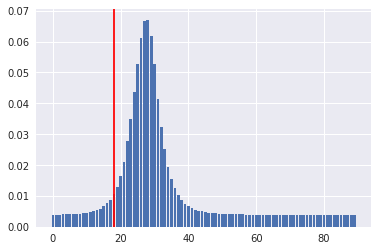

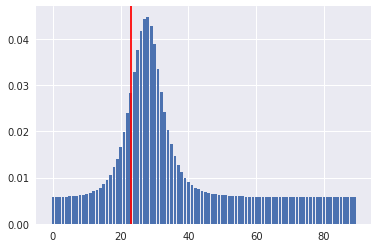

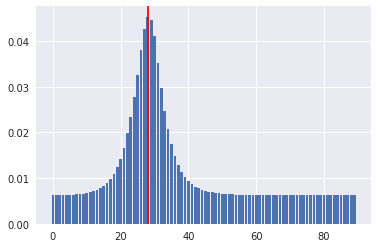

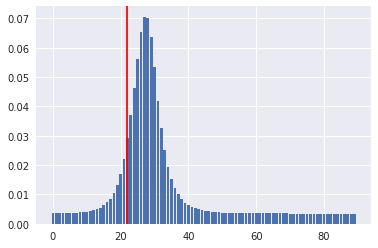

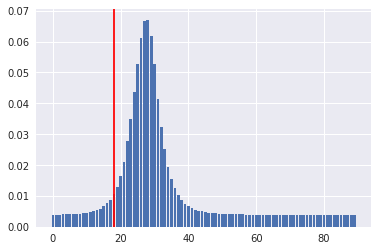

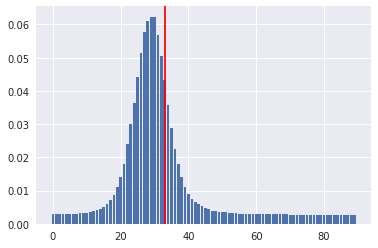

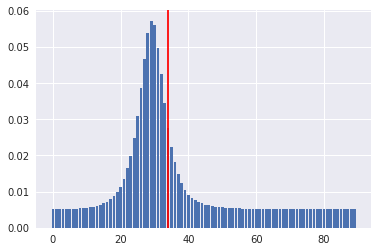

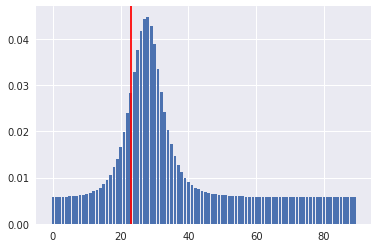

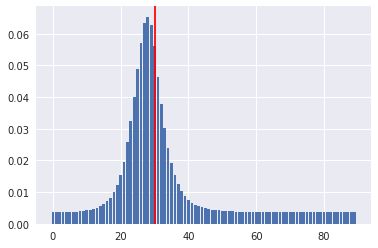

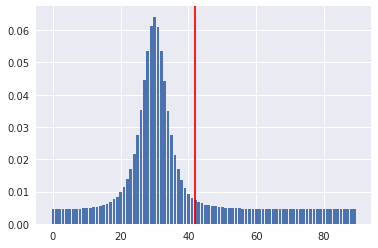

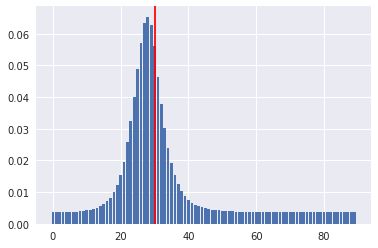

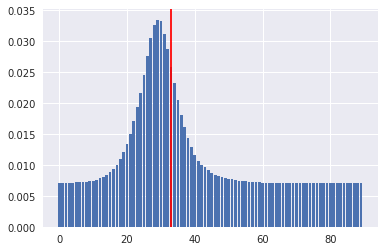

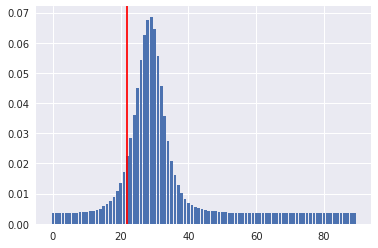

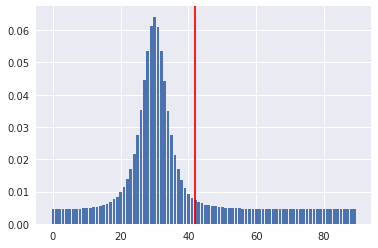

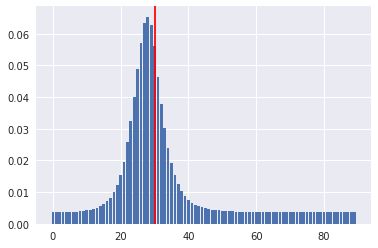

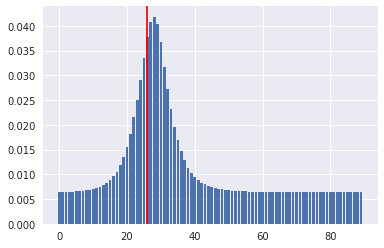

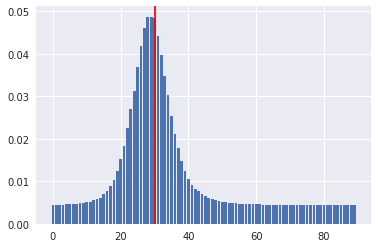

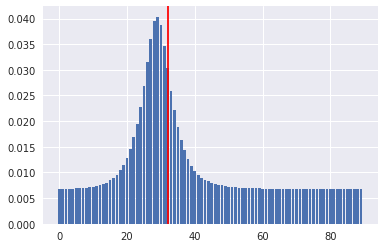

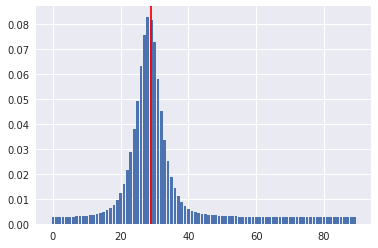

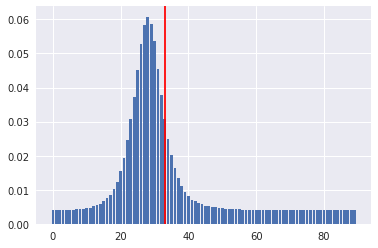

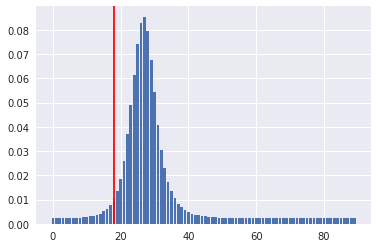

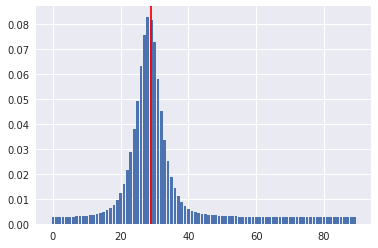

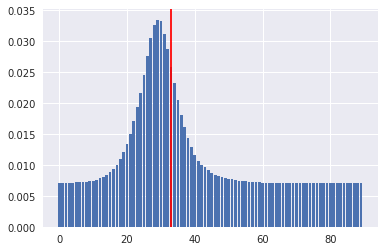

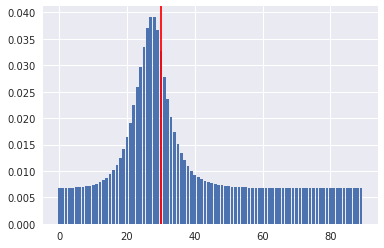

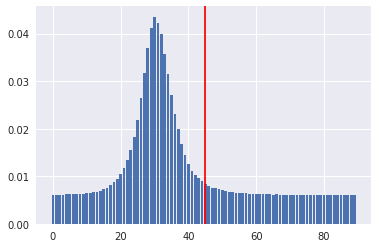

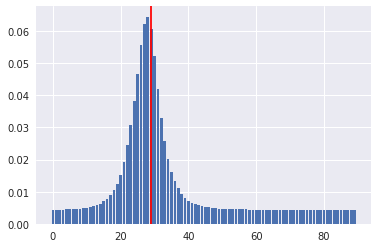

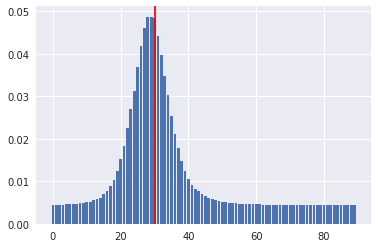

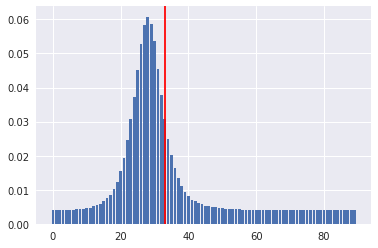

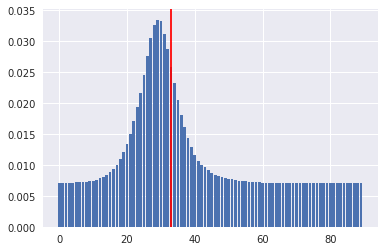

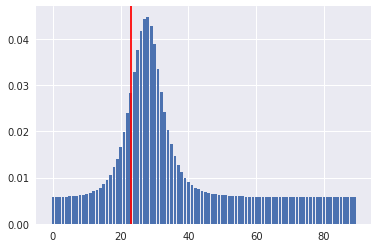

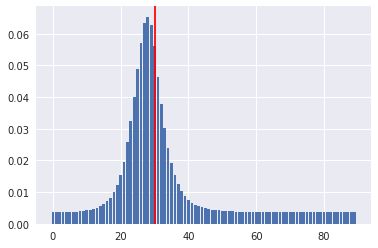

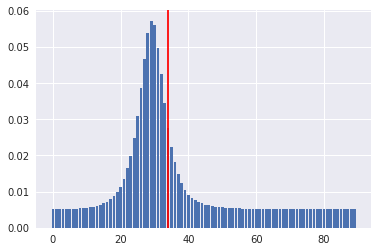

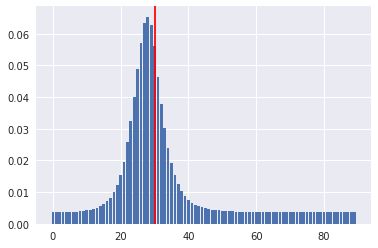

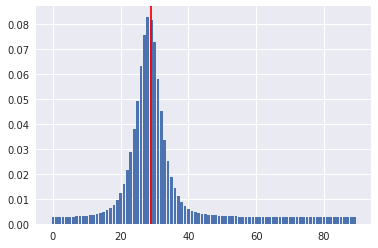

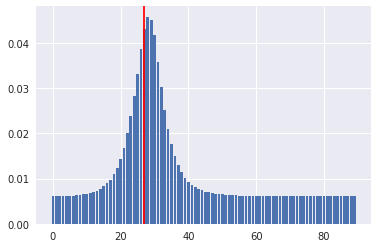

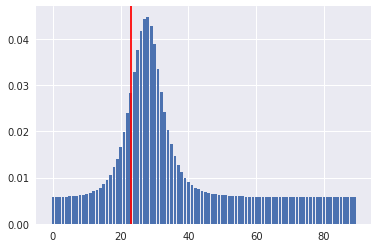

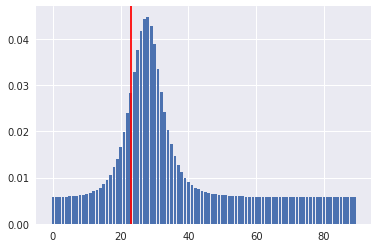

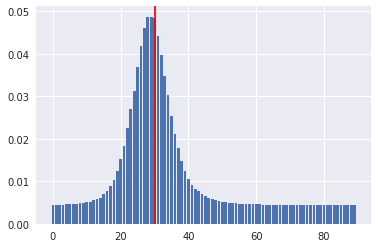

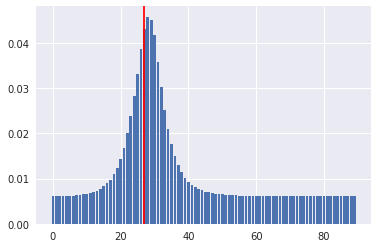

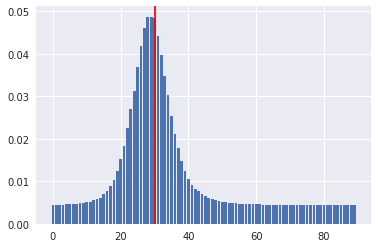

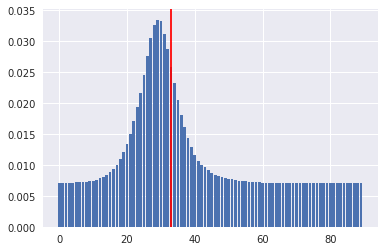

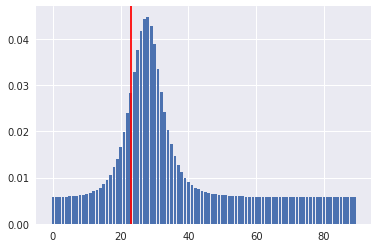

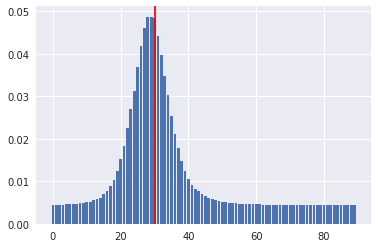

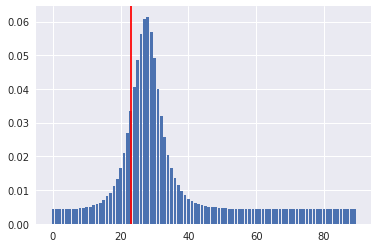

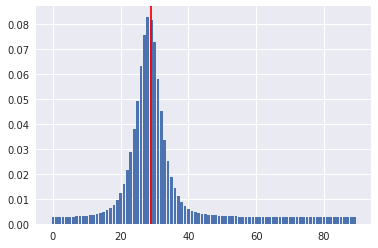

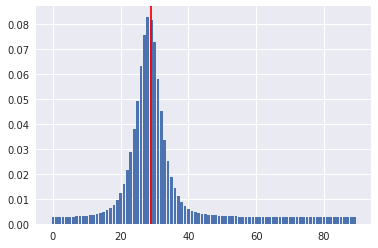

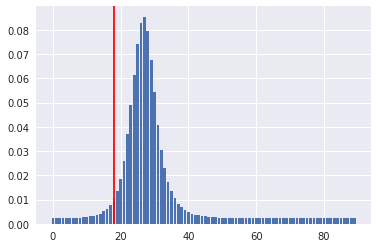

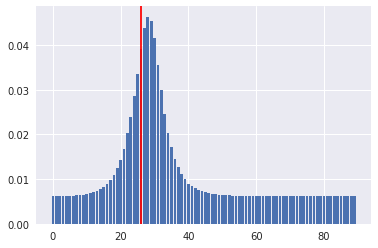

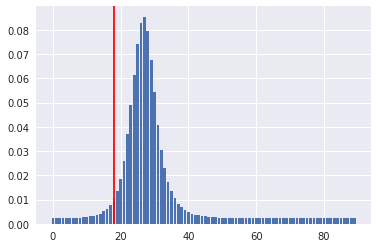

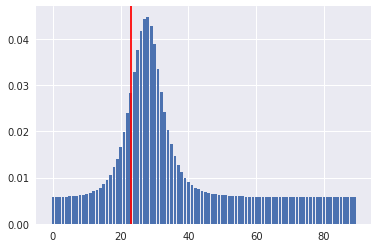

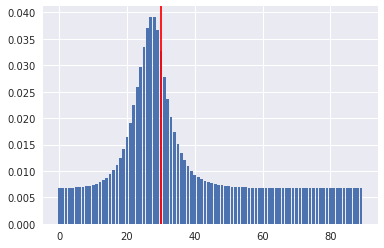

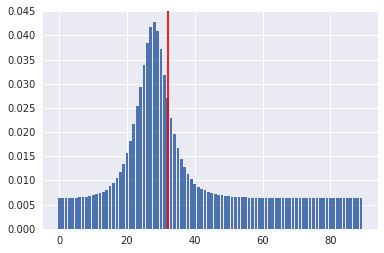

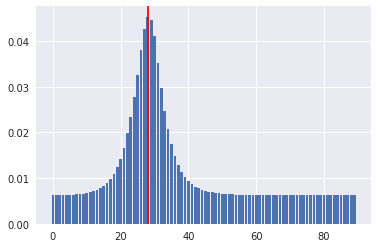

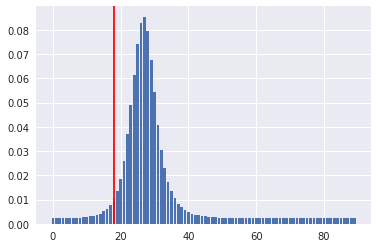

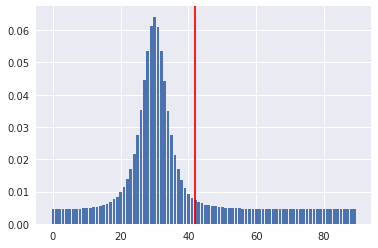

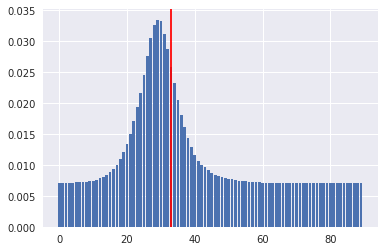

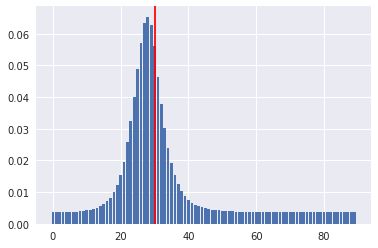

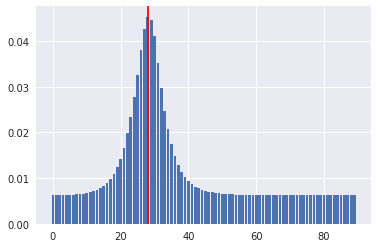

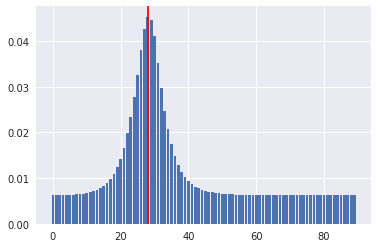

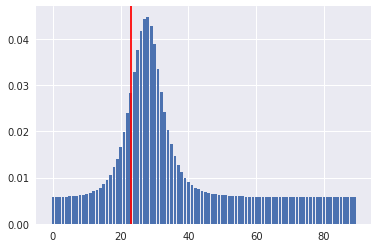

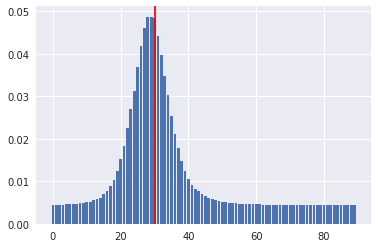

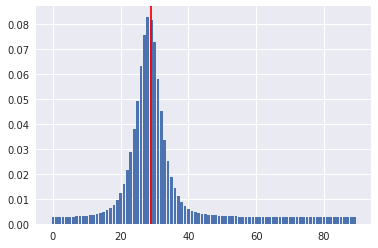

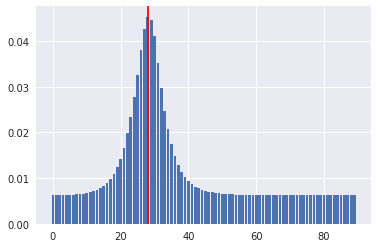

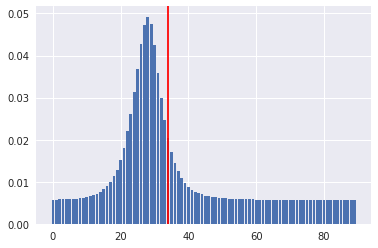

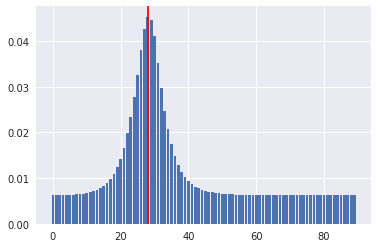

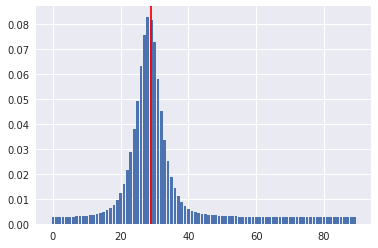

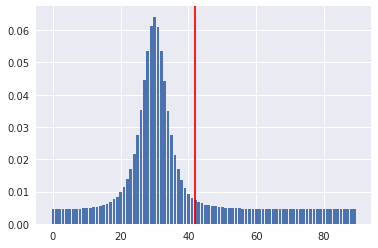

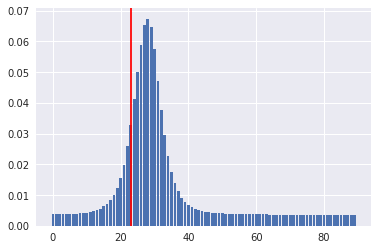

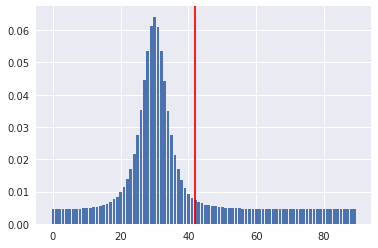

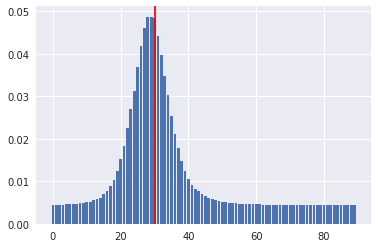

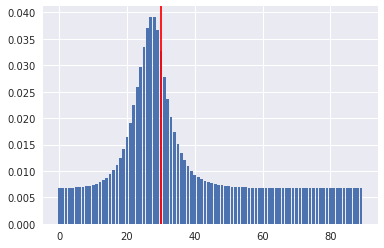

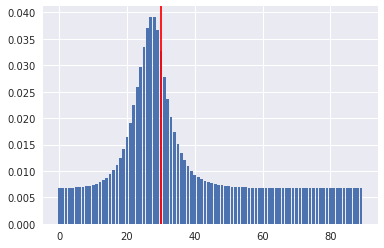

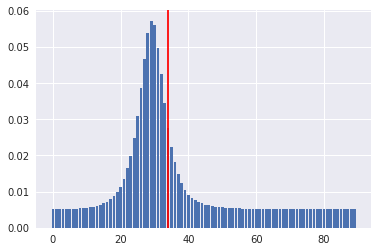

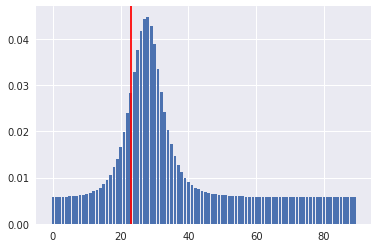

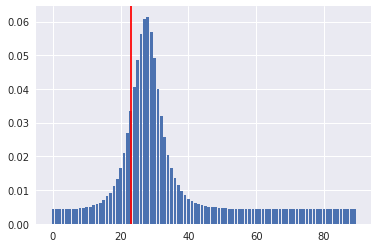

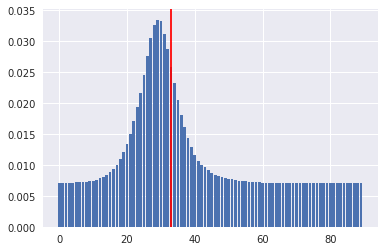

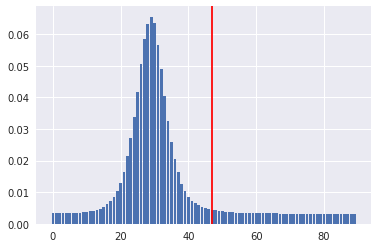

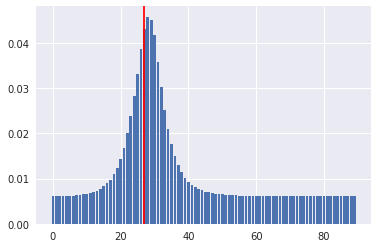

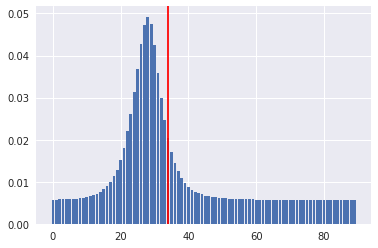

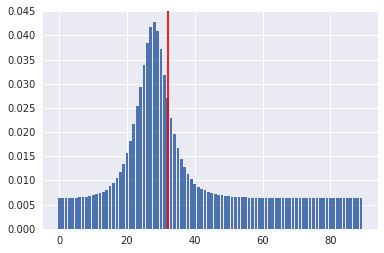

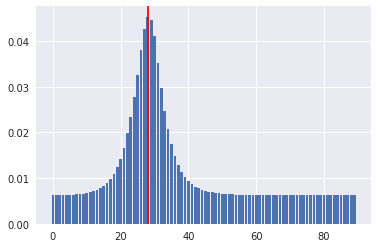

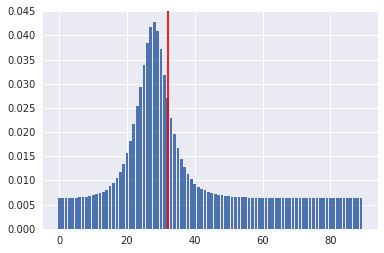

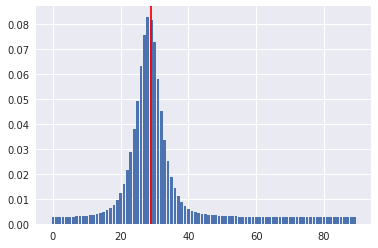

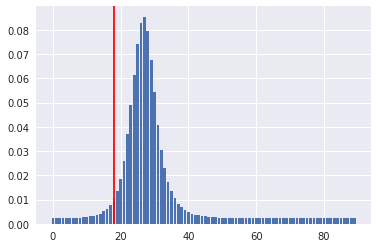

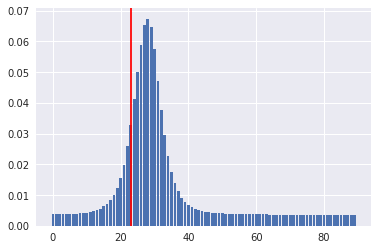

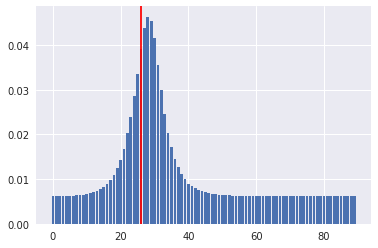

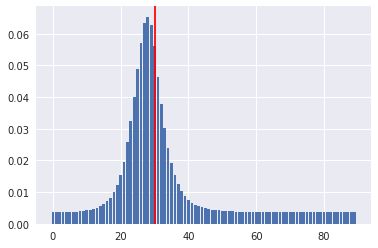

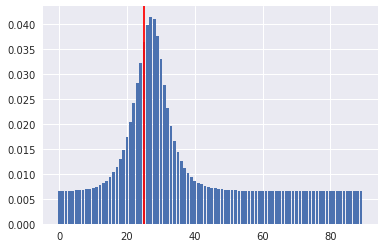

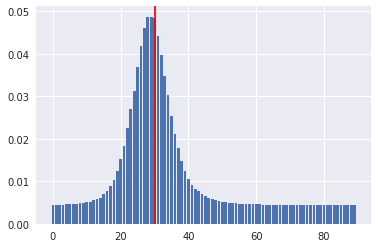

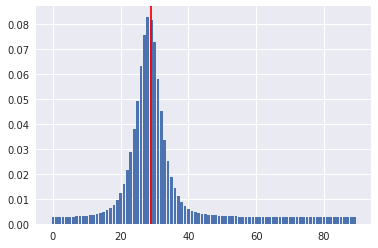

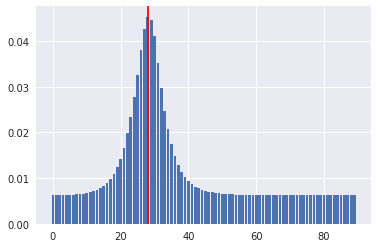

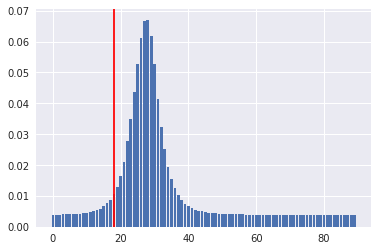

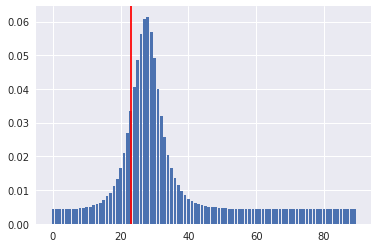

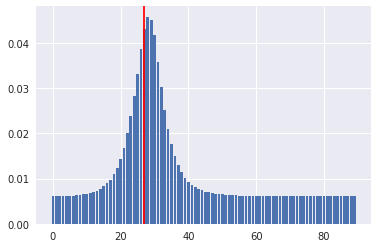

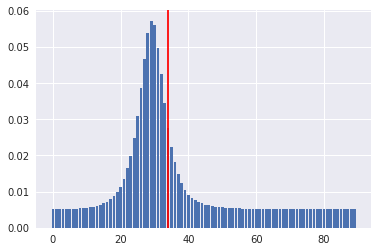

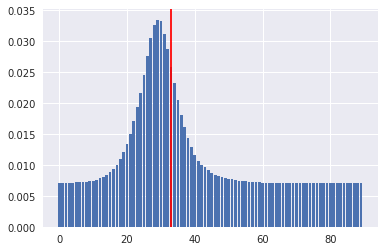

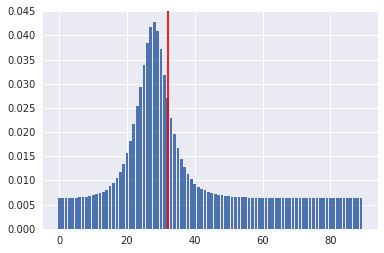

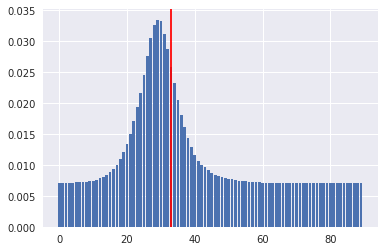

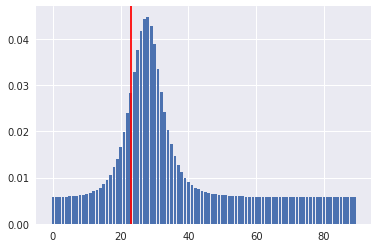

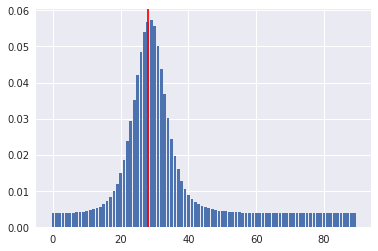

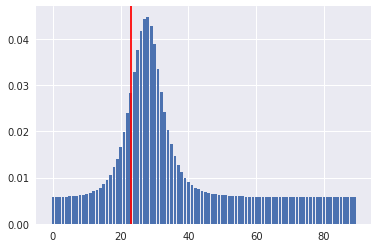

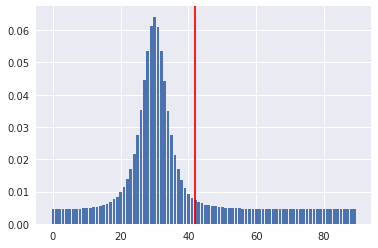

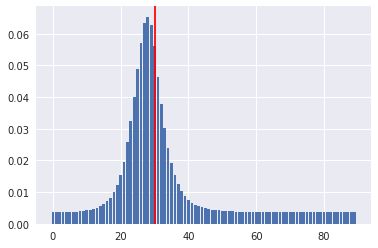

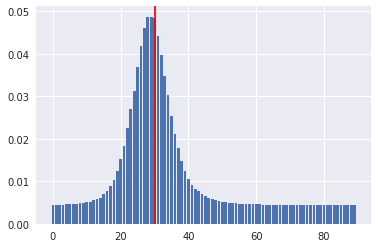

In [193]:
high_labels_indices = [idx for idx, l in enumerate(test_temp_bucket_index) if l >= 40]
low_labels_indices = [idx for idx, l in enumerate(test_temp_bucket_index) if l <=20]
for i in test_temp_bucket_index[::1000]:
    plt.bar(np.arange(len(predicted_class_probabilities[i])), predicted_class_probabilities[i])
    plt.axvline(test_temp_bucket_index[i], color='red')
    plt.show()

In [ ]:
plt.hist(test_temp_bucket_index)
plt.show()

## Calculate influences for test point

In [ ]:
test_idx = test_data_set.loc[test_data_set['Station'] == 35].loc[test_data_set['Init'].str.startswith('16070415')].index[0]
test_station, test_init = test_data_set.iloc[test_idx].loc[['Station', 'Init']]

In [ ]:
test_station, test_init

In [ ]:
influences = tf_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(tf_model.data_sets.train.labels)),
    force_refresh=True) * num_train_examples

## Plot Prediction Error per Station

In [ ]:
init_type_mapping = prediction_error.init_type_mapping
test_inits = [i[0] for i in init_type_mapping if i[1] == 'test']
test_errors = prediction_error.sel(init = test_inits)

In [ ]:
rmse_per_station = np.sqrt(np.nanmean(np.square(test_errors.sel(data = 'difference').data), axis=0))

In [ ]:
best_stations = np.argsort(rmse_per_station)

In [ ]:
x_ticks_idx = np.array((range(len(best_stations))))
idx_splits = np.split(x_ticks_idx, 8)
for idx_split in idx_splits: 
    fig = plt.figure(figsize=(22,6))
    plt.bar(x_ticks_idx[idx_split], rmse_per_station[best_stations[idx_split]], width=0.5)
    plt.xticks(x_ticks_idx[idx_split], station_names[best_stations[idx_split]].data)
    plt.show()

In [ ]:
month_dict={0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sept', 9:'Okt', 10:'Nov', 11:'Dec'}


    
def plotSummedInfluences(influences, title, test_idx=0):
    # get init, station, rlat, rlon, height and height difference for test idx
    test_init, test_station = test_data_set.iloc[test_idx].as_matrix()[0:2]
    test_station_rlat, test_station_rlon, test_station_height = station_positions.sel(station = test_station).data
    test_station_hh_diff = station_heigh_diff.sel(station = test_station).data

    # index in array representation of stations
    test_station_idx = stations.data.tolist().index(test_station)
    # get formatted station name
    test_station_name = station_names[test_station_idx].item()
    
    # define number of influences to be plotted
    k_largest_influences = 200
    k_smallest_influences = 200

    # get largest and smallest influences
    largest_influence_idx = np.argsort(influences)[-k_largest_influences:]
    smallest_influence_idx = np.argsort(influences)[:k_smallest_influences]

    # get array of ('Station','Init') ordered by training sample indices
    init_station_train_data = train_data_set.loc[:,'Init':'Station'].as_matrix()
    
    # get station & init samples with the largest influence
    station_init_by_largest_influence = []
    for train_sample_idx in largest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_largest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_largest_influence = sorted(station_init_by_largest_influence, key=itemgetter(2))
    largest_influence_data = np.array(list(zip(*station_init_by_largest_influence)), dtype='float64')

    # get station & init samples with the smallest influence
    station_init_by_smallest_influence = []
    for train_sample_idx in smallest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_smallest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_smallest_influence = sorted(station_init_by_smallest_influence, key=itemgetter(2))
    smallest_influence_data = np.array(list(zip(*station_init_by_smallest_influence)), dtype='float64')

    # plot influence by station
    fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(12,12))
    
    # sum influence of most influential points per station
    sum_largest_influences_per_station = np.bincount(largest_influence_data[0].astype(int),largest_influence_data[2],
                                                     np.max(stations.data)+1)[stations]
    sum_smallest_influences_per_station = np.bincount(smallest_influence_data[0].astype(int),smallest_influence_data[2],
                                                      np.max(stations.data)+1)[stations]
    
    # plot stations with largest effect
    cax = axes[0].scatter(station_positions.sel(positinal_attribute = 'rlon'),
                 station_positions.sel(positinal_attribute = 'rlat'),
                 c=sum_largest_influences_per_station, s=200, cmap='RdBu',
                 norm=mpl.colors.Normalize(vmin=-np.max(sum_largest_influences_per_station),
                                           vmax=np.max(sum_largest_influences_per_station)))
    axes[0].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=8)
    fig.colorbar(cax, ax=axes[0])
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    cax = axes[1].scatter(station_positions.sel(positinal_attribute = 'rlon'),
                 station_positions.sel(positinal_attribute = 'rlat'),
                 c=sum_smallest_influences_per_station, s=200, cmap='RdBu',
                 norm=mpl.colors.Normalize(vmin=-np.max(sum_smallest_influences_per_station),
                                           vmax=np.max(sum_smallest_influences_per_station)))
    axes[1].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=8)
    fig.colorbar(cax, ax=axes[1])
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)

    plt.suptitle('Influences per Station for %s' % title)
    plt.show()
    plt.close()

    # plot influence by hour
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(12,12))
    
    # sum influence of most influential points per hour
    sum_largest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 24)
    sum_smallest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 24)
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_hour)),
                                        np.max(np.absolute(sum_smallest_influences_per_hour)))
    
    # plot stations with largest effect
    axes[0].bar(np.arange(0,24), sum_largest_influences_per_hour, color='blue')
    axes[0].axvline(x=int(test_init[6:8])+1, color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with largest effect
    axes[1].bar(np.arange(0,24), sum_smallest_influences_per_hour, color='red')
    axes[1].axvline(x=int(test_init[6:8])+1,color='green')
    axes[1].set_xlim(-1,24,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Hour for %s' % title)
    plt.setp(axes, xticks=range(24), xticklabels=["%02d:00" % h for h in range(24)])
    plt.show()
    plt.close()

    # plot influence by month
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(12,12))
    
    # sum influence of most influential points per month
    sum_largest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 13)[1:]
    sum_smallest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 13)[1:]
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_month)),
                                        np.max(np.absolute(sum_smallest_influences_per_month)))
        
    # plot stations with largest effect
    axes[0].bar(np.arange(1,13), sum_largest_influences_per_month, color='blue')
    axes[0].axvline(x=int(test_init[2:4]),color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(np.arange(1,13), sum_smallest_influences_per_month, color='red')
    axes[1].axvline(x=int(test_init[2:4]),color='green')
    axes[1].set_xlim(0,13,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Month for %s' % title)
    plt.setp(axes[1], xticks=np.arange(1,13), xticklabels=[month_dict[m] for m in range(12)])
    plt.show()
    plt.close()
    
    
    # plot influence by year
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(12,12))
    
    # sum influence of most influential points per year
    sum_largest_influences_per_year = np.take(np.bincount([int(str(m)[:2]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 19), (15,16,17,18))
    sum_smallest_influences_per_year = np.take(np.bincount([int(str(m)[:2]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 19), (15,16,17,18))
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_year)),
                                        np.max(np.absolute(sum_smallest_influences_per_year)))
    
    # plot stations with largest effect
    axes[0].bar(np.arange(15,19), sum_largest_influences_per_year, color='blue')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(np.arange(15,19), sum_smallest_influences_per_year, color='red')
    axes[1].set_xlim(14,19,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Year for %s' % title)
    plt.setp(axes[1], xticks=np.arange(15,19), xticklabels=['2015', '2016', '2017', '2018'])
    plt.show()
    plt.close()
    
    # plot influence against height
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(12,12))
    
    # sum influence of most influential points per height
    sum_largest_influences_per_height = np.bincount(largest_influence_data[5].astype(int), largest_influence_data[2])
    sum_smallest_influences_per_height = np.bincount(smallest_influence_data[5].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_height)),
                                        np.max(np.absolute(sum_smallest_influences_per_height)))
    
    # plot stations with largest effect
    axes[0].bar(range(len(sum_largest_influences_per_height)), sum_largest_influences_per_height, color='blue', width=15)
    axes[0].axvline(x=test_station_height,color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with smallest effect
    axes[1].bar(range(len(sum_smallest_influences_per_height)), sum_smallest_influences_per_height, color='red', width=15)
    axes[1].axvline(x=test_station_height,color='green')
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Influences per Height for %s' % title)
    plt.show()
    plt.close()

    # plot influence against height difference
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(12,12))
    
    # sum influence of most influential points per height difference
    sum_largest_influences_per_height_difference = np.bincount(largest_influence_data[6].astype(int), largest_influence_data[2])
    sum_smallest_influences_per_height_difference = np.bincount(smallest_influence_data[6].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_height_difference)),
                                        np.max(np.absolute(sum_smallest_influences_per_height_difference)))
    
    # plot stations with largest effect
    axes[0].bar(range(len(sum_largest_influences_per_height_difference)), sum_largest_influences_per_height_difference, color='blue')
    axes[0].axvline(x=int(test_station_hh_diff*200),color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(range(len(sum_smallest_influences_per_height_difference)), sum_smallest_influences_per_height_difference, color='red')
    axes[1].axvline(x=int(test_station_hh_diff*200),color='green')
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Influences per Height Difference for %s' % title)
    plt.show()
    plt.close()

In [5]:

def plotMeanInfluence(influences, test_idx=0):
    # get init, station, rlat, rlon, height and height difference for test idx
    test_init, test_station = test_data_set.iloc[test_idx].as_matrix()[0:2]
    test_station_rlat, test_station_rlon, test_station_height = station_positions.sel(station = test_station).data
    test_station_hh_diff = station_heigh_diff.sel(station = test_station).data

    # index in array representation of stations
    test_station_idx = stations.data.tolist().index(test_station)
    # get formatted station name
    test_station_name = station_names[test_station_idx].item()
    
    # define number of influences to be plotted
    k_largest_influences = 500
    k_smallest_influences = 500

    # get largest and smallest influences
    largest_influence_idx = np.argsort(influences)[-k_largest_influences:]
    smallest_influence_idx = np.argsort(influences)[:k_smallest_influences]

    # get array of ('Station','Init') ordered by training sample indices
    init_station_train_data = train_data_set.loc[:,'Init':'Station'].as_matrix()
    
    # get station & init samples with the largest influence
    station_init_by_largest_influence = []
    for train_sample_idx in largest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_largest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_largest_influence = sorted(station_init_by_largest_influence, key=itemgetter(2))
    largest_influence_data = np.array(list(zip(*station_init_by_largest_influence)), dtype='float64')

    # get station & init samples with the smallest influence
    station_init_by_smallest_influence = []
    for train_sample_idx in smallest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_smallest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_smallest_influence = sorted(station_init_by_smallest_influence, key=itemgetter(2))
    smallest_influence_data = np.array(list(zip(*station_init_by_smallest_influence)), dtype='float64')

    # plot influence by station
    fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,9))
    
    # sum influence of most influential points per station
    mean_largest_influences_per_station = binned_statistic(largest_influence_data[0].astype(int),
                                                           largest_influence_data[2],
                                                           'mean',
                                                           np.max(stations.data)+1,
                                                           (0, np.max(stations.data)+1)).statistic[stations]
    mean_smallest_influences_per_station = binned_statistic(smallest_influence_data[0].astype(int),
                                                           smallest_influence_data[2],
                                                           'mean',
                                                            np.max(stations.data)+1,
                                                           (0, np.max(stations.data)+1)).statistic[stations]
    
    max_absolute_value = np.maximum(np.nanmax(np.absolute(mean_largest_influences_per_station)), np.nanmax(np.absolute(mean_smallest_influences_per_station)))
    
    # plot stations with largest effect
    cax = axes[0].scatter(station_positions.sel(positinal_attribute = 'rlon'),
                 station_positions.sel(positinal_attribute = 'rlat'),
                 c=mean_largest_influences_per_station, s=200, cmap='RdBu',
                 norm=mpl.colors.Normalize(vmin=-max_absolute_value, vmax=max_absolute_value))
    axes[0].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=8)
    fig.colorbar(cax, ax=axes[0])
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    cax = axes[0].scatter(station_positions.sel(positinal_attribute = 'rlon'),
                 station_positions.sel(positinal_attribute = 'rlat'),
                 c=mean_smallest_influences_per_station, s=100, cmap='RdBu',
                 norm=mpl.colors.Normalize(vmin=-max_absolute_value, vmax=max_absolute_value))
    axes[1].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=8)
    fig.colorbar(cax, ax=axes[1])
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)

    plt.suptitle('Influences per Station for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()
    
    plt.suptitle('Influences per Station for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

    # plot influence by hour
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # sum influence of most influential points per hour
    mean_largest_influences_per_hour = binned_statistic([(int(str(m)[6:8]) + 1) % 24 for m in largest_influence_data[1]],
                                                        largest_influence_data[2],
                                                        'mean',
                                                        24,
                                                       (0,24)).statistic
    mean_smallest_influences_per_hour = binned_statistic([(int(str(m)[6:8]) + 1) % 24 for m in smallest_influence_data[1]],
                                                        smallest_influence_data[2],
                                                         'mean',
                                                        24,
                                                       (0,24)).statistic
    max_absolute_value = np.maximum(np.nanmax(np.absolute(mean_largest_influences_per_hour)),
                                    np.nanmax(np.absolute(mean_smallest_influences_per_hour)))
    
    # plot stations with largest effect
    axes[0].bar(np.arange(0,24), mean_largest_influences_per_hour, color='blue')
    axes[0].axvline(x=int(test_init[6:8])+1, color='green')
    axes[0].set_ylim(0, 100)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with largest effect
    axes[1].bar(np.arange(0,24), mean_smallest_influences_per_hour, color='red')
    axes[1].axvline(x=int(test_init[6:8])+1,color='green')
    axes[1].set_xlim(-1,24,1)
    axes[1].set_ylim(-max_absolute_value, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Hour for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.setp(axes, xticks=range(24), xticklabels=["%02d:00" % h for h in range(24)])
    plt.show()
    plt.close()

    
    return mean_largest_influences_per_station, mean_smallest_influences_per_station